# 페이지 흐름 행동 분석

[분석 목적]  
단순 유입·이탈률 확인을 넘어, 실제 사용자 행동 경로를 기반으로 전환을 유도하는 콘텐츠 흐름과 이탈을 유발하는 페이지 조합을 식별

[분석 이유]  
유입경로 분석이 "누가 어디서 왔는가"에 집중한다면, 본 분석은 "사용자가 와서 어떤 콘텐츠를 소비하고 어디서 전환/이탈했는가"를 밝히는 데 목적. 이를 통해 단순 채널 성과 측정을 넘어 콘텐츠/UX 전략 최적화로 연결

[PagePath 분석만의 인사이트]

- Second Page 분석: 첫 랜딩 이후 두 번째 페이지가 전환 여부를 크게 좌우함

- 전환 vs 이탈 패턴 비교: 전환 세션은 /product → /cart → /checkout, 이탈 세션은 /about → /faq → exit처럼 뚜렷한 차이 존재

- 페이지별 매출 기여도: 전환 세션에서 자주 포함된 페이지는 실제 매출과 밀접히 연결

- 실험 설계 기반: 특정 페이지(예: /blog)에서 전환율이 높으면 CTA 삽입 같은 UX 실험 아이디어를 자연스럽게 도출 가능

# 빅쿼리 연결

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
## 라이브러리 로드

# BigQuery
from google.cloud import bigquery

# viz libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [3]:
import plotly.io as pio
pio.renderers.default = "colab"

In [4]:
# Client 객체 생성
client = bigquery.Client(project = '755804531278')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

In [5]:
# 데이터셋을 테이블 단위로 보기
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

table 개수 : 369
tables : Google-ecommerce-dataset-table, daily_total_visits, daily_visits, ...
date 범위 : et-table ~ 20170801


In [6]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [7]:
# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

""


In [8]:
query = """
  SELECT
    fullVisitorId,
    visitId,
    hits.*
  FROM
   `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  LIMIT 5
"""
client.query(query).to_dataframe()

,fullVisitorId,visitId,hitNumber,time,hour,minute,isSecure,isInteraction,isEntrance,isExit,...,customVariables,customDimensions,customMetrics,type,social,latencyTracking,sourcePropertyInfo,contentGroup,dataSource,publisher_infos
0,2890668936629407230,1478935173,1,0,23,19,<NA>,True,True,True,...,[],[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[]
1,7478321828314814432,1478867465,1,0,4,31,<NA>,True,True,True,...,[],[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[]
2,3207284942871915771,1478875538,1,0,6,45,<NA>,True,True,True,...,[],[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[]
3,170085293548806016,1478896866,1,0,12,41,<NA>,True,True,True,...,[],[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[]
4,8310632386155750726,1478905744,1,0,15,9,<NA>,True,True,True,...,[],[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[]


# 1. 초기 페이지 흐름 분석

## 1-1. 유입 페이지 및 초기 행동 흐름 분석

- 분석 기준 및 지표
    - 페이지 흐름의 공통되는 전처리는 다음과 같이 진행한다. 필요에 따라 전처리만 진행한 분석 기준1과, 이를 공통된 Category로 그룹화한 분석 기준2를 사용한다.
        - 분석 전처리(분석 기준1)
        본 데이터에서는 다양한 경로를 통해 사용자가 유입되지만, 개별 페이지 경로 (/pagepath)가 매우 세분화되고 불규칙하게 구성되어 있어. Landing Page 단위의 의미 있는 패턴 분석이 어렵다. 특히 .html 확장자, 파라미터, 특수 문자 등의 변형이 존재하며, 이를 그대로 분석하면 **유입 흐름의 실체를 왜곡할 수 있다.**  따라서 유입 페이지 경로의 다음과 같이 정제 작업을 수행하였다.
            - 정규 표현식을 통해 URL의 첫 번째 segment만 추출하여 이를 분석하였다.
            - 이후 `.html`, `.axd`, `.htm` 등의 확장자를 제거하고, 알파벳/숫자/언더스코어 외 문자는 모두 제거한 후, 필요 없는 언더스코어도 삭제하여 실제 분석 가능한 페이지 유형 단위로 표준화하였다.
            - 단, `google+redesign`처럼 분석적으로 중요한 특정 경로는 그대로 유지하도록 예외 처리를 하였다.
        - 페이지 그룹화 기준(분석 기준2)
        위에서 전처리한 결과를 기반으로, 페이지 유형보다 넓은 범주로 분류하고 분석화하고자, 아래와 같은 기준을 사용하여 페이지 그룹화하였다. 이러한 그룹화는 개별 페이지에 집합하기보다 유입 목적과 콘텐츠 성격에 따라 사용자 흐름을 해석할 수 있도록 도와주며, 이후 전략 수립의 기준점 역할을 하게 된다.
            
            
            | **Landing Group** | **포함된 Segment 예시** | **설명** |
            | --- | --- | --- |
            | Home/Intro | `home`, `home2` | 메인 진입 페이지 |
            | Store Explore | `google+redesign`, `shop`, `store`, `eco`, `specials` 등 | 상품 탐색 또는 브랜드 콘텐츠 |
            | Checkout Flow | `basket`, `payment`, `revieworder`, `ordercompleted` 등 | 결제 및 구매 플로우 |
            | User Account | `signin`, `register`, `myaccount`, `guestregister` 등 | 로그인, 회원가입 등 계정 관련 |
            | Info/Support | `storepolicies` 등 | 반품, 정책 관련 정보 페이지 |

### Landing 페이지 분석을 위한 테이블 생성(분석 기준 1)  
- 랜딩 페이지를 정제하여 카테고리 단위로 세션 수, 사용자 수, 신규세션, 평균 페이지뷰, 체류시간을 집계
  - 정제 CTE : 세션별 첫 페이지를 정제한 카테고리 +  기본 세션 메타 지표

In [14]:
query = """
-- 정제 CTE
WITH landing_pages AS (
  SELECT
    fullVisitorId,
    visitId,

    -- ① 첫 번째 segment 추출
    REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)') AS raw_segment,

    -- ② 조건: google+redesign이면 그대로, 아니면 정제
    CASE
      WHEN REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)') = 'google+redesign'
      THEN 'google+redesign'
      ELSE REGEXP_REPLACE(
        REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)'),  -- 첫 segment
            r'\.html?|\.axd|\.htm', ''  -- 확장자 제거
          ),
          r'[^\w]', ''  -- 알파벳/숫자/언더스코어만 남김
        ),
        r'[_]', ''  -- 언더스코어 제거
      )
    END AS cleaned_segment,

    totals.pageviews AS total_pageviews,
    totals.timeOnSite AS time_on_site,
    totals.newVisits AS is_new_visit
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.type = 'PAGE'
    AND hits.hitNumber = 1
)

SELECT
  cleaned_segment AS landing_category,
  COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitId AS STRING))) AS sessions,
  COUNT(DISTINCT fullVisitorId) AS users,
  SUM(is_new_visit) AS new_sessions,
  ROUND(AVG(total_pageviews), 2) AS avg_pageviews_per_session,
  ROUND(AVG(time_on_site), 2) AS avg_session_duration_seconds
FROM
  landing_pages
WHERE
  cleaned_segment IS NOT NULL AND cleaned_segment != ''
GROUP BY
  landing_category
ORDER BY
  sessions DESC
"""

landing_df = client.query(query).to_dataframe()

<>:19: SyntaxWarning:

invalid escape sequence '\.'

<>:19: SyntaxWarning:

invalid escape sequence '\.'

/tmp/ipython-input-1938257592.py:19: SyntaxWarning:

invalid escape sequence '\.'



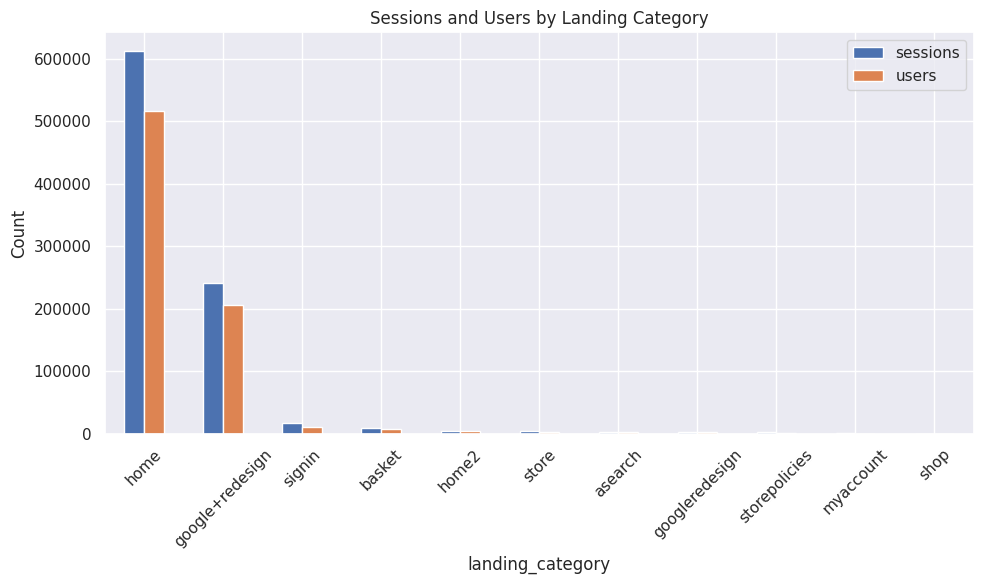

In [15]:
# 랜딩 카테고리별 세션 및 사용자 수

fig, ax = plt.subplots(figsize=(10, 6))
landing_df[['landing_category', 'sessions', 'users']].head(11).set_index('landing_category').plot(kind='bar', ax=ax)
plt.title("Sessions and Users by Landing Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-656559189.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



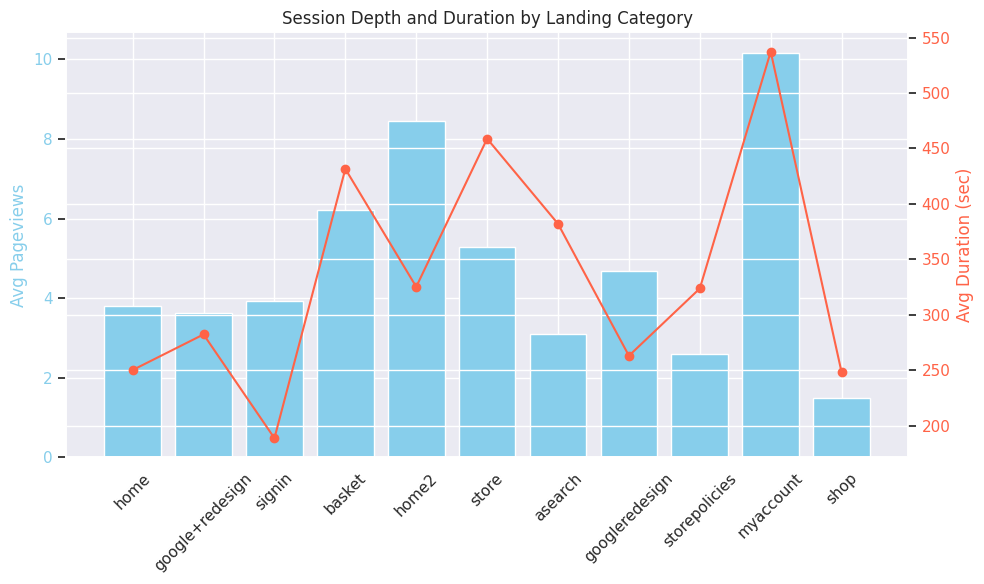

In [16]:
# 세션당 평균 페이지뷰 & 평균 체류시간
df = landing_df.head(11)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df['landing_category'], df['avg_pageviews_per_session'], color='skyblue', label='Pageviews per Session')
ax1.set_ylabel("Avg Pageviews", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(df['landing_category'], rotation=45)

# y축 공유하여 체류시간 겹쳐 그림
ax2 = ax1.twinx()
ax2.plot(df['landing_category'], df['avg_session_duration_seconds'], color='tomato', marker='o', label='Session Duration')
ax2.set_ylabel("Avg Duration (sec)", color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title("Session Depth and Duration by Landing Category")
plt.tight_layout()
plt.show()

### Landing 페이지 분석을 위한 테이블 생성(분석 기준 2)  
- 랜딩 페이지를 정제하여 그룹화
   - 정제&그룹화 CTE : 세션별 첫 랜딩 페이지를 정제해서 표준화된 segment +  기본 세션 메타 지표




In [17]:
query = """
-- [목적]
-- 세션의 첫 랜딩 페이지를 정제(clean)하고,
-- 이를 의미 있는 그룹(Home, Store_Explore, Checkout_Flow, Account, Support, Other)으로 분류하여
-- 그룹별 세션/사용자 규모 및 평균 세션 특성을 집계한다.

WITH landing_pages AS (
  SELECT
    fullVisitorId,   -- 사용자 ID
    visitId,         -- 세션 ID

    -- 원본 URL의 첫 segment 추출 (예: "/shop/product" → "shop")
    REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)') AS raw_segment,

    -- cleaned_segment: URL 정제
    CASE
      -- 중요 경로는 예외적으로 그대로 유지
      WHEN REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)') = 'google+redesign'
      THEN 'google+redesign'
      -- 그 외는 확장자, 특수문자, 언더스코어 제거하여 표준화
      ELSE REGEXP_REPLACE(
        REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_EXTRACT(hits.page.pagePath, r'^/([^/?]+)'),  -- 첫 segment
            r'\.html?|\.axd|\.htm', ''   -- 확장자 제거
          ),
          r'[^\w]', ''                   -- 알파벳/숫자/언더스코어만 남김
        ),
        r'[_]', ''                       -- 언더스코어 제거
      )
    END AS cleaned_segment,

    -- 세션 지표
    totals.pageviews AS total_pageviews,     -- 세션 내 페이지뷰 수
    totals.timeOnSite AS time_on_site,       -- 세션 체류 시간(초)
    totals.newVisits AS is_new_visit         -- 신규 방문 여부
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    -- 분석 기간: 2016-08-01 ~ 2017-08-01
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.type = 'PAGE'   -- 페이지뷰 이벤트만 포함
    AND hits.hitNumber = 1   -- 세션의 첫 페이지(=랜딩 페이지만 추출)
)

-- [최종 집계]
SELECT
  -- cleaned_segment를 의미 있는 카테고리 그룹으로 묶음
  CASE
    WHEN cleaned_segment IN ('home', 'home2') THEN 'Home'
    WHEN cleaned_segment IN (
      'google+redesign', 'googleredesign', 'store', 'shop', 'storeitem',
      'topsellers', 'asearch', 'eco', 'madeinusa', 'new', 'specials'
    ) THEN 'Store_Explore'
    WHEN cleaned_segment IN (
      'basket', 'payment', 'revieworder', 'wishlist', 'ordercompleted'
    ) THEN 'Checkout_Flow'
    WHEN cleaned_segment IN (
      'signin', 'myaccount', 'register', 'registersuccess', 'yourinfo', 'guestregister'
    ) THEN 'Account'
    WHEN cleaned_segment = 'storepolicies' THEN 'Support'
    ELSE 'Other'
  END AS landing_group,

  -- 집계 지표
  COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitId AS STRING))) AS sessions,   -- 세션 수
  COUNT(DISTINCT fullVisitorId) AS users,                                       -- 사용자 수
  SUM(is_new_visit) AS new_sessions,                                            -- 신규 세션 수
  ROUND(AVG(total_pageviews), 2) AS avg_pageviews_per_session,                  -- 평균 페이지뷰
  ROUND(AVG(time_on_site), 2) AS avg_session_duration_seconds                   -- 평균 체류 시간(초)
FROM
  landing_pages
WHERE
  cleaned_segment IS NOT NULL AND cleaned_segment != ''   -- 유효한 랜딩만
GROUP BY
  landing_group
ORDER BY
  sessions DESC    -- 세션 수 기준 내림차순 정렬
"""

landing_df2 = client.query(query).to_dataframe()
landing_df2

<>:25: SyntaxWarning:

invalid escape sequence '\.'

<>:25: SyntaxWarning:

invalid escape sequence '\.'

/tmp/ipython-input-1056150655.py:25: SyntaxWarning:

invalid escape sequence '\.'



,landing_group,sessions,users,new_sessions,avg_pageviews_per_session,avg_session_duration_seconds
0,Home,616812,518728,503035,3.84,251.12
1,Store_Explore,251174,212095,187711,3.66,286.08
2,Account,16904,10869,4468,4.08,202.03
3,Checkout_Flow,9475,7538,3265,6.24,433.24
4,Support,2060,1747,918,2.59,323.70


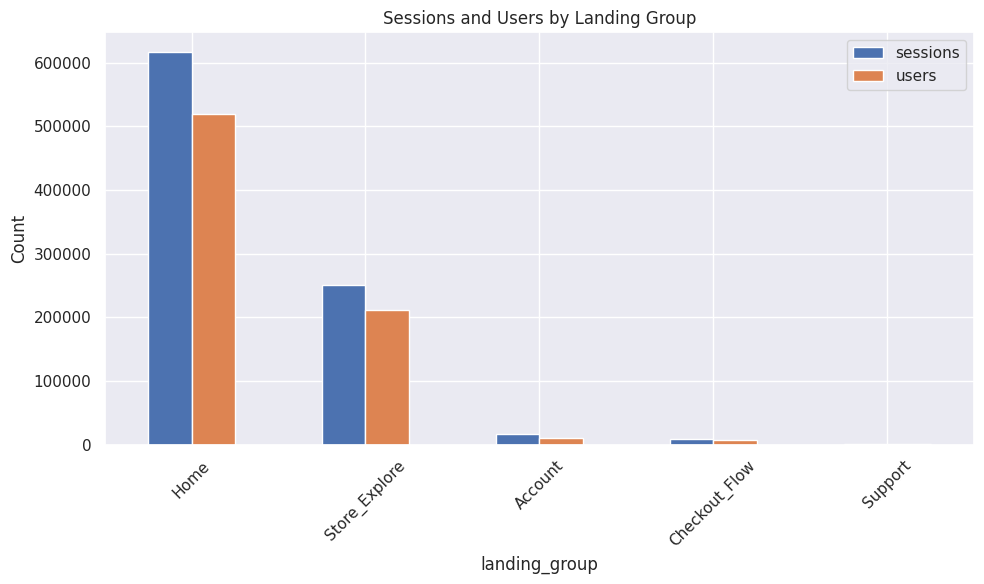

In [18]:
# 랜딩 카테고리별 세션 및 사용자 수

fig, ax = plt.subplots(figsize=(10, 6))
landing_df2[['landing_group', 'sessions', 'users']].set_index('landing_group').plot(kind='bar', ax=ax)
plt.title("Sessions and Users by Landing Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

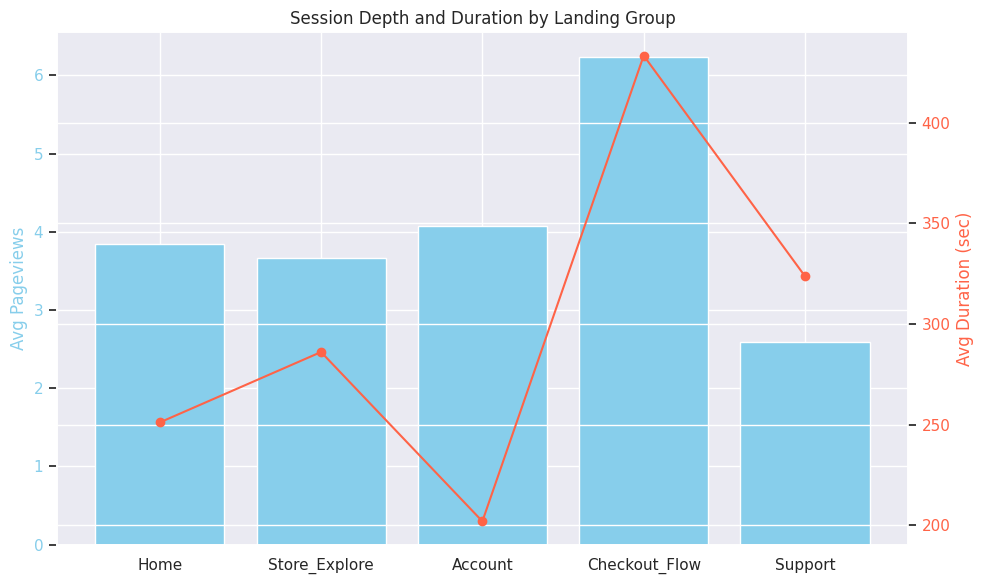

In [19]:
# 세션당 평균 페이지뷰 & 평균 체류시간
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(landing_df2['landing_group'], landing_df2['avg_pageviews_per_session'], color='skyblue', label='Pageviews per Session')
ax1.set_ylabel("Avg Pageviews", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# y축 공유하여 체류시간 겹쳐 그림
ax2 = ax1.twinx()
ax2.plot(landing_df2['landing_group'], landing_df2['avg_session_duration_seconds'], color='tomato', marker='o', label='Session Duration')
ax2.set_ylabel("Avg Duration (sec)", color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title("Session Depth and Duration by Landing Group")
plt.tight_layout()
plt.show()

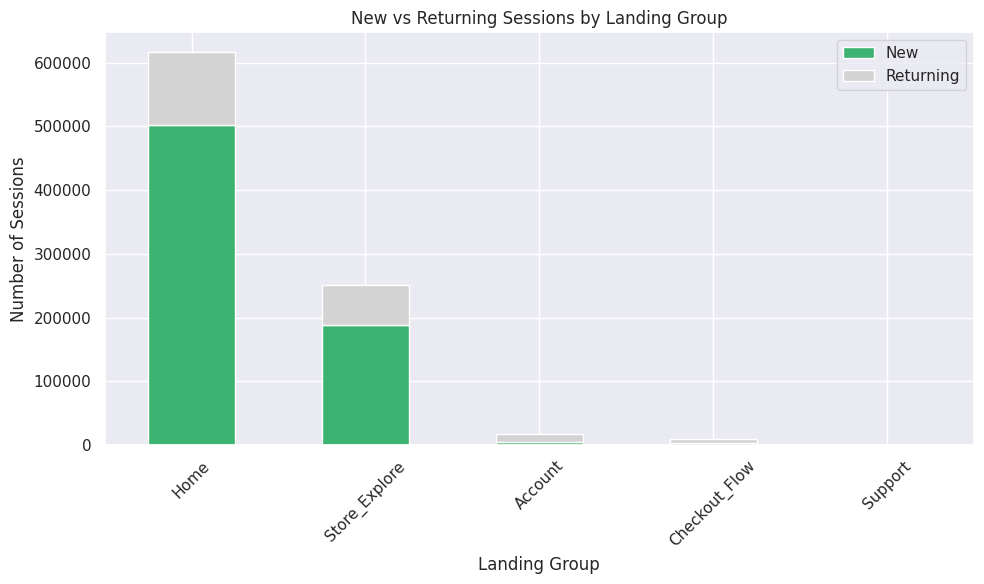

In [20]:
# 신규 유입률 비율 비교
landing_df2['returning_sessions'] = landing_df2['sessions'] - landing_df2['new_sessions']

landing_df2_plot = landing_df2[['landing_group', 'new_sessions', 'returning_sessions']].set_index('landing_group')

landing_df2_plot.plot(kind='bar', stacked=True, figsize=(10,6), color=['mediumseagreen', 'lightgray'])

plt.title("New vs Returning Sessions by Landing Group")
plt.ylabel("Number of Sessions")
plt.xlabel("Landing Group")
plt.xticks(rotation=45)
plt.legend(["New", "Returning"])
plt.tight_layout()
plt.show()

### 초기흐름(랜딩->2nd) 분석을 위한 테이블 생성
  - session_pages : 세션 단위의 방문 경로와 기본 메타데이터를 준비
  - labeled_pages : 세션마다 **첫 2단계 경로(landing → second)** 만 남김
  - cleaned_paths : 불규칙한 URL을 표준화된 segment 단위로 변환
  - grouped_paths : **의미 있는 카테고리 단위(UX/콘텐츠 흐름)**로 경로 단순화
  - 최종 SELECT : landing_group → second_group 조합별 집계

In [10]:
query = """
-- 세션 단위의 첫 두 페이지(랜딩→두번째) 흐름을 정제/그룹화하여 집계하는 쿼리
WITH session_pages AS (
  SELECT
    fullVisitorId,                -- 사용자 식별자
    visitId,                      -- 세션 식별자

    -- 세션 내 페이지 순서를 배열로 저장 (hitNumber 순서대로)
    ARRAY_AGG(hits.page.pagePath ORDER BY hits.hitNumber) AS page_sequence,

    -- 세션 단위 지표
    MAX(totals.pageviews) AS total_pageviews,     -- 총 페이지뷰
    MAX(totals.timeOnSite) AS time_on_site,       -- 세션 체류 시간(초)
    MAX(totals.newVisits) AS is_new_visit         -- 신규 방문 여부 (1=신규)
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  -- 분석 기간
    AND hits.type = 'PAGE'                           -- 페이지뷰 이벤트만
  GROUP BY fullVisitorId, visitId
),

labeled_pages AS (
  SELECT
    fullVisitorId,
    visitId,

    -- 배열에서 첫 번째 페이지(랜딩)와 두 번째 페이지만 추출
    page_sequence[OFFSET(0)] AS landing_page,
    page_sequence[OFFSET(1)] AS second_page,

    total_pageviews,
    time_on_site,
    is_new_visit
  FROM session_pages
  WHERE ARRAY_LENGTH(page_sequence) >= 2   -- 최소 2개 페이지 이상 본 세션만
),

cleaned_paths AS (
  SELECT
    fullVisitorId,
    visitId,

    -- 랜딩 페이지 정제
    CASE
      WHEN REGEXP_EXTRACT(landing_page, r'^/([^/?]+)') = 'google+redesign'
      THEN 'google+redesign'   -- 중요 경로는 그대로 유지
      ELSE REGEXP_REPLACE(
        REGEXP_REPLACE(
          REGEXP_REPLACE(REGEXP_EXTRACT(landing_page, r'^/([^/?]+)'), r'\.html?|\.axd|\.htm', ''), -- 확장자 제거
          r'[^\w]', ''   -- 특수문자 제거
        ),
        r'[_]', ''       -- 언더스코어 제거
      )
    END AS landing_segment,

    -- 두 번째 페이지 정제 (위와 동일 규칙)
    CASE
      WHEN REGEXP_EXTRACT(second_page, r'^/([^/?]+)') = 'google+redesign'
      THEN 'google+redesign'
      ELSE REGEXP_REPLACE(
        REGEXP_REPLACE(
          REGEXP_REPLACE(REGEXP_EXTRACT(second_page, r'^/([^/?]+)'), r'\.html?|\.axd|\.htm', ''),
          r'[^\w]', ''
        ),
        r'[_]', ''
      )
    END AS second_segment,

    total_pageviews,
    time_on_site,
    is_new_visit
  FROM labeled_pages
),

grouped_paths AS (
  SELECT
    -- 랜딩 페이지 카테고리 그룹화
    CASE
      WHEN landing_segment IN ('home', 'home2') THEN 'Home'
      WHEN landing_segment IN ('google+redesign', 'googleredesign', 'store', 'shop', 'storeitem',
                               'topsellers', 'asearch', 'eco', 'madeinusa', 'new', 'specials') THEN 'Store_Explore'
      WHEN landing_segment IN ('basket', 'payment', 'revieworder', 'wishlist', 'ordercompleted') THEN 'Checkout_Flow'
      WHEN landing_segment IN ('signin', 'myaccount', 'register', 'registersuccess', 'yourinfo', 'guestregister') THEN 'Account'
      WHEN landing_segment = 'storepolicies' THEN 'Support'
      ELSE 'Other'
    END AS landing_group,

    -- 두 번째 페이지 카테고리 그룹화
    CASE
      WHEN second_segment IN ('home', 'home2') THEN 'Home'
      WHEN second_segment IN ('google+redesign', 'googleredesign', 'store', 'shop', 'storeitem',
                              'topsellers', 'asearch', 'eco', 'madeinusa', 'new', 'specials') THEN 'Store_Explore'
      WHEN second_segment IN ('basket', 'payment', 'revieworder', 'wishlist', 'ordercompleted') THEN 'Checkout_Flow'
      WHEN second_segment IN ('signin', 'myaccount', 'register', 'registersuccess', 'yourinfo', 'guestregister') THEN 'Account'
      WHEN second_segment = 'storepolicies' THEN 'Support'
      ELSE 'Other'
    END AS second_group,

    fullVisitorId,
    visitId,
    total_pageviews,
    time_on_site,
    is_new_visit
  FROM cleaned_paths
)

-- 최종 집계 결과
SELECT
  landing_group,          -- 첫 페이지 그룹
  second_group,           -- 두 번째 페이지 그룹
  COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitId AS STRING))) AS sessions,   -- 세션 수
  COUNT(DISTINCT fullVisitorId) AS users,                                       -- 사용자 수
  SUM(is_new_visit) AS new_sessions,                                            -- 신규 세션 수
  ROUND(AVG(total_pageviews), 2) AS avg_pageviews_per_session,                  -- 평균 페이지뷰
  ROUND(AVG(time_on_site), 2) AS avg_session_duration_seconds                   -- 평균 체류시간
FROM grouped_paths
GROUP BY landing_group, second_group
ORDER BY sessions DESC
"""

session_pages2 = client.query(query).to_dataframe()

<>:51: SyntaxWarning:

invalid escape sequence '\.'

<>:51: SyntaxWarning:

invalid escape sequence '\.'

/tmp/ipython-input-1159546.py:51: SyntaxWarning:

invalid escape sequence '\.'



In [11]:
# 세션 수가 20개 이상인 값만 가져옴(분석 타당성)
session_pages2 = session_pages2[session_pages2['sessions']>20]
session_pages2.head(4)

,landing_group,second_group,sessions,users,new_sessions,avg_pageviews_per_session,avg_session_duration_seconds
0,Home,Home,167380,150486,140105,6.10,236.99
1,Home,Store_Explore,130253,109475,92936,7.37,275.75
2,Store_Explore,Store_Explore,90866,81564,66447,6.76,293.94
3,Store_Explore,Home,19529,18994,16236,6.02,226.44


In [23]:
## Landing -> Second Page 주요 흐름 분석(Sankey 시각화)
# 시각화 : Sankey Diagram
import plotly.graph_objects as go
df = session_pages2


# 1. 역할별 명시
df['source'] = df['landing_group'] + ' (Landing)'
df['target'] = df['second_group'] + ' (Second)'

# 2. 고유 레이블과 인덱스 매핑
labels = pd.unique(df[['source', 'target']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}
df['source_id'] = df['source'].map(label_map)
df['target_id'] = df['target'].map(label_map)

# 3. Sankey 차트 생성
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=15, thickness=20),
    link=dict(source=df['source_id'], target=df['target_id'], value=df['sessions'])
)])
fig.update_layout(title_text="Sankey: Landing → Second with Role Separation", font_size=12)
fig.show()

[결과해석]  
1. Home -> Home
- 가장 많은 비율을 차지하고 있으며, 많은 사용자가 홈에서 시작해서 홈 안에서 또 다시 페이지 확인(리프레스 또는 탭 전환 등)
- 홈 페이지 자체의 콘텐츠 다양성 or 처음 진입 후 추가 행동 없이 머물렀을 가능성
2. Home -> Store_Explore
- 두 번째로 많은 흐름으로, 홈에서 제품 탐색으로 이어지는 일반적인 쇼핑 흐름을 보여줌
3. Store_Explore -> Store_Explore
- 제품 탐색에서 또 다른 탐색으로 이어짐
- 카테고리 간 내부 이동이 많고 사용자가 여러 상품군을 비교할 가능성을 보임
4. Home/Store_Explore → Checkout_Flow/Account/Support
- 일부 흐름이 결제 츨로우 또는 로그인/회원가입으로 이어짐
- 첫 랜딩 페이지부터 두 번째 페이지까지 구매 여정으로 넘어가는 비율은 상대적으로 낮지만 존재하긴 함

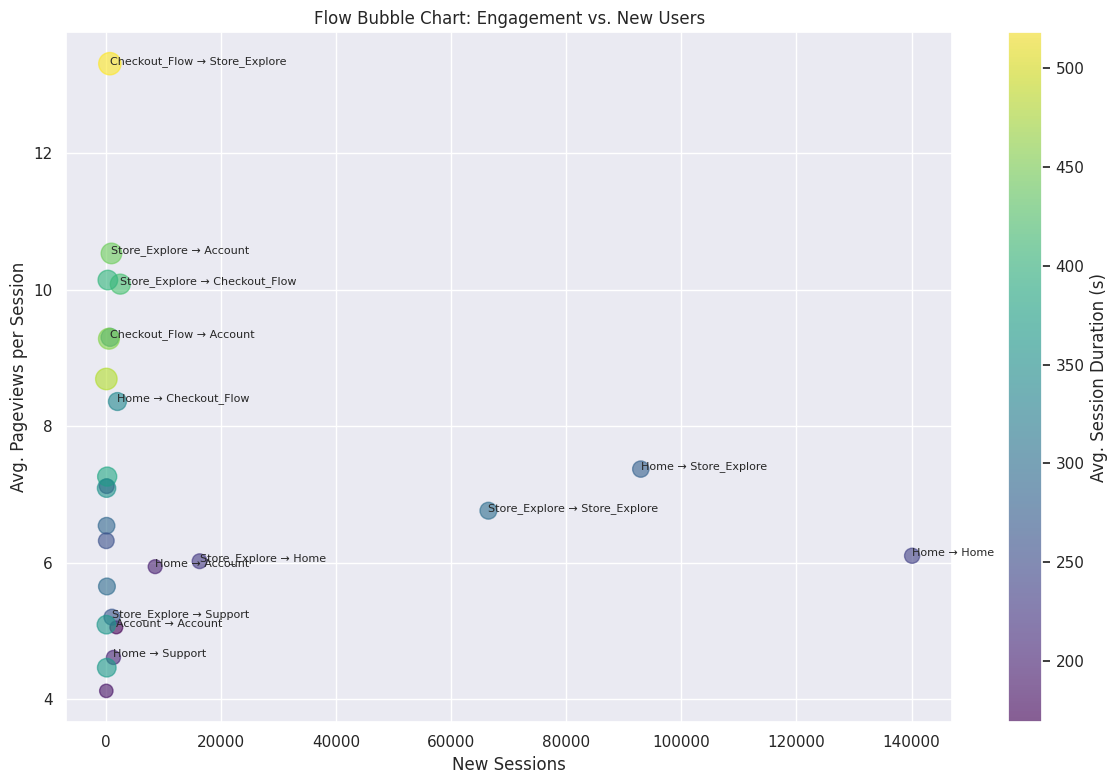

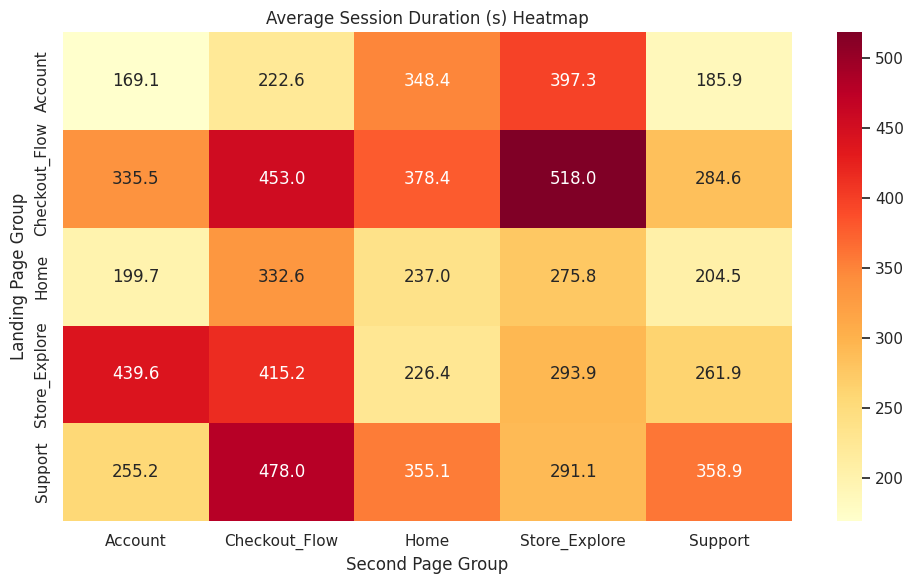

/tmp/ipython-input-3576548337.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




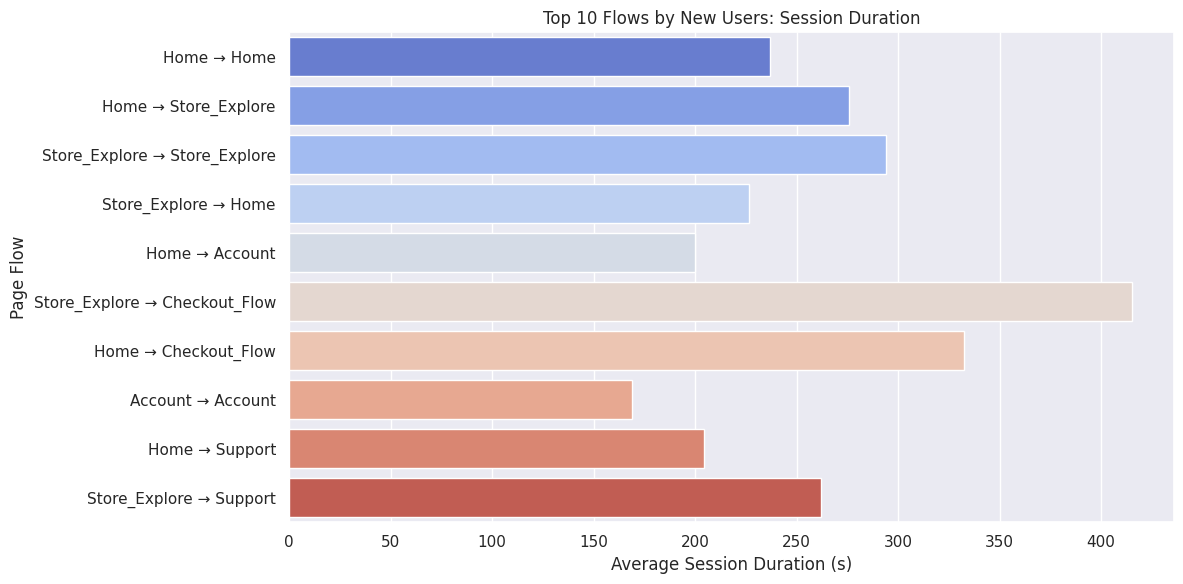

In [12]:
## 다양한 시각화
import matplotlib.pyplot as plt
import seaborn as sns

df = session_pages2

# 전처리: 흐름 라벨 생성
df['flow'] = df['landing_group'] + " → " + df['second_group']

# Plot 1: Bubble Chart (새 유저 수 vs 페이지뷰, 버블 크기는 세션 길이)
plt.figure(figsize=(12, 8))
bubble = plt.scatter(
    df["new_sessions"],
    df["avg_pageviews_per_session"],
    s=df["avg_session_duration_seconds"] * 0.5,
    alpha=0.6,
    c=df["avg_session_duration_seconds"],
    cmap="viridis"
)
for i, row in df.iterrows():
    if row["new_sessions"] > 500:
        plt.text(row["new_sessions"], row["avg_pageviews_per_session"], row["flow"], fontsize=8)

plt.colorbar(label="Avg. Session Duration (s)")
plt.xlabel("New Sessions")
plt.ylabel("Avg. Pageviews per Session")
plt.title("Flow Bubble Chart: Engagement vs. New Users")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Heatmap (landing → second 별 평균 체류시간)
pivot_duration = df.pivot(index="landing_group", columns="second_group", values="avg_session_duration_seconds")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_duration, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Session Duration (s) Heatmap")
plt.xlabel("Second Page Group")
plt.ylabel("Landing Page Group")
plt.tight_layout()
plt.show()

# Plot 3: Top 10 전환 플로우 별 평균 체류시간 막대그래프
top10 = df.sort_values("new_sessions", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_session_duration_seconds", y="flow", data=top10, palette="coolwarm")
plt.xlabel("Average Session Duration (s)")
plt.ylabel("Page Flow")
plt.title("Top 10 Flows by New Users: Session Duration")
plt.tight_layout()
plt.show()


[결과 해석]
### 버블 차트(Engagement vs. New Users)
- Home -> Home은 유입량은 많지만 평균 페이지뷰와 세션 지속시간은 낮음 : 많은 신규 유입이 페이지뷰나 체류 시간이 많은 것을 의미하지 않음
- Checkout_Flow → Store_Explore나 Store_Explore → Checkout_Flow 같은 경로는 신규 세션 수는 적지만, 페이지뷰/세션 체류 시간이 모두 높음 : 전환 가능성이 높은 흐름

### 히트맵(Average Session Duration by Flow)
- Checkout_Flow → Store_Explore : 체류 시간이 가장 긴 것으로 보아 관심도 높음
- Support로 유입되어 Checkout_Flow로 이어지는 흐름도 높은 몰입도를 보임
- Account → Account나 Account → Store_Explore 등 : 낮은 값으로 내부 탐색은 활발하지 않음(계정의 경우 많은 시간이 걸리지 않는 가능성 존재)

## 1-2. 페이지 네비게이션 쿼리

- GA 샘플 데이터에서 세션 단위로 첫 페이지(랜딩)와 두 번째 페이지를 추출
  - hit : 세션 내 각 페이지 방문 기록을 단위화
  - ordered : 세션별 순서화된 페이지 방문 시퀀스 구축

In [21]:
query ="""
-- 세션 단위로 "첫 방문 페이지(랜딩)"와 "두 번째 페이지"를 추출하여
-- 사용자 네비게이션 흐름(첫 → 두 번째)을 분석을 위함
WITH hit AS (
  -- ① 개별 hit(페이지뷰 이벤트) 단위 데이터 구성
  SELECT
    CONCAT(fullVisitorId, '_', CAST(visitId AS STRING))  AS session_id,   -- 세션 고유 ID
    VisitNumber                                          AS visit_number, -- 방문 순번 (1=첫방문, 2↑=재방문)
    totals.pageviews                                     AS session_pvs,  -- 세션 내 페이지뷰 수
    totals.timeOnSite                                    AS session_time_sec, -- 세션 체류 시간(초)
    hits.hitNumber                                       AS hit_num,      -- 세션 내 hit 번호
    hits.page.pagePath                                   AS page_path     -- 방문한 페이지 경로
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'      -- 분석 기간
    AND hits.page.pagePath IS NOT NULL                   -- 페이지 경로가 존재하는 경우만
),

ordered AS (
  -- ② 세션별 페이지 순서 정렬 및 "두 번째 페이지(second_path)" 계산
  SELECT
    *,
    ROW_NUMBER() OVER(PARTITION BY session_id ORDER BY hit_num) AS rn,   -- 세션 내 방문 순번
    LEAD(page_path) OVER(PARTITION BY session_id ORDER BY hit_num) AS second_path -- 바로 다음 페이지
  FROM hit
)

-- ③ 최종 추출: 세션의 첫 페이지(rn=1)와 그 다음(second_path)만 가져오기
SELECT
  session_id,
  visit_number,        -- 방문 순번 (신규/재방문 구분 가능)
  session_pvs,         -- 세션 내 페이지뷰 수
  session_time_sec,    -- 세션 체류 시간
  page_path   AS landing_path,   -- 첫 페이지
  second_path          -- 두 번째 페이지
FROM ordered
WHERE rn = 1
  AND second_path IS NOT NULL;   -- 두 번째 페이지가 존재하는 세션만
"""

Navi_page = client.query(query).to_dataframe()
Navi_page

,session_id,visit_number,session_pvs,session_time_sec,landing_path,second_path
0,0002591135526102361_1472265925,1,31,852,/home,/home
1,0081840705529000272_1483557886,5,35,1289,/home-2,/home-2
2,011496757794592266_1475379624,1,25,1471,/home,/home
3,0182664823417063218_1471651979,6,27,446,/home,/google+redesign/bags
4,0209144797105877307_1488434505,1,30,522,/google+redesign/office/writing/retractable+ba...,/google+redesign/apparel/men++s
...,...,...,...,...,...,...
456475,8312399006492192583_1482248159,1,20,263,/home,/home
456476,8477845554065299759_1474648093,3,20,259,/home,/home
456477,8706101242961236491_1492348748,1,20,307,/home,/home
456478,9669933764937008223_1490483332,1,20,722,/google+redesign/bags/backpacks/25l+classic+ru...,/google+redesign/bags


In [22]:
# 페이지(pagepath) 정제하는 함수 정의
import re

def clean_page_path(path):
    # 1. 첫 segment 추출
    match = re.match(r'^/([^/?]+)', path)
    if not match:
        return 'unknown'
    segment = match.group(1)

    # 3. 나머지는 정제 처리
    cleaned = re.sub(r'\.html?|\.axd|\.htm', '', segment)  # 확장자 제거
    cleaned = re.sub(r'[^\w]', '', cleaned)                # 알파벳/숫자/언더스코어만 남김
    cleaned = cleaned.replace('_', '')                     # 언더스코어 제거
    return cleaned.lower()


In [23]:
## 페이지 정제
Navi_page['landing_path'] = Navi_page['landing_path'].apply(clean_page_path)
Navi_page['second_path'] = Navi_page['second_path'].apply(clean_page_path)

In [24]:
## 페이지 초기 흐름 시각화
import pandas as pd
import plotly.graph_objects as go

# ───────────────────────────────────────────
# 1) 집계: 총 세션 / 평균 PV / 평균 체류시간
# ───────────────────────────────────────────
Navi_page['visit_type'] = Navi_page['visit_number'].apply(
    lambda x: 'first_visit' if x == 1 else 'repeat_visit'
)

agg = (
    Navi_page
      .groupby(['visit_type', 'landing_path', 'second_path'])
      .agg(
          session_cnt      = ('session_id',        'nunique'),
          avg_pageviews    = ('session_pvs',       'mean'),
          avg_session_time = ('session_time_sec',  'mean')
      )
      .reset_index()
      .sort_values('session_cnt', ascending=False)
)

# ───────────────────────────────────────────
# 2) Sankey 시각화 함수
# ───────────────────────────────────────────
def make_sankey(df, title, top_n=20):
    df_top = df.head(top_n)
    nodes = pd.unique(df_top[['landing_path','second_path']].values.ravel())
    idx   = {n:i for i,n in enumerate(nodes)}

    fig = go.Figure(data=[go.Sankey(
        node=dict(label=nodes, pad=15, thickness=20),
        link=dict(
            source = df_top['landing_path'].map(idx),
            target = df_top['second_path'].map(idx),
            value  = df_top['session_cnt'],
            customdata = df_top[['avg_pageviews','avg_session_time']],
            hovertemplate=(
                '%{source.label} → %{target.label}<br>' +
                '세션 수: %{value}<br>' +
                '평균 PV: %{customdata[0]:.1f}<br>' +
                '평균 체류: %{customdata[1]:.1f}s'
            )
        )
    )])
    fig.update_layout(title_text=title, font_size=12)
    fig.show()

In [25]:
# ───────────────────────────────────────────
# 3) 신규·재방문 별 Sankey 그리기
# ───────────────────────────────────────────
make_sankey(
    agg[agg['visit_type']=='first_visit'],
    "Landing → Second (신규 방문)",
    top_n=50
)

make_sankey(
    agg[agg['visit_type']=='repeat_visit'],
    "Landing → Second (재방문)",
    top_n=50
)

In [26]:
# 총 세션수가 50개 이상인 경우만 확인
agg = agg[agg['session_cnt']>50]

In [27]:
# 신규/재방문자에 따른 초기 흐름 세션수 비교
import plotly.express as px

# 🔹 집단별로 Heat-map 두 장을 나란히 배치
for vt, g in agg.groupby('visit_type'):
    title = 'Landing → Second Heat-map – ' + ('신규 방문' if vt=='first_visit' else '재방문')

    # 피벗: 행=Landing · 열=Second · 값=세션 수
    heat_df = g.pivot_table(
        index='landing_path', columns='second_path',
        values='session_cnt', fill_value=0, aggfunc='sum'
    )

    fig = px.imshow(
        heat_df,
        color_continuous_scale='Blues',
        aspect='auto',
        labels=dict(color='Sessions'),
        title=title
    )
    fig.update_xaxes(side='top')
    fig.show()


In [28]:
## 상위 20개 페이지 흐름별 평균 체류시간 (방문유형 구분
top = (
    agg.sort_values('session_cnt', ascending=False)
        .groupby('visit_type').head(20)
        .assign(flow=lambda d: d['landing_path'] + '→' + d['second_path'])
)

fig = px.bar(
    top,
    x='flow', y='avg_session_time',
    color='visit_type',
    barmode='group',
    title='Top 20 Flows – 평균 체류시간',
    labels={'avg_session_time':'Avg Time (sec)'},
)
fig.update_layout(xaxis_tickangle=-45, height=600)
fig.show()

In [29]:
agg.sort_values('session_cnt', ascending=False)

,visit_type,landing_path,second_path,session_cnt,avg_pageviews,avg_session_time
37,first_visit,home,home,154841,5.65874,211.443733
36,first_visit,home,googleredesign,73404,6.652812,247.315278
24,first_visit,googleredesign,googleredesign,61429,6.137104,250.134737
163,repeat_visit,home,googleredesign,30590,9.315005,369.1986
164,repeat_visit,home,home,29849,8.194162,368.427312
...,...,...,...,...,...,...
83,first_visit,signin,home,60,5.016667,217.65
94,first_visit,store,home,60,5.2,195.016667
15,first_visit,basket,storepolicies,59,5.40678,165.983051
124,repeat_visit,basket,asearch,57,11.894737,555.596491


In [30]:
# 코드 범주화
# 1) 세그먼트 → 그룹 매핑 딕셔너리 -------------------------
segment_map = {
    # Home
    **{k: 'Home' for k in ['home', 'home2']},

    # Store_Explore
    **{k: 'Store_Explore' for k in [
        'google+redesign','googleredesign','store','shop','storeitem',
        'topsellers','asearch','eco','madeinusa','new','specials'
    ]},

    # Checkout_Flow
    **{k: 'Checkout_Flow' for k in [
        'basket','payment','revieworder','wishlist','ordercompleted'
    ]},

    # Account
    **{k: 'Account' for k in [
        'signin','myaccount','register','registersuccess','yourinfo','guestregister'
    ]},

    # Support
    'storepolicies': 'Support'
}

def map_group(seg):
    return segment_map.get(seg, 'Other')

# 2) 그룹 컬럼 추가 ---------------------------------------
agg['landing_group'] = agg['landing_path'].map(map_group)
agg['second_group']  = agg['second_path'].map(map_group)

# 3) 그룹 단위로 재집계 (세션 수 / 평균 PV / 평균 Time) -----
group_agg = (
    agg.groupby(['visit_type','landing_group','second_group'])
       .agg(
           session_cnt      = ('session_cnt','sum'),
           avg_pageviews    = ('avg_pageviews','mean'),
           avg_session_time = ('avg_session_time','mean')
       )
       .reset_index()
       .sort_values('session_cnt', ascending=False)
)

display(group_agg.head(10))  # 결과 확인

,visit_type,landing_group,second_group,session_cnt,avg_pageviews,avg_session_time
11,first_visit,Home,Home,156702,8.196058,269.401623
12,first_visit,Home,Store_Explore,79389,6.900939,272.213748
17,first_visit,Store_Explore,Store_Explore,68796,6.306075,236.920254
33,repeat_visit,Home,Store_Explore,34102,8.392411,343.371233
32,repeat_visit,Home,Home,31219,9.793576,349.370568
38,repeat_visit,Store_Explore,Store_Explore,26090,8.632632,443.968098
16,first_visit,Store_Explore,Home,16013,5.522585,196.043792
9,first_visit,Home,Account,8416,7.879979,257.61551
21,repeat_visit,Account,Account,6760,6.677041,270.624412
30,repeat_visit,Home,Account,3989,9.170048,256.897787


In [32]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def _pivot(group_agg, vt, value_col):
    aggfunc = "sum" if value_col == "session_cnt" else "mean"
    pt = group_agg[group_agg["visit_type"]==vt].pivot_table(
        index="landing_group", columns="second_group", values=value_col,
        aggfunc=aggfunc, fill_value=0
    )
    # 보기 좋게 총합 기준 정렬
    pt = pt.loc[pt.sum(1).sort_values(ascending=False).index,
                pt.sum(0).sort_values(ascending=False).index]
    return pt

def heatmap_grid_onepage(group_agg: pd.DataFrame):
    metrics = [
        ("session_cnt",      "Sessions",               "Blues",  "%{z:,.0f}"),
        ("avg_pageviews",    "Avg Pageviews",          "Greens", "%{z:.2f}"),
        ("avg_session_time", "Avg Session Time (sec)", "Reds",   "%{z:.2f}")
    ]
    vts = [("first_visit","신규 방문"), ("repeat_visit","재방문")]

    # 축(행/열) 카테고리 통일
    pt0 = _pivot(group_agg, vts[0][0], metrics[0][0])
    rows = list(pt0.index); cols = list(pt0.columns)
    for vt,_ in vts:
        for m,_,_,_ in metrics:
            pt = _pivot(group_agg, vt, m)
            rows = list(dict.fromkeys(rows + list(pt.index)))
            cols = list(dict.fromkeys(cols + list(pt.columns)))

    # 각 메트릭별 컬러 스케일 범위 고정(신규/재방문 동일 스케일)
    zrange = {}
    for m,_,_,_ in metrics:
        vals = []
        for vt,_ in vts:
            pt = _pivot(group_agg, vt, m).reindex(index=rows, columns=cols, fill_value=0).astype(float)
            vals.append(pt.values.ravel())
        allv = np.concatenate(vals) if vals else np.array([0.0])
        zrange[m] = (float(np.nanmin(allv)), float(np.nanmax(allv)))

    titles = [f"{lab} — {vt_label}" for vt,vt_label in vts for (m,lab,cs,fmt) in metrics]

    fig = make_subplots(rows=2, cols=3,
                        horizontal_spacing=0.06, vertical_spacing=0.12,
                        subplot_titles=titles)

    # 채우기
    for r,(vt,vt_label) in enumerate(vts, start=1):
        for c,(m,lab,cs,fmt) in enumerate(metrics, start=1):
            pt = _pivot(group_agg, vt, m).reindex(index=rows, columns=cols, fill_value=0).astype(float)
            zmin, zmax = zrange[m]
            fig.add_trace(
                go.Heatmap(
                    z=pt.values, x=cols, y=rows, colorscale=cs,
                    zmin=zmin, zmax=zmax,
                    texttemplate=fmt, textfont=dict(size=10),
                    hovertemplate=f"Landing: %{ '{' }y{ '}' }<br>Second: %{ '{' }x{ '}' }<br>{lab}: %{ '{' }z{ '}' }<extra></extra>",
                    showscale=(r==1),  # 컬러바는 위 행만 노출
                    colorbar=dict(title=lab, len=0.45, y=0.84, x=1.02 + (c-1)*0.06) if r==1 else None
                ),
                row=r, col=c
            )

    fig.update_layout(height=900, margin=dict(l=10, r=160, t=60, b=10))
    # 열 레이블을 아래쪽으로
    fig.update_xaxes(side="bottom")
    fig.show()
    return fig

# 사용 예
fig = heatmap_grid_onepage(group_agg)


In [36]:
import numpy as np, pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# group_agg: [visit_type, landing_group, second_group, session_cnt, avg_pageviews, avg_session_time]

def _pivot(group_agg, vt, value_col, aggfunc="sum"):
    d = group_agg[group_agg["visit_type"]==vt]
    if value_col != "session_cnt": aggfunc = "mean"
    pt = d.pivot_table(index="landing_group", columns="second_group",
                       values=value_col, aggfunc=aggfunc, fill_value=0)
    # 보기 좋은 정렬(행·열 합 기준 내림차순)
    pt = pt.loc[pt.sum(1).sort_values(ascending=False).index, pt.sum(0).sort_values(ascending=False).index]
    return pt

def _normalize(mat, how="none"):
    M = mat.copy().astype(float)
    if how == "row":
        mu = M.mean(1)
        sd = M.std(1, ddof=0).replace(0, 1)
        M = (M.sub(mu, axis=0)).div(sd, axis=0)
    elif how == "col":
        mu = M.mean(0)
        sd = M.std(0, ddof=0).replace(0, 1)
        M = (M.sub(mu, axis=1)).div(sd, axis=1)
    elif how == "z":  # 전체 z
        mu = M.values.mean()
        sd = M.values.std(ddof=0) or 1.0
        M = (M - mu)/sd
    return M

def fig_heatmap_dashboard(group_agg: pd.DataFrame,
                          metrics=("session_cnt","avg_pageviews","avg_session_time"),
                          metric_labels=("Sessions","Avg Pageviews","Avg Session Time (sec)"),
                          norm_modes=("none","row","col","z"),
                          colorscales=("Blues","Greens","Reds","RdBu")) -> go.Figure:
    # 기본: 첫 metric, 원자료
    m0, lab0 = metrics[0], metric_labels[0]
    pt_f = _pivot(group_agg, "first_visit",  m0)
    pt_r = _pivot(group_agg, "repeat_visit", m0)

    # 축 고정(신규/재방문 동일 범주 쓰도록 align)
    rows = list(dict.fromkeys(list(pt_f.index)  + list(pt_r.index)))
    cols = list(dict.fromkeys(list(pt_f.columns)+ list(pt_r.columns)))
    pt_f = pt_f.reindex(index=rows, columns=cols, fill_value=0)
    pt_r = pt_r.reindex(index=rows, columns=cols, fill_value=0)

    # 초기 정규화 없고, Blues 컬러
    init_norm = "none"
    zf = _normalize(pt_f, init_norm).values
    zr = _normalize(pt_r, init_norm).values
    # 세션/평균 지표별 기본 팔레트
    pal_map = {"session_cnt":"Blues", "avg_pageviews":"Greens", "avg_session_time":"Reds"}
    colorscale_init = pal_map.get(m0, "Viridis")

    fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.08,
                        subplot_titles=("신규 방문", "재방문"))

    fig.add_trace(go.Heatmap(
        z=zf, x=cols, y=rows, coloraxis="coloraxis",
        hovertemplate="Landing: %{y}<br>Second: %{x}<br>"+lab0+": %{z:.2f}<extra></extra>"
    ), row=1, col=1)

    fig.add_trace(go.Heatmap(
        z=zr, x=cols, y=rows, coloraxis="coloraxis",
        hovertemplate="Landing: %{y}<br>Second: %{x}<br>"+lab0+": %{z:.2f}<extra></extra>"
    ), row=1, col=2)

    fig.update_layout(
        title=f"{lab0} Heatmap — 신규 vs 재방문",
        height=650, margin=dict(l=10,r=10,t=60,b=10),
        coloraxis=dict(colorscale=colorscale_init, colorbar=dict(title=lab0)),
        xaxis=dict(side="top"), xaxis2=dict(side="top")
    )

    # --- 버튼 구성: metric 토글, 정규화 토글
    buttons_metric = []
    buttons_norm   = []
    # 상태 저장용: 각 metric/norm 조합별 z행렬을 미리 계산
    state = {}
    for m, lab in zip(metrics, metric_labels):
        pf = _pivot(group_agg, "first_visit",  m)
        pr = _pivot(group_agg, "repeat_visit", m)
        pf = pf.reindex(index=rows, columns=cols, fill_value=0)
        pr = pr.reindex(index=rows, columns=cols, fill_value=0)
        for nm in norm_modes:
            state[(m,nm,"f")] = _normalize(pf, nm).values
            state[(m,nm,"r")] = _normalize(pr, nm).values

    # metric 버튼
    for m, lab in zip(metrics, metric_labels):
        cs = pal_map.get(m, "Viridis")
        buttons_metric.append(dict(
            label=lab,
            method="update",
            args=[
                {"z": [state[(m,init_norm,"f")], state[(m,init_norm,"r")]]},  # traces 0,1
                {"title": f"{lab} Heatmap — 신규 vs 재방문",
                 "coloraxis": {"colorscale": cs, "colorbar": {"title": lab}}}
            ]
        ))

    # 정규화 버튼
    norm_label = {"none":"원자료", "row":"행 z-score", "col":"열 z-score", "z":"전체 z-score"}
    for nm in norm_modes:
        buttons_norm.append(dict(
            label=norm_label[nm],
            method="update",
            args=[
                {"z": [state[(m0,nm,"f")], state[(m0,nm,"r")]]},
                {}  # layout 유지
            ]
        ))

    fig.update_layout(
        updatemenus=[
            dict(type="buttons", direction="right", x=1.0, xanchor="right",
                 y=1.18, yanchor="top", buttons=buttons_metric),
            dict(type="buttons", direction="right", x=1.0, xanchor="right",
                 y=1.08, yanchor="top", buttons=buttons_norm)
        ]
    )
    return fig

# 사용 예
fig = fig_heatmap_dashboard(group_agg)
fig.show()


In [52]:
agg

,visit_type,landing_path,second_path,session_cnt,avg_pageviews,avg_session_time,landing_group,second_group
37,first_visit,home,home,154841,5.65874,211.443733,Home,Home
36,first_visit,home,googleredesign,73404,6.652812,247.315278,Home,Store_Explore
24,first_visit,googleredesign,googleredesign,61429,6.137104,250.134737,Store_Explore,Store_Explore
163,repeat_visit,home,googleredesign,30590,9.315005,369.1986,Home,Store_Explore
164,repeat_visit,home,home,29849,8.194162,368.427312,Home,Home
...,...,...,...,...,...,...,...,...
83,first_visit,signin,home,60,5.016667,217.65,Account,Home
94,first_visit,store,home,60,5.2,195.016667,Store_Explore,Home
15,first_visit,basket,storepolicies,59,5.40678,165.983051,Checkout_Flow,Support
124,repeat_visit,basket,asearch,57,11.894737,555.596491,Checkout_Flow,Store_Explore


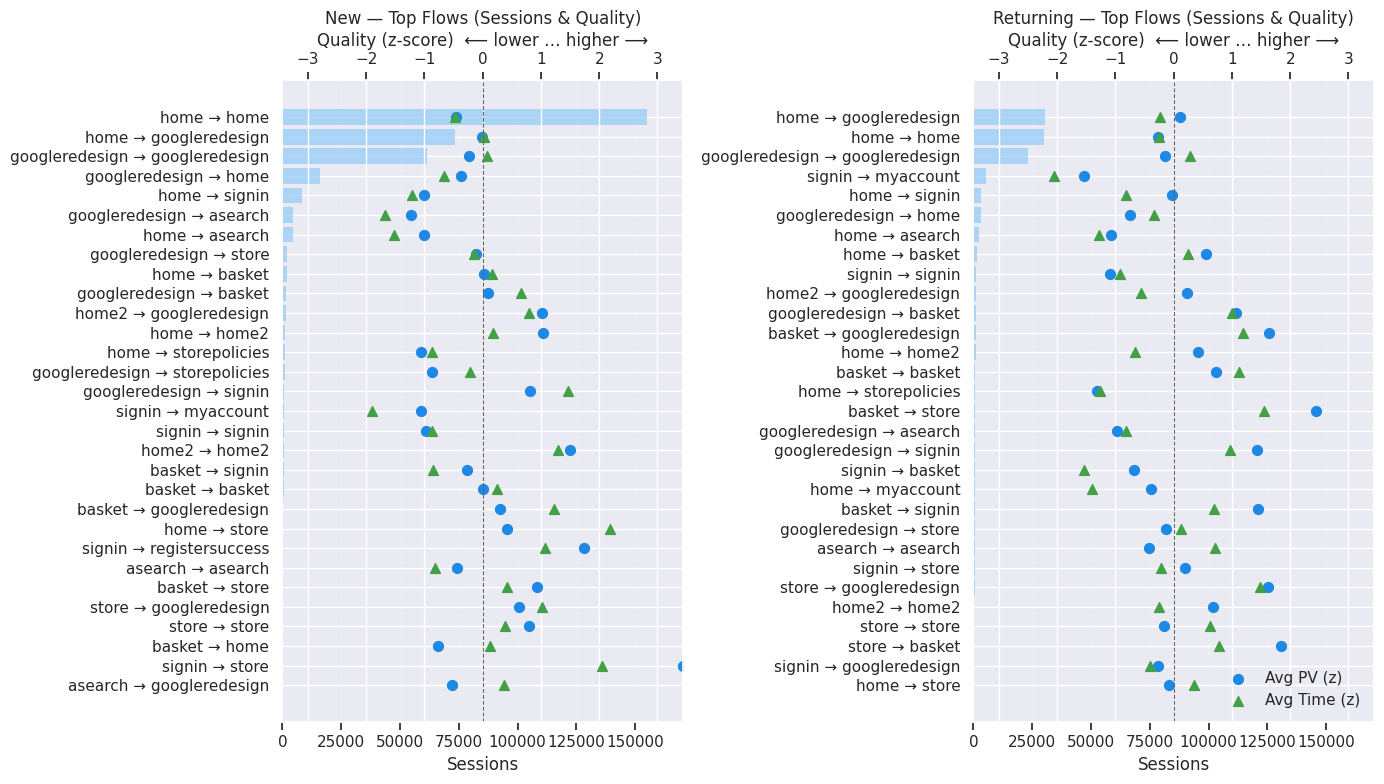

In [59]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _strips_df_within(df: pd.DataFrame, vt: str, top_n: int):
    """
    df: columns = visit_type, landing_path, second_path, session_cnt, avg_pageviews, avg_session_time
    집단(세그먼트) 내에서: 세션 합으로 Top-N 선정, PV/Time의 z-score는 '해당 집단 내부' 분포 기준
    """
    d = df[df["visit_type"]==vt].copy()
    if d.empty:
        return None
    d["pair"] = d["landing_path"].astype(str) + " → " + d["second_path"].astype(str)

    g_all = (d.groupby("pair", as_index=False)
               .agg(sessions=("session_cnt","sum"),
                    pv=("avg_pageviews","mean"),
                    tm=("avg_session_time","mean")))

    # 집단 내 z-score (Top-N이 아닌 전체 분포 기준)
    pv_mu, pv_sd = g_all["pv"].mean(), (g_all["pv"].std(ddof=0) or 1.0)
    tm_mu, tm_sd = g_all["tm"].mean(), (g_all["tm"].std(ddof=0) or 1.0)
    g_all["pv_z"] = (g_all["pv"] - pv_mu) / pv_sd
    g_all["tm_z"] = (g_all["tm"] - tm_mu) / tm_sd

    # Top-N by raw sessions
    g_top = g_all.sort_values("sessions", ascending=False).head(top_n).reset_index(drop=True)
    return g_top

def ranked_strips_dual_within(df: pd.DataFrame, top_n=15, figsize=(14,8)):
    g_new = _strips_df_within(df, "first_visit",  top_n)
    g_ret = _strips_df_within(df, "repeat_visit", top_n)

    if g_new is None and g_ret is None:
        print("No data for both segments"); return
    if g_new is None:
        print("No data for first_visit; showing repeat_visit only")
        return
    if g_ret is None:
        print("No data for repeat_visit; showing first_visit only")
        return

    # === 축 범위 통일 ===
    # 세션 막대축: 좌/우 동일
    s_lim = max(float(g_new["sessions"].max()), float(g_ret["sessions"].max()))
    s_lim = s_lim * 1.1 if s_lim > 0 else 1.0
    # 품질 z-score 축: 좌/우 동일
    z_min = np.nanmin([g_new["pv_z"].min(), g_new["tm_z"].min(),
                       g_ret["pv_z"].min(), g_ret["tm_z"].min()])
    z_max = np.nanmax([g_new["pv_z"].max(), g_new["tm_z"].max(),
                       g_ret["pv_z"].max(), g_ret["tm_z"].max()])
    z_lim = max(abs(z_min), abs(z_max), 2.0)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    def _one(ax, g, title):
        y = np.arange(len(g))
        # ✅ 세션 '원 수치' 막대 (비중 아님)
        ax.barh(y, g["sessions"], color="#90CAF9", alpha=0.7, edgecolor="none")
        ax.set_yticks(y); ax.set_yticklabels(g["pair"])
        ax.invert_yaxis()
        ax.set_xlabel("Sessions")
        ax.set_title(title + " — Top Flows (Sessions & Quality)")
        ax.grid(axis="x", alpha=0.15)
        ax.set_xlim(0, s_lim)  # 좌/우 패널 동일 범위

        # 상단 보조축: PV/Time z-score (집단 내 기준), 좌/우 동일 범위
        ax2 = ax.twiny()
        ax2.set_xlim(-z_lim, z_lim)
        ax2.set_xlabel("Quality (z-score)  ⟵ lower … higher ⟶")
        ax2.scatter(g["pv_z"], y, marker="o", s=50, c="#1E88E5", label="Avg PV (z)")
        ax2.scatter(g["tm_z"], y, marker="^", s=50, c="#43A047", label="Avg Time (z)")
        ax2.axvline(0, color="#666", linewidth=0.8, linestyle="--")
        return ax2

    ax2_left  = _one(axes[0], g_new, "New")
    ax2_right = _one(axes[1], g_ret, "Returning")
    ax2_right.legend(frameon=False, loc="lower right")

    plt.tight_layout()
    plt.show()

# 실행 예시 (agg를 넣어주세요)
ranked_strips_dual_within(agg, top_n=30)

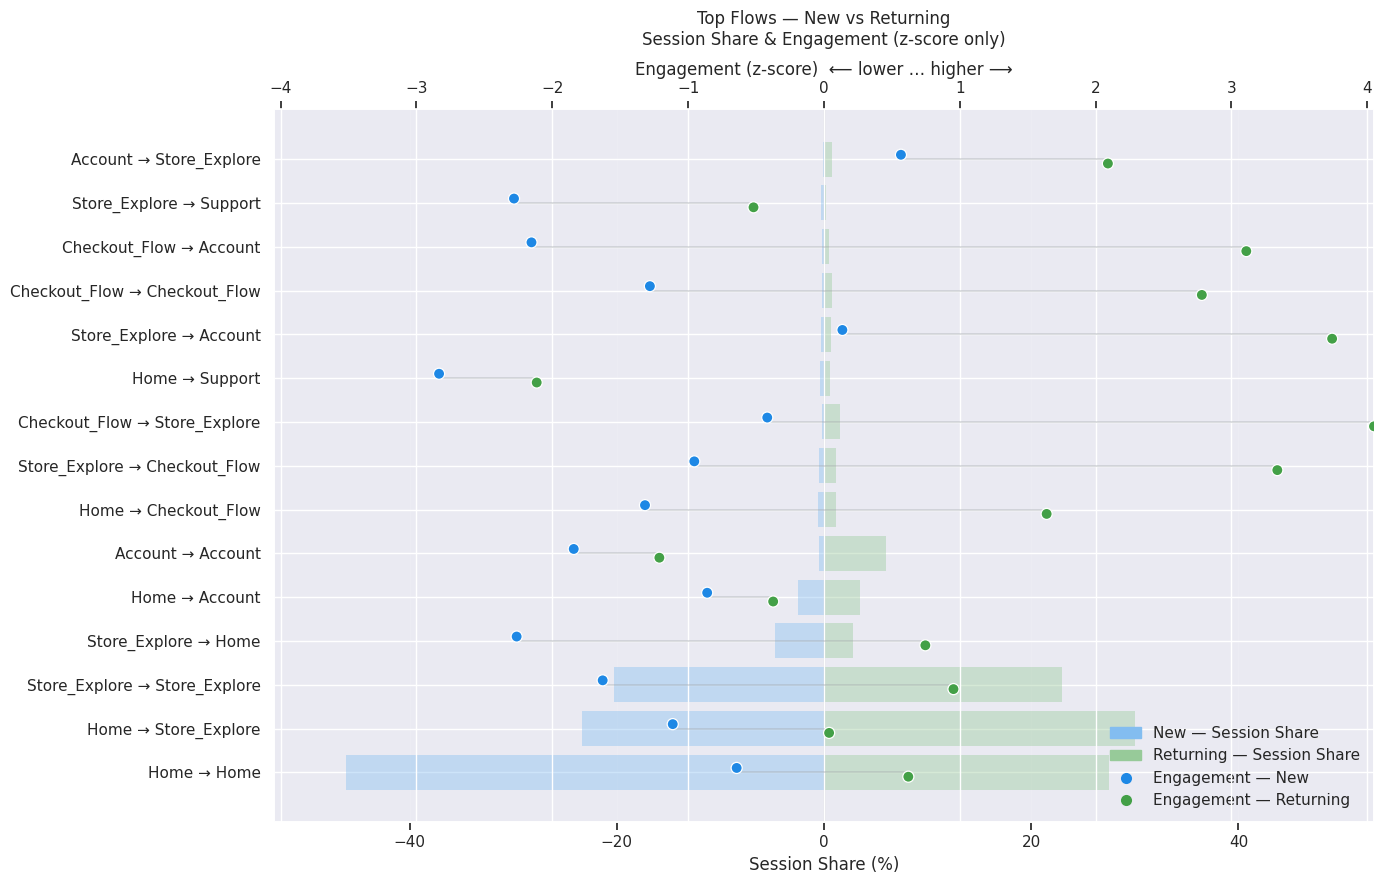

In [57]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def _tint(hex_color, t=0.6):
    """mix with white: t∈(0,1]; 1=original, 0=white"""
    h = hex_color.lstrip('#')
    r,g,b = int(h[0:2],16), int(h[2:4],16), int(h[4:6],16)
    r = int(255*(1-t) + r*t); g = int(255*(1-t) + g*t); b = int(255*(1-t) + b*t)
    return (r/255.0, g/255.0, b/255.0)

def _pooled_z(all_vals, vals):
    all_vals = np.asarray(all_vals, float); vals = np.asarray(vals, float)
    mu = np.nanmean(all_vals); sd = np.nanstd(all_vals, ddof=0) or 1.0
    return (vals - mu)/sd

def compare_flows_onechart_engagement_clear(group_agg: pd.DataFrame, top_n=15,
                                            share_mode="within", figsize=(14,9),
                                            new_hex="#1E88E5", ret_hex="#43A047",
                                            bar_tint=0.55, bar_alpha=0.4):
    """
    One chart: Session share (very light bars) + Engagement only (bold dots, white halo)
    - Colors unified by segment (New=blue, Returning=green)
    - No black outlines in legend/markers
    """
    NEW, RET = "first_visit", "repeat_visit"
    # bars: very light tint; dots: original color (for strong contrast)
    col_bar_new = _tint(new_hex, bar_tint)
    col_bar_ret = _tint(ret_hex, bar_tint)
    col_dot_new = tuple(int(new_hex.lstrip('#')[i:i+2],16)/255 for i in (0,2,4))
    col_dot_ret = tuple(int(ret_hex.lstrip('#')[i:i+2],16)/255 for i in (0,2,4))

    d = group_agg.copy()
    d["pair"] = d["landing_group"].astype(str) + " → " + d["second_group"].astype(str)
    g = (d.groupby(["visit_type","pair"], as_index=False)
           .agg(sessions=("session_cnt","sum"),
                pv=("avg_pageviews","mean"),
                tm=("avg_session_time","mean")))

    def _wide(col):
        w = g.pivot(index="pair", columns="visit_type", values=col)
        if NEW not in w.columns: w[NEW] = 0.0 if col=="sessions" else np.nan
        if RET not in w.columns: w[RET] = 0.0 if col=="sessions" else np.nan
        return w
    s_w, pv_w, tm_w = _wide("sessions").fillna(0.0), _wide("pv"), _wide("tm")

    order = s_w[[NEW,RET]].sum(axis=1).sort_values(ascending=False).head(top_n).index
    s_w, pv_w, tm_w = s_w.loc[order], pv_w.loc[order], tm_w.loc[order]
    pairs = list(s_w.index)
    y = np.arange(len(pairs))[::-1]

    # Session share
    if share_mode == "global":
        total = s_w[[NEW,RET]].to_numpy().sum() or 1.0
        share_new = (s_w[NEW]/total)*100
        share_ret = (s_w[RET]/total)*100
    else:
        total_new = s_w[NEW].sum() or 1.0
        total_ret = s_w[RET].sum() or 1.0
        share_new = (s_w[NEW]/total_new)*100
        share_ret = (s_w[RET]/total_ret)*100

    # Engagement = z(PV)+z(Time) (pooled)
    pv_all = np.concatenate([pv_w[NEW].to_numpy(), pv_w[RET].to_numpy()])
    tm_all = np.concatenate([tm_w[NEW].to_numpy(), tm_w[RET].to_numpy()])
    eng_new = _pooled_z(pv_all, pv_w[NEW].to_numpy()) + _pooled_z(tm_all, tm_w[NEW].to_numpy())
    eng_ret = _pooled_z(pv_all, pv_w[RET].to_numpy()) + _pooled_z(tm_all, tm_w[RET].to_numpy())

    fig, ax = plt.subplots(figsize=figsize)

    # very light bars pushed to background
    ax.barh(y, -share_new.values[::-1], color=col_bar_new, alpha=bar_alpha, edgecolor="none",
            label="New — Session Share", zorder=1)
    ax.barh(y,  share_ret.values[::-1], color=col_bar_ret, alpha=bar_alpha, edgecolor="none",
            label="Returning — Session Share", zorder=1)
    ax.axvline(0, color="#888", lw=0.8, zorder=2)

    ax.set_yticks(y); ax.set_yticklabels(pairs[::-1])
    ax.set_xlabel("Session Share (%)")
    ax.set_title("Top Flows — New vs Returning\nSession Share & Engagement (z-score only)", pad=12)
    ax.grid(axis="x", alpha=0.12, zorder=0)
    x_max = float(np.nanmax(np.abs(np.concatenate([share_new.values, share_ret.values]))))
    ax.set_xlim(-x_max*1.15, x_max*1.15)

    # top axis — Engagement only
    ax2 = ax.twiny()
    z_abs = np.nanmax(np.abs(np.concatenate([eng_new, eng_ret])))
    z_lim = max(z_abs, 2.0)
    ax2.set_xlim(-z_lim, z_lim)
    ax2.set_xlabel("Engagement (z-score)  ⟵ lower … higher ⟶")

    # small vertical offsets so dots don't sit exactly on bar centers
    yy_new = y + 0.1
    yy_ret = y - 0.1

    # light connection (between new & returning)
    midy = y  # draw at midline
    ax2.hlines(midy, eng_new[::-1], eng_ret[::-1], colors="#9aa0a6", alpha=0.35, linewidth=1.4, zorder=3)

    # bold dots with white halo (no black edge)
    ax2.scatter(eng_new[::-1], yy_new, s=64, c=[col_dot_new]*len(y), edgecolors="white",
                linewidths=0.9, zorder=4, label="Engagement — New")
    ax2.scatter(eng_ret[::-1],  yy_ret, s=64, c=[col_dot_ret]*len(y), edgecolors="white",
                linewidths=0.9, zorder=4, label="Engagement — Returning")

    # clean legend (no borders)
    handles = [
        Patch(color=col_bar_new, label="New — Session Share"),
        Patch(color=col_bar_ret, label="Returning — Session Share"),
        Line2D([0],[0], marker="o", markersize=8, markerfacecolor=col_dot_new,
               markeredgecolor="none", color="none", label="Engagement — New"),
        Line2D([0],[0], marker="o", markersize=8, markerfacecolor=col_dot_ret,
               markeredgecolor="none", color="none", label="Engagement — Returning"),
    ]
    ax.legend(handles=handles, frameon=False, loc="lower right")

    plt.tight_layout()
    plt.show()

# 실행 예
compare_flows_onechart_engagement_clear(group_agg, top_n=15, share_mode="within")


In [24]:
## 신규/재방분자 별 초기흐름(랜딩->2nd) 전환 비율
import plotly.express as px

# ──────────────────────────────
# 1) 기본 stacked bar
# ──────────────────────────────
fig = px.bar(
    group_agg,
    x='landing_group',
    y='session_cnt',
    color='second_group',
    facet_col='visit_type',
    category_orders={'visit_type': ['first_visit', 'repeat_visit']},
    labels={'session_cnt': 'Sessions', 'landing_group': 'Landing Group'},
    text_auto=True,
    height=650,                     # ⬆ 신규 패널 y축 여유를 위해 살짝 키움
    title='Landing → Second 세션 비중 (신규 vs 재방문 비교)'
)

fig.update_layout(barmode='stack')
fig.update_xaxes(tickangle=-45)

# ──────────────────────────────
# 2) 퍼센트 계산
# ──────────────────────────────
totals = (
    group_agg.groupby(['visit_type', 'landing_group'], as_index=False)
             .agg(session_cnt=('session_cnt', 'sum'))
)
totals['pct'] = (
    totals.groupby('visit_type')['session_cnt']
          .transform(lambda x: x / x.sum() * 100)
)

# ──────────────────────────────
# 3) y축 최대치 확보(첫 방문자 패널만 여유 15% 추가)
# ──────────────────────────────
first_max = totals.loc[totals.visit_type=='first_visit', 'session_cnt'].max()
fig.update_yaxes(range=[0, first_max*1.15], row=1, col=1)      # ⬆ 15% 여유

# ──────────────────────────────
# 4) annotation : 막대보다 3% 위에
# ──────────────────────────────
for _, row in totals.iterrows():
    col = 1 if row['visit_type'] == 'first_visit' else 2
    fig.add_annotation(
        x=row['landing_group'],
        y=row['session_cnt']+10000,
        text=f"{row['pct']:.1f}%",
        showarrow=False,
        yanchor='bottom',
        xanchor='center',
        row=1, col=col
    )

fig.show()


In [25]:
## 방문자 유형(신규/재방문) 별 Top 흐름 시각화
## 세션 수, 평균 페이지뷰, 평균 세션 체류시간 비교

# 0) 세션 수 50 미만 흐름 제거 ───────────────────────────────
group_agg = group_agg[group_agg['session_cnt'] >= 50].copy()

# ──────────────────────────────────────────
# 설정: 시각화할 지표와 레이블 정의
# ──────────────────────────────────────────
metrics = {
    'avg_session_time': 'Avg Session Time (sec)',
    'avg_pageviews':    'Avg Pageviews',
    'session_cnt':      'Session Count'
}

# 보기 쉽게 Landing→Second 그룹 조합 라벨 생성
group_agg['flow'] = group_agg['landing_group'] + ' → ' + group_agg['second_group']

# 🔹 선택: 상위 N개 흐름만 볼 수도 있음 (noise 제거)
TOP_N = 20
top_idx = (group_agg
           .sort_values('session_cnt', ascending=False)
           .groupby('visit_type')
           .head(TOP_N)).index
viz_df = group_agg.loc[top_idx]

# ──────────────────────────────────────────
# 3개 메트릭 각각 막대그래프
# ──────────────────────────────────────────
for col, y_label in metrics.items():
    fig = px.bar(
        viz_df,
        x='flow',
        y=col,
        color='visit_type',
        barmode='group',
        title=f'Landing → Second (Top {TOP_N}) — {y_label}',
        labels={col: y_label, 'flow':'Flow', 'visit_type':'Visit Type'},
        height=600
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [26]:
## 초기 흐름(그룹화된 페이지 범주 기준) Sankey 시각화
import plotly.graph_objects as go
import pandas as pd

# 링크 데이터 준비
links = group_agg[['landing_group','second_group','session_cnt']]
nodes = pd.unique(links[['landing_group','second_group']].values.ravel())
ni = {n:i for i,n in enumerate(nodes)}

fig = go.Figure(data=[go.Sankey(
    arrangement='fixed',
    node=dict(label=nodes, pad=15, thickness=15),
    link=dict(
        source = links['landing_group'].map(ni),
        target = links['second_group'].map(ni),
        value  = links['session_cnt']
    )
)])
fig.update_layout(title='Group-to-Group Flow (Circular Layout)')
fig.show()

In [39]:
## 랜딩→두 번째 페이지 흐름별 PV·체류시간·트래픽 규모
## 상세한 페이지 단위 흐름, 상위 100개만 표시

# ❶ 시각화할 컬럼 간단히 정리
plot_df = (
    agg.assign(flow=lambda d: d.landing_path + ' → ' + d.second_path)   # 흐름 라벨
       .sort_values('session_cnt', ascending=False)                     # 트래픽 큰 순
       .head(100)      # ↳ 노이즈 줄이기 위해 상위 n개만 (필요 시 조정)
)

# ❷ 버블-스캐터
fig = px.scatter(
    plot_df,
    x='avg_pageviews',
    y='avg_session_time',
    size='session_cnt',
    size_max=40,
    color='visit_type',          # 신규·재방문 색상 구분
    hover_name='flow',           # 마우스오버에 흐름 문구
    hover_data={
        'session_cnt':':,',      # 세션 수 천단위 콤마
        'avg_pageviews':':,',
        'avg_session_time':':,'
    },
    title='Landing → Second Flow : PV vs Time vs Traffic',
    labels={
        'avg_pageviews':'Avg Pageviews per Session',
        'avg_session_time':'Avg Session Time (sec)',
        'visit_type':'Visit Type'
    },
    height=650
)

fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()


In [40]:
## 카테고리 그룹 단위 흐름, 전체 표시

# ❶ 시각화할 컬럼 간단히 정리
plot_df2 = (
    group_agg.assign(flow=lambda d: d.landing_group + ' → ' + d.second_group)   # 흐름 라벨
       .sort_values('session_cnt', ascending=False)                     # 트래픽 큰 순
)

# ❷ 버블-스캐터
fig = px.scatter(
    plot_df2,
    x='avg_pageviews',
    y='avg_session_time',
    size='session_cnt',
    size_max=40,
    color='visit_type',          # 신규·재방문 색상 구분
    hover_name='flow',           # 마우스오버에 흐름 문구
    hover_data={
        'session_cnt':':,',      # 세션 수 천단위 콤마
        'avg_pageviews':':,',
        'avg_session_time':':,'
    },
    title='Landing → Second Flow : PV vs Time vs Traffic',
    labels={
        'avg_pageviews':'Avg Pageviews per Session',
        'avg_session_time':'Avg Session Time (sec)',
        'visit_type':'Visit Type'
    },
    height=650
)

fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()


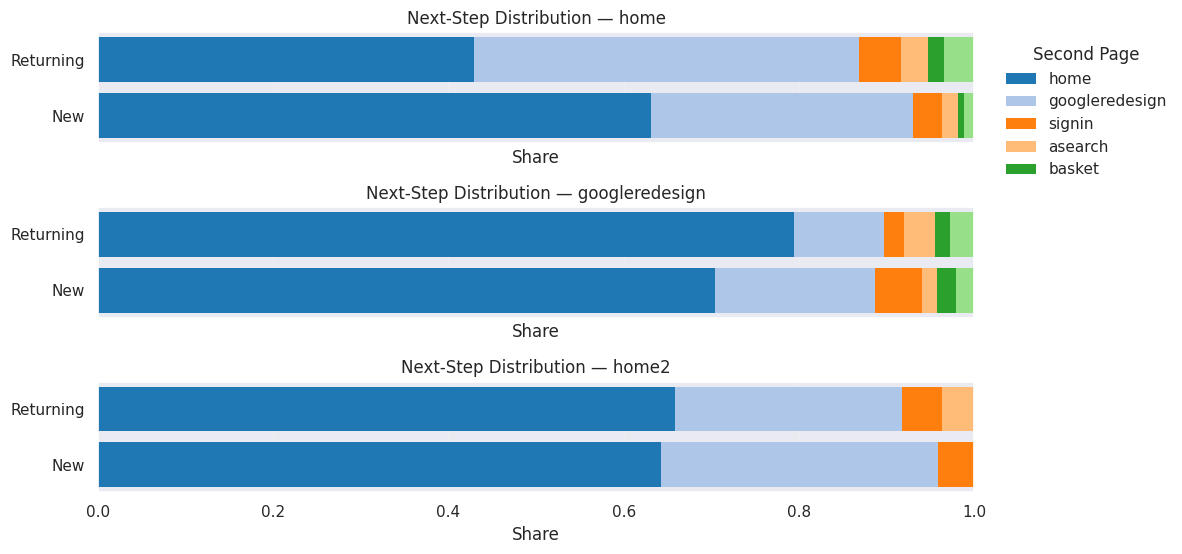

In [67]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

def plot_branching_100(group_agg: pd.DataFrame,
                       landings=("home","googleredesign","home2"),
                       top_m=5, figsize=(12, 1.9*3)):
    # 집계
    df = (group_agg.assign(landing=lambda x: x["landing_path"].astype(str),
                           second=lambda x: x["second_path"].astype(str))
                    [["visit_type","landing","second","session_cnt"]])
    df = df[df["landing"].isin(landings)]
    if df.empty:
        print("No rows for selected landings."); return

    # 랜딩별 top-m second(두 세그먼트 합 기준)
    tops = {}
    for lg in landings:
        sub = df[df["landing"]==lg]
        top = (sub.groupby("second")["session_cnt"].sum()
                  .sort_values(ascending=False).head(top_m).index.tolist())
        tops[lg] = top

    colors = plt.cm.tab20.colors  # second 카테고리 컬러
    fig, axes = plt.subplots(len(landings), 1, figsize=figsize, sharex=True)

    for i, lg in enumerate(landings):
        ax = axes[i] if len(landings)>1 else axes
        sub = df[df["landing"]==lg]
        piv = (sub.pivot_table(index="visit_type", columns="second", values="session_cnt",
                               aggfunc="sum", fill_value=0))
        # second 축 정리 (top_m + other)
        keep = tops[lg]
        piv["__Other__"] = piv.drop(columns=[c for c in piv.columns if c in keep], errors="ignore").sum(axis=1)
        piv = piv[[c for c in keep if c in piv.columns] + ["__Other__"]]
        # 100% 스택
        total = piv.sum(axis=1).replace(0, np.nan)
        share = piv.div(total, axis=0).fillna(0)
        left = np.zeros(len(share))
        labels = {"first_visit":"New","repeat_visit":"Returning"}
        for j, col in enumerate(share.columns):
            ax.barh([0,1], share.loc[["first_visit","repeat_visit"], col],
                    left=left, color=colors[j%len(colors)], edgecolor="none", label=col if i==0 else None)
            left += share.loc[["first_visit","repeat_visit"], col].to_numpy()
        ax.set_yticks([0,1]); ax.set_yticklabels(["New","Returning"])
        ax.set_xlim(0,1); ax.set_title(f"Next-Step Distribution — {lg}")
        ax.grid(axis="x", alpha=0.15)
        ax.set_xlabel("Share")
    if len(landings)>0:
        axes[0].legend(title="Second Page", bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
    plt.tight_layout(); plt.show()
plot_branching_100(agg)

- 몰입도 점수   = (평균 페이지뷰의 z-score) + (평균 체류시간의 z-score)
  - 해석의 편향성을 제거하기 위해 사용자별로 분리해 표준화하여 점수 계산
  - 두 지표 모두 평균 이상일수록 점수가 높아지고, 상위 Top10 흐름이 “가장 몰입도가 높은 경로

In [ ]:
# ❸ PV·Time을 표준화(z-score)해 합산 → 관여도 점수(각 사용자별)

## 신규 방문자
from scipy.stats import zscore

first_df = plot_df[plot_df["visit_type"]=='first_visit']

first_df['z_pv']   = zscore(first_df['avg_pageviews'])
first_df['z_time'] = zscore(first_df['avg_session_time'])
first_df['engage_score'] = first_df['z_pv'] + first_df['z_time']

(top10 := first_df.sort_values('engage_score', ascending=False)
                 [['visit_type','flow','session_cnt',
                   'avg_pageviews','avg_session_time','engage_score']])


/tmp/ipython-input-68-2912552782.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-68-2912552782.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-68-2912552782.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,visit_type,flow,session_cnt,avg_pageviews,avg_session_time,engage_score
88,first_visit,signin → store,153,14.287582,393.24183,5.486973
57,first_visit,home2 → signin,86,10.348837,380.523256,3.533498
86,first_visit,signin → registersuccess,262,10.515267,322.278626,2.802004
55,first_visit,home2 → home2,661,9.972769,338.580303,2.782956
46,first_visit,home → store,340,7.594118,403.613569,2.610205
29,first_visit,googleredesign → signin,865,8.483237,351.071676,2.283796
53,first_visit,home2 → googleredesign,1346,8.927192,302.622585,1.813187
93,first_visit,store → googleredesign,235,8.051064,318.782979,1.641633
10,first_visit,basket → googleredesign,352,7.332386,333.188034,1.516819
14,first_visit,basket → store,242,8.739669,275.520661,1.353250


In [ ]:
## 재방문자
repeat_df = plot_df[plot_df["visit_type"]=='repeat_visit']

repeat_df['z_pv']   = zscore(repeat_df['avg_pageviews'])
repeat_df['z_time'] = zscore(repeat_df['avg_session_time'])
repeat_df['engage_score'] = repeat_df['z_pv'] + repeat_df['z_time']

(top10 := repeat_df.sort_values('engage_score', ascending=False)
                 [['visit_type','flow','session_cnt',
                   'avg_pageviews','avg_session_time','engage_score']])

/tmp/ipython-input-69-3463258369.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-69-3463258369.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-69-3463258369.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,visit_type,flow,session_cnt,avg_pageviews,avg_session_time,engage_score
193,repeat_visit,myaccount → googleredesign,118,14.491525,732.881356,4.355207
133,repeat_visit,basket → store,698,16.180516,608.081662,3.996936
237,repeat_visit,store → googleredesign,461,13.718004,599.328976,3.092213
242,repeat_visit,store → signin,150,12.866667,631.194631,3.040528
126,repeat_visit,basket → googleredesign,967,13.781799,559.595238,2.816626
236,repeat_visit,store → basket,265,14.392453,504.316981,2.611088
151,repeat_visit,googleredesign → signin,624,13.163462,529.621795,2.381603
124,repeat_visit,basket → asearch,57,11.894737,555.596491,2.143590
132,repeat_visit,basket → signin,521,13.226488,493.422265,2.132200
142,repeat_visit,googleredesign → basket,1053,12.140551,534.560837,2.069953


In [ ]:
## 신규 vs 재방문 평균 체류시간 차이 (Top 20 플로우)
import pandas as pd, plotly.express as px

# 1) 재/신규 pivot => 차이 계산
pivot = (
    group_agg.pivot_table(
        index='flow', columns='visit_type',
        values='avg_session_time', aggfunc='mean'
     )
     .dropna()
)
pivot['delta'] = pivot['repeat_visit'] - pivot['first_visit']
pivot = pivot.loc[pivot['delta'].abs().sort_values(ascending=False).index].head(20)

fig = px.bar(
    pivot,
    x='delta',
    y=pivot.index,
    orientation='h',
    color=pivot['delta']>0,
    color_discrete_map={True:'tomato', False:'royalblue'},
    title='Avg Session Time Δ (Repeat − First) — Top 20 Flows',
    labels={'y':'Flow','delta':'Δ Time (sec)'}
)
fig.update_layout(showlegend=False, height=700)
fig.show()


In [ ]:
## 상위 10개 플로우별 평균 페이지뷰 분포 (신규 vs 재방문)
pv_df = group_agg.loc[group_agg['flow'].isin(
            group_agg.sort_values('session_cnt', ascending=False).head(10)['flow'])]

fig = px.violin(
    pv_df, x='flow', y='avg_pageviews',
    color='visit_type', box=True, points='all',
    title='Avg Pageviews Distribution (Top 10 Flows)',
    labels={'avg_pageviews':'Avg PV', 'flow':'Flow'},
    height=600
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
## 상위 5개 플로우별 평균 세션 체류시간 분포
## 신규·재방문자 체류시간 밀도를 직관적으로 비교


import plotly.graph_objects as go

sel_flows = group_agg.sort_values('session_cnt', ascending=False).head(5)['flow']
rd_df = group_agg[group_agg['flow'].isin(sel_flows)]

fig = go.Figure()
offset = 0
for f in sel_flows:
    for vt, c in zip(['first_visit','repeat_visit'], ['royalblue','tomato']):
        sub = rd_df[(rd_df.flow==f)&(rd_df.visit_type==vt)]
        fig.add_trace(go.Violin(
            y=sub['avg_session_time'],
            x=[offset]*len(sub),
            name=f'{f} ({vt})',
            line_color=c, spanmode='soft', width=1.2, points=False,
            showlegend=False
        ))
    offset += 1

fig.update_layout(
    yaxis_title='Avg Session Time',
    xaxis=dict(showticklabels=False),
    title='Ridgeline-style Density of Avg Session Time (Top Flows)',
    violingap=0, violingroupgap=0, violinmode='overlay', height=600
)
fig.show()

# 2. 전환 vs 비전환 세션 네비게이션 심층 분석

## 2-1. 전환 vs 전환 세션의 Top 페이지

- 네비게이션 분석을 위한 테이블 생성  
  - 전환(totals.transactions=1)과 비전환 세션(totals.transactions!=1)으로 분리

In [9]:
# 전환 섹션(totals.transactions=1)에서 자주 등장한 page
query ="""
  SELECT
    fullVisitorId,
    visitId,
    hits.hitNumber AS hit_num,
    hits.page.pagePath AS page_path,
    totals.transactions AS transactions
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.type = 'PAGE'
    AND hits.page.pagePath IS NOT NULL
"""

Trans_Navi_page = client.query(query).to_dataframe()
Trans_Navi_page

,fullVisitorId,visitId,hit_num,page_path,transactions
0,0735734505270898225,1480675757,1,/home,<NA>
1,3064828989963019352,1480675759,1,/home,<NA>
2,8190229806543246785,1480682470,1,/home,<NA>
3,3645932723103169187,1480674350,1,/home,<NA>
4,0426431138450609081,1480739020,1,/home,<NA>
...,...,...,...,...,...
3478461,2120435324705049428,1480768927,11,/google+redesign/drinkware,<NA>
3478462,224703071908989026,1480795711,5,/signin.html,1
3478463,224703071908989026,1480795711,7,/store.html,1
3478464,8337573900775639838,1480800280,8,/basket.html,1


In [12]:
# 세션 ID 생성
Trans_Navi_page['session_id'] = Trans_Navi_page['fullVisitorId'] + '_' + Trans_Navi_page['visitId'].astype(str)

# 전환 여부
Trans_Navi_page['converted'] = Trans_Navi_page['transactions'].fillna(0) > 0

# cleaned_segment 생성
Trans_Navi_page['cleaned_segment'] = Trans_Navi_page['page_path'].apply(clean_page_path)

# 전환된 세션만 필터링
converted_df = Trans_Navi_page[Trans_Navi_page['converted']]

# cleaned_segment 빈도 계산
conversion_segments = (
    converted_df['cleaned_segment']
    .value_counts()
    .reset_index()
    .rename(columns={'cleaned_segment': 'segment'})
)

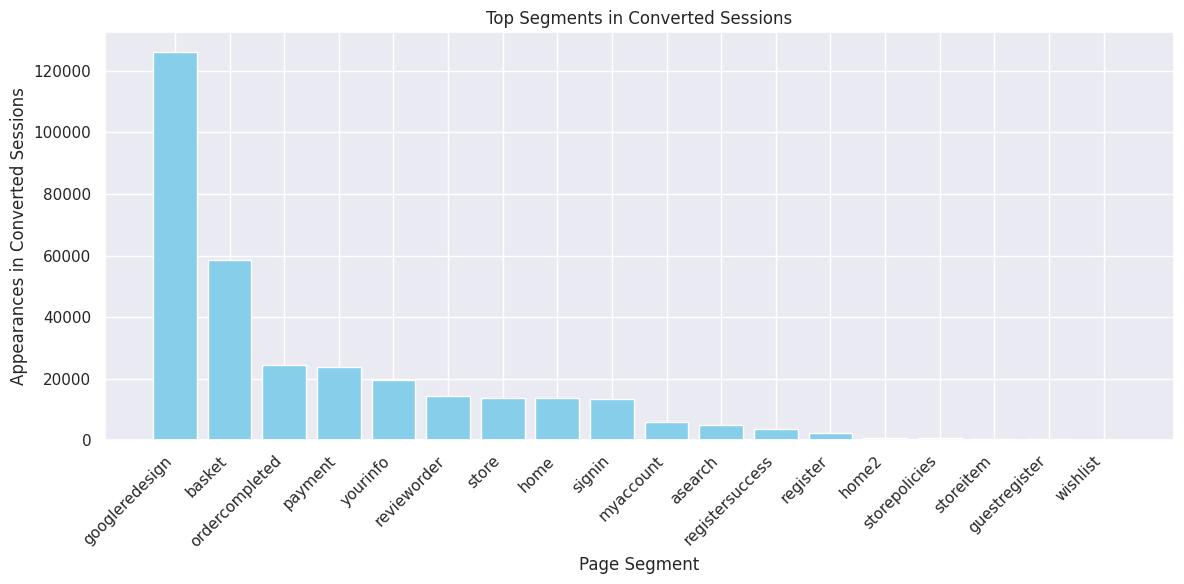

In [13]:
## 전환 세션에서 가장 많이 등장한 페이지 세그먼트
import matplotlib.pyplot as plt

top_segments = conversion_segments
plt.figure(figsize=(12, 6))
plt.bar(top_segments['segment'], top_segments['count'], color= 'skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top Segments in Converted Sessions')
plt.xlabel('Page Segment')
plt.ylabel('Appearances in Converted Sessions')
plt.tight_layout()
plt.show()

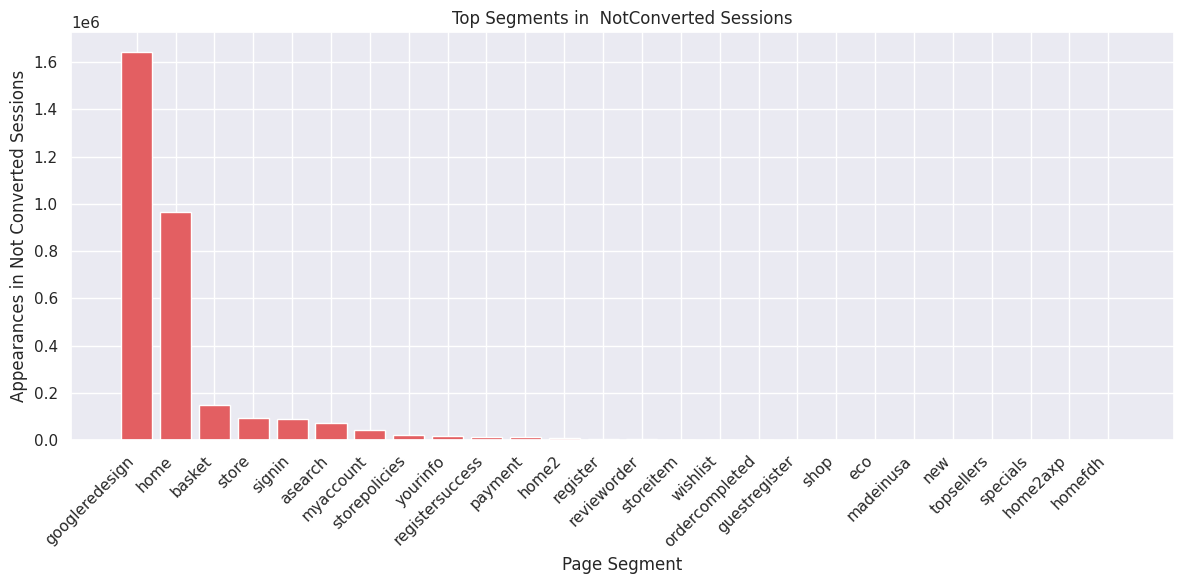

In [14]:
# 비전환 세션에서의 가장 많이 등장한 페이지 세그먼트
# 전환 여부에 따라 세션 분리
not_converted_df = Trans_Navi_page[Trans_Navi_page['converted'] == False]

# 전환되지 않은 세션에서 cleaned_segment 등장 빈도
not_conversion_segments = (
    not_converted_df['cleaned_segment']
    .value_counts()
    .reset_index()
    .rename(columns={'cleaned_segment': 'segment'})
)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(not_conversion_segments['segment'], not_conversion_segments['count'], color='#e35f62')
plt.xticks(rotation=45, ha='right')
plt.title('Top Segments in  NotConverted Sessions')
plt.xlabel('Page Segment')
plt.ylabel('Appearances in Not Converted Sessions')
plt.tight_layout()
plt.show()

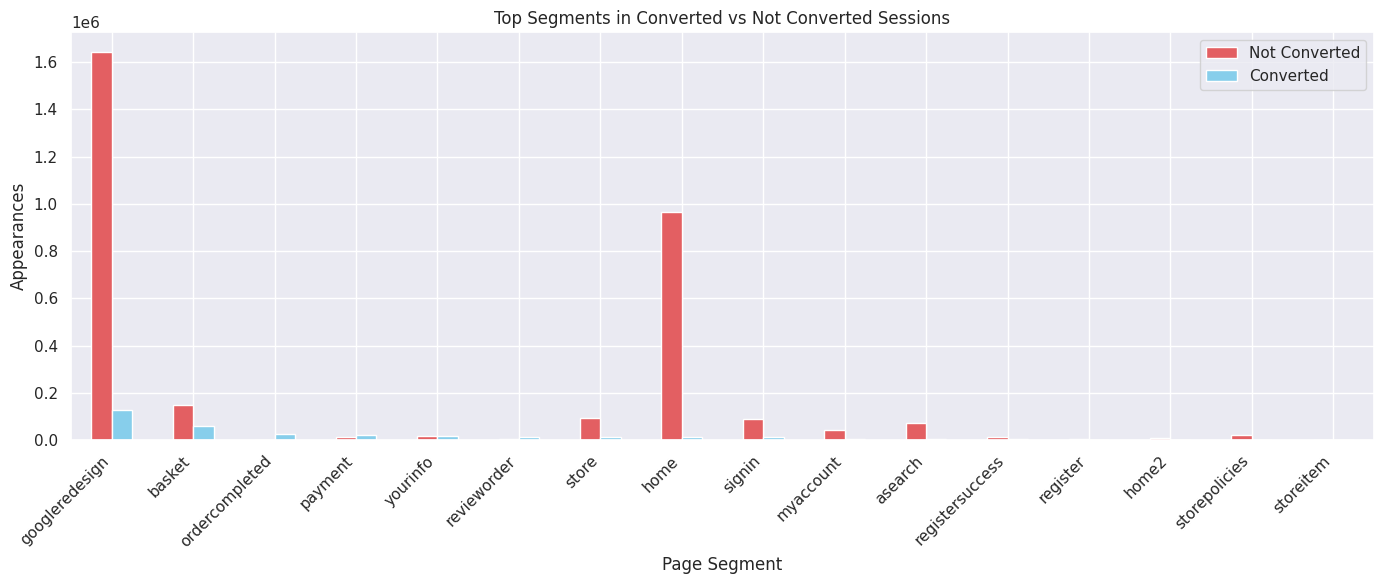

In [15]:
# 전환 vs 전환되지 않은 세션의 상위 15개 page와 비교

# 상위 15개 비교
top_conv = conversion_segments.set_index('segment').head(15)
top_not_conv = not_conversion_segments.set_index('segment').head(15)

# 공통 항목 기준 병합
comparison_df = top_conv.join(top_not_conv, lsuffix='_conv', rsuffix='_notconv', how='outer').fillna(0)

# 정렬
comparison_df = comparison_df.sort_values('count_conv', ascending=False)

# 시각화
import matplotlib.pyplot as plt

comparison_df[['count_notconv', 'count_conv']].plot(kind='bar', figsize=(14, 6), color=('#e35f62', 'skyblue'))
plt.title("Top Segments in Converted vs Not Converted Sessions")
plt.xlabel("Page Segment")
plt.ylabel("Appearances")
plt.xticks(rotation=45, ha='right')
plt.legend(["Not Converted", "Converted"])
plt.tight_layout()
plt.show()

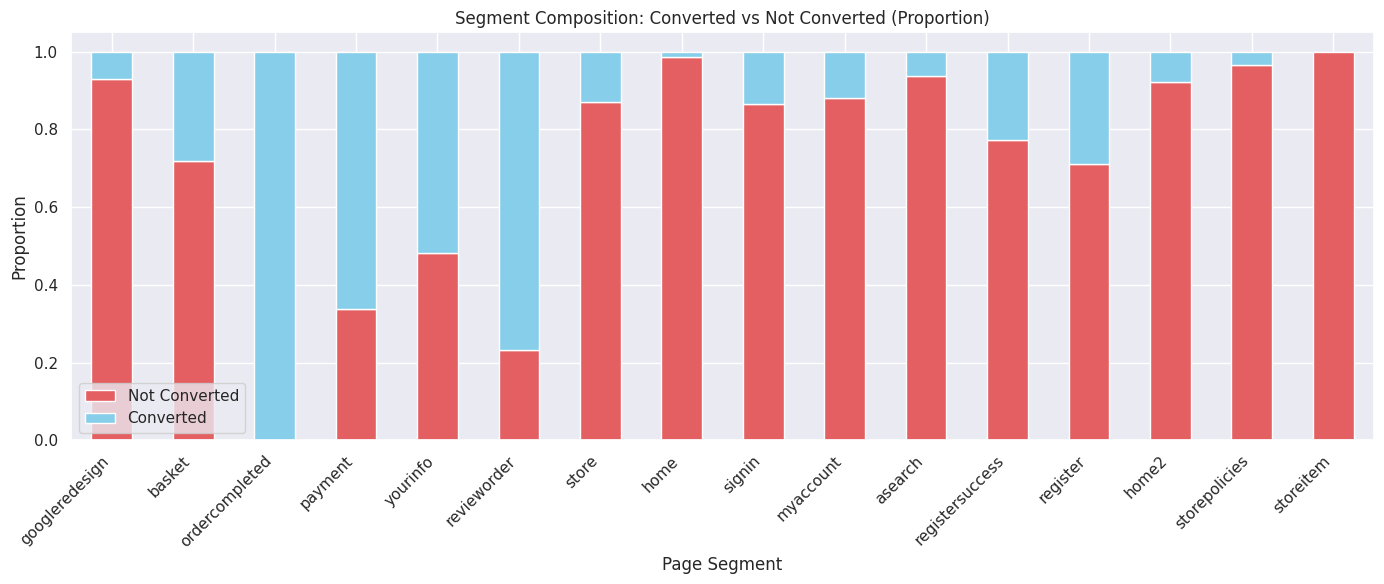

In [16]:
# 총합 기준으로 비율 계산
comparison_df['ratio_conv'] = comparison_df['count_conv'] / (comparison_df['count_conv'] + comparison_df['count_notconv'])
comparison_df['ratio_notconv'] = 1 - comparison_df['ratio_conv']

# 시각화
comparison_df[['ratio_notconv', 'ratio_conv']].plot(kind='bar', stacked=True, figsize=(14, 6), color=('#e35f62', 'skyblue'))
plt.title("Segment Composition: Converted vs Not Converted (Proportion)")
plt.xlabel("Page Segment")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.legend(["Not Converted", "Converted"])
plt.tight_layout()
plt.show()


In [17]:
comparison_df

,count_conv,count_notconv,ratio_conv,ratio_notconv
segment,,,,
googleredesign,126191.0,1643624.0,0.071302,0.928698
basket,58686.0,150738.0,0.280226,0.719774
ordercompleted,24507.0,0.0,1.000000,0.000000
payment,23675.0,12137.0,0.661091,0.338909
yourinfo,19463.0,18070.0,0.518557,0.481443
revieworder,14512.0,4419.0,0.766573,0.233427
store,13807.0,93635.0,0.128507,0.871493
home,13674.0,967625.0,0.013935,0.986065
signin,13506.0,87793.0,0.133328,0.866672



#### 전환 세션과 비전환 세션 비교
[결과 해석]
- googleredesign
  - 전환세션과 비전환세션 모두 압도적으로 많이 등장
  -  거의 모든 사용자가 이 경로를 통해 제품 탐색 : 메인 허브 역할
  - 중요도가 높으므로 이 page에서의 UX, CTA 최적화 중요
- basket, ordercompleted, payment, youinfo, revieworder
  - 전환 세션에서 급격히 높고, 비전환 세션에선 거의 없음
  - 실제 플로우 단계로 **전환 성공**의 직접적 증거임
  - 해당 세그먼트 방문 여부 자체가 전환 가능성을 의미하므로 이 단계로 연결되지 못한 사용자들의 유입 유도 필요
- home, store, signin
  - 전환/비전환 모두에 존재하나 비전환 쪽이 상대적으로 많음
  - 탐색 단계에서 전환으로 연결되지 않고 이탈한 사용자가 다수
  - 이 페이지들에는 전환 흐름을 유도하는 CTA or 추첮 상품 필요(지금 장바구니 담기, 오늘의 할인 상품 등)
- faq, storepolicies, wishlist
  - 정보성 페이지들로 정보 탐색만 하고 이탈하는 경향
  - 이 페이지들은 정보만 제공하고 유도력이 약하므로 다음 행동을 유도하는 디자인 개편 필요

  [최종 정리]
  - googleredesign 는 진입 허브이자 필수 경로로 중요도가 높으므로 이 page에서의 UX, CTA 최적화 중요
  - 전환 플로우는 매우 구조화 됨 :  basket → payment → yourinfo → revieworder → ordercompleted
  - 비전환 세션의 경우 googleredesign, home, basket, store, signin, asearch, myaccount으로 탐색 후 이탈하는 흐름이 뚜렷한 편


## 2-2. 전환 플로우 정형성 검증 및 basket 중심 접근

####  Conversion Lift
- 특정 페이지가 전환에 얼마나 긍정적인 영향을 미치는가?
- **Conversion Lift** = (Conversion Rate for segment) / (Global Conversion Rate)
 - Conversion Rate for segment: 측정 페이지 세그먼트에 등장한 세션 중 전환된 비율
 - Global Conversion Rate : 전체 세션 기준 평균 전환율

In [18]:
# 전체 전환율(Global Conversion Rate)
# 전체 전환 세션 수와 비전환 세션 수
total_conv = comparison_df['count_conv'].sum()
total_notconv = comparison_df['count_notconv'].sum()

# 전체 세션 수
total_sessions = total_conv + total_notconv

# 전체 전환률
global_conversion_rate = total_conv / total_sessions

In [19]:
# 세그먼트별 총 세션 수
comparison_df['total'] = comparison_df['count_conv'] + comparison_df['count_notconv']

# 세그먼트별 전환률
comparison_df['segment_conversion_rate'] = comparison_df['count_conv'] / comparison_df['total']

# Conversion Lift 계산
comparison_df['conversion_lift'] = comparison_df['segment_conversion_rate'] / global_conversion_rate

In [20]:
# Lift가 높은 순으로 보기
comparison_df_sorted = comparison_df.sort_values('conversion_lift', ascending=False).reset_index()

# 상위 확인
comparison_df_sorted[['segment', 'count_conv', 'count_notconv', 'segment_conversion_rate', 'conversion_lift']].head(10)

,segment,count_conv,count_notconv,segment_conversion_rate,conversion_lift
0,ordercompleted,24507.0,0.0,1.000000,10.632968
1,revieworder,14512.0,4419.0,0.766573,8.150950
2,payment,23675.0,12137.0,0.661091,7.029362
3,yourinfo,19463.0,18070.0,0.518557,5.513800
4,register,2462.0,6053.0,0.289137,3.074383
5,basket,58686.0,150738.0,0.280226,2.979632
6,registersuccess,3739.0,12700.0,0.227447,2.418436
7,signin,13506.0,87793.0,0.133328,1.417673
8,store,13807.0,93635.0,0.128507,1.366406
9,myaccount,6072.0,44948.0,0.119012,1.265452


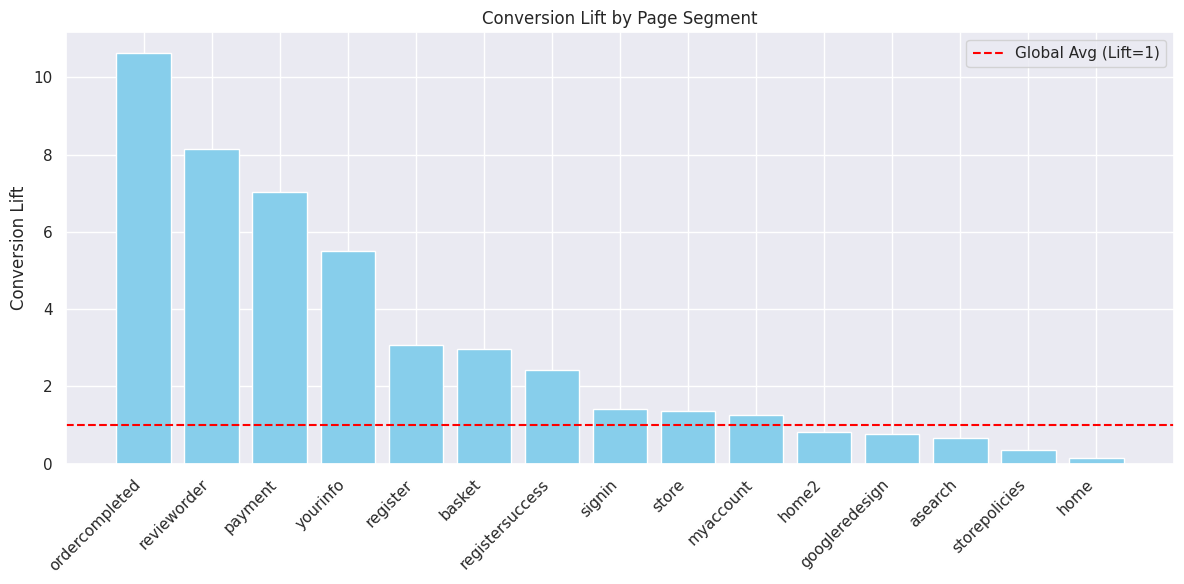

In [ ]:
## 페이지 별 Conversion Lift 시각화

top_lift = comparison_df_sorted[comparison_df_sorted['total'] > 1000].head(15)  # 등장 수 적은 페이지는 제외

plt.figure(figsize=(12,6))
plt.bar(top_lift['segment'], top_lift['conversion_lift'], color='skyblue')
plt.axhline(1, color='red', linestyle='--', label='Global Avg (Lift=1)')
plt.title('Conversion Lift by Page Segment')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Lift')
plt.legend()
plt.tight_layout()
plt.show()

#### 전환 플로우가 구조화 되어있는가?
> basket -> payment -> yourinfo -> revieworder -> ordercompleted

In [ ]:
# 순서 정렬
converted_sessions = converted_df.sort_values(by=['session_id', 'hit_num'])

# 각 세션의 cleaned_segment 시퀀스 추출
session_paths = converted_sessions.groupby('session_id')['cleaned_segment'].apply(list).reset_index(name='path')

# basket → payment → ordercompleted 이 포함된 세션 찾기
def contains_conversion_path(path):
    try:
        i1 = path.index('basket')
        i2 = path.index('payment')
        i3 = path.index('ordercompleted')
        return i1 < i2 < i3  # 순서를 지켜야 함
    except ValueError:
        return False

session_paths['has_conversion_flow'] = session_paths['path'].apply(contains_conversion_path)

# 몇 %의 전환세션이 이 흐름을 따르는가?
conversion_flow_ratio = session_paths['has_conversion_flow'].mean()
print(f"전환된 세션 중 {conversion_flow_ratio:.2%}가 명확한 구매 흐름을 따름.")


전환된 세션 중 99.36%가 명확한 구매 흐름을 따름.


In [ ]:
## 전환 상위 경로 패턴 집계
from collections import Counter

# 상위 경로 패턴 집계
common_flows = Counter(tuple(p[:5]) for p in session_paths['path']).most_common(10)
for flow, count in common_flows:
    print(f"{flow} → {count}회")

('home', 'googleredesign', 'googleredesign', 'googleredesign', 'googleredesign') → 1457회
('home', 'home', 'googleredesign', 'googleredesign', 'googleredesign') → 816회
('googleredesign', 'googleredesign', 'googleredesign', 'googleredesign', 'googleredesign') → 505회
('home', 'home', 'googleredesign', 'googleredesign', 'basket') → 473회
('home', 'googleredesign', 'googleredesign', 'googleredesign', 'basket') → 468회
('home', 'googleredesign', 'googleredesign', 'basket', 'googleredesign') → 378회
('home', 'googleredesign', 'googleredesign', 'basket', 'signin') → 235회
('home', 'googleredesign', 'googleredesign', 'basket', 'basket') → 157회
('googleredesign', 'googleredesign', 'googleredesign', 'googleredesign', 'basket') → 143회
('home', 'googleredesign', 'googleredesign', 'basket', 'store') → 117회


[ 전환 상위 경로 패턴 집계 결과 해석 ]

 >1: 탐색 중심 루프, 전환 흐름 진입 전 반복 탐색  
 2: 홈을 경유한 재탐색 흐름  
 3: 진입 후 여러 카테고리/상품 페이지 탐색  
 4-5: 구매 흐름 진입 시작점  
 6-10: 실제 구매 행동 전 회원 로그인, 상품 추가, 뒤로가기 탐색 등으로 다양화


In [ ]:
# 구매 흐름을 따르지 않은 흐름 살펴보기
# 구매 흐름 여부는 이미 계산되어 있음
# session_paths['has_conversion_flow'] == False 인 전환세션
nonstandard_flows = session_paths[session_paths['has_conversion_flow'] == False]

# 각 비표준 세션의 path를 상위 10개 패턴으로 정리
nonstandard_flow_patterns = Counter(tuple(path) for path in nonstandard_flows['path']).most_common(10)

for flow, count in nonstandard_flow_patterns:
    print(f"{' → '.join(flow)}   ({count}회)")

yourinfo → payment → revieworder → ordercompleted → ordercompleted   (6회)
payment → revieworder → ordercompleted → ordercompleted   (3회)
ordercompleted → ordercompleted   (3회)
home → revieworder → ordercompleted → ordercompleted   (2회)
signin → register → payment → revieworder → ordercompleted → ordercompleted   (2회)
payment → payment → revieworder → ordercompleted → ordercompleted   (2회)
home → yourinfo → payment → revieworder → ordercompleted → ordercompleted → googleredesign   (1회)
home → home → storepolicies → ordercompleted → ordercompleted   (1회)
payment → payment → revieworder → ordercompleted → ordercompleted → myaccount → googleredesign → googleredesign   (1회)
home → googleredesign → googleredesign → googleredesign → revieworder → ordercompleted → ordercompleted   (1회)


In [ ]:
###  basket 없이 거래가 발생한 상위 흐름 분석
# basket을 거친 세션
basket_sessions = Trans_Navi_page[Trans_Navi_page['cleaned_segment'] == 'basket']['session_id'].unique()

# basket 없이 거래된 세션 = 전환세션 ∩ basket 미포함
non_basket_converted_sessions = set(converted_sessions['session_id']) - set(basket_sessions)

print(f"총 전환 세션 수: {len(converted_sessions)}")
print(f"basket 포함된 전환 세션 수: {len(basket_sessions)}")
print(f"basket 없이 전환된 세션 수: {len(non_basket_converted_sessions)}")
print(f"비율: {len(non_basket_converted_sessions) / len(converted_sessions):.2%}")

# 해당 세션 전체 흐름 추출
df_non_basket_converted = Trans_Navi_page[Trans_Navi_page['session_id'].isin(non_basket_converted_sessions)].copy()

# 정렬
df_non_basket_converted = df_non_basket_converted.sort_values(by=['session_id', 'hit_num'])

# 세션별 path 추출
non_basket_paths = df_non_basket_converted.groupby('session_id')['cleaned_segment'].apply(list).reset_index(name='path')

# 상위 흐름 집계
from collections import Counter
top_flows = Counter(tuple(p[:7]) for p in non_basket_paths['path']).most_common(10)

print("basket 없이 거래가 발생한 상위 흐름:")
for flow, count in top_flows:
    print(f"{' → '.join(flow)}   ({count}회)")

총 전환 세션 수: 327560
basket 포함된 전환 세션 수: 71234
basket 없이 전환된 세션 수: 45
비율: 0.01%
basket 없이 거래가 발생한 상위 흐름:
yourinfo → payment → revieworder → ordercompleted → ordercompleted   (5회)
home → revieworder → ordercompleted → ordercompleted   (2회)
payment → revieworder → ordercompleted → ordercompleted   (2회)
signin → register → payment → revieworder → ordercompleted → ordercompleted   (2회)
home → yourinfo → payment → revieworder → ordercompleted → ordercompleted → googleredesign   (1회)
home → home → storepolicies → ordercompleted → ordercompleted   (1회)
home → googleredesign → googleredesign → googleredesign → payment → payment → revieworder   (1회)
home → googleredesign → googleredesign → googleredesign → revieworder → ordercompleted → ordercompleted   (1회)
home → googleredesign → revieworder → ordercompleted → ordercompleted   (1회)
storepolicies → ordercompleted → ordercompleted   (1회)


  [결과 해석]
 - 전체적으로 반복된 세션은 5회 이하로 소수
 - 장바구니 없이 나의 정보 등 회원 기반 정보를 통해 바로구매 가능
 - 딥링크, 마케팅 페이지 집입 가능성
 - ordercompleted 의 경우 두 번 반복되는 것으로 보아 트래킹 오류 또는 새로고침 발생 가능성

 => 장바구니 페이지 없이도 거래가 발생한 세션이 존재하나 이는 많지 않으므로, basket 진입을 구매 flow의 진입 여부로 보겠음.

# 3. 장바구니 중심 트리거 기반 사용자 행동 구조 분석

## 3-1. 장바구니 기준 전환 구조 비교

In [ ]:
## Trigger 기준 분석 : basket 진입 시점을 기준으로 before, after 행동 흐름 분석
# 전환된 세션 중에서 basket을 포함한 세션만 추출
basket_sessions = (
    Trans_Navi_page[(Trans_Navi_page['converted'] == True) & (Trans_Navi_page['cleaned_segment'] == 'basket')]
    [['session_id']]
    .drop_duplicates()
)

# 해당 세션들의 전체 기록 가져오기
df_basket_sessions = Trans_Navi_page[Trans_Navi_page['session_id'].isin(basket_sessions['session_id'])].copy()

# 정렬
df_basket_sessions = df_basket_sessions.sort_values(by=['session_id', 'hit_num'])


## 세션별로 basket 위치 기준으로 before / after 나누기

before_paths = []
after_paths = []

for session_id, group in df_basket_sessions.groupby('session_id'):
    path = list(group['cleaned_segment'])
    try:
        idx = path.index('basket')
        before_paths.append(path[:idx])      # basket 이전
        after_paths.append(path[idx+1:])     # basket 이후
    except ValueError:
        continue  # basket이 없는 예외 처리 (사실상 없어야 함)

## 자주 등장하는 before/after 페이지 경로 패턴
top_before = Counter(tuple(p) for p in before_paths if p).most_common(10)
top_after = Counter(tuple(p) for p in after_paths if p).most_common(10)

print("🟦 Top 10 Before Basket Paths:")
for path, count in top_before:
    print(f"{' → '.join(path)}   ({count}회)")

print("\n🟩 Top 10 After Basket Paths:")
for path, count in top_after:
    print(f"{' → '.join(path)}   ({count}회)")


🟦 Top 10 Before Basket Paths:
home → googleredesign → googleredesign   (1016회)
googleredesign   (631회)
googleredesign → googleredesign   (505회)
home → home → googleredesign → googleredesign   (474회)
home → googleredesign → googleredesign → googleredesign   (468회)
home → googleredesign   (307회)
googleredesign → googleredesign → googleredesign   (282회)
home → googleredesign → googleredesign → googleredesign → googleredesign   (260회)
home   (220회)
home → home → googleredesign → googleredesign → googleredesign   (211회)

🟩 Top 10 After Basket Paths:
yourinfo → payment → revieworder → ordercompleted → ordercompleted   (242회)
yourinfo → payment → payment → revieworder → ordercompleted → ordercompleted   (140회)
basket → yourinfo → payment → revieworder → ordercompleted → ordercompleted   (105회)
signin → yourinfo → payment → revieworder → ordercompleted → ordercompleted   (99회)
signin → registersuccess → store → basket → yourinfo → payment → revieworder → ordercompleted → ordercompleted   (91회)

In [ ]:
# 개별 페이지 기준의 before/after 빈도 분석
flat_before = [page for seq in before_paths for page in seq]
flat_after = [page for seq in after_paths for page in seq]

before_counts = Counter(flat_before)
after_counts = Counter(flat_after)

# 상위 10개만 출력
pd.DataFrame(before_counts.most_common(10), columns=['segment', 'count']).style.set_caption("Basket 이전 상위 페이지")

,segment,count
0,googleredesign,48604
1,home,11028
2,store,2946
3,asearch,1657
4,signin,1520
5,myaccount,904
6,home2,701
7,registersuccess,316
8,storepolicies,128
9,storeitem,121


In [ ]:
pd.DataFrame(after_counts.most_common(10), columns=['segment', 'count']).style.set_caption("Basket 이후 상위 페이지")

,segment,count
0,googleredesign,77869
1,basket,47268
2,ordercompleted,24389
3,payment,23587
4,yourinfo,19432
5,revieworder,14431
6,signin,11996
7,store,10882
8,myaccount,5150
9,registersuccess,3426


In [ ]:
# 전환된 세션 시각화
# 각 세션의 흐름에서 (A → B), (B → C) ... transition 추출
transitions = []

for path in session_paths['path']:
    for i in range(len(path) - 1):
        transitions.append((path[i], path[i+1]))

# 상위 20개 transition 추출
transition_counts = Counter(transitions).most_common(20)

# 데이터프레임으로 변환
trans_df = pd.DataFrame(transition_counts, columns=['pair', 'count'])
trans_df[['source', 'target']] = pd.DataFrame(trans_df['pair'].tolist(), index=trans_df.index)


import plotly.graph_objects as go

# 모든 unique 노드 추출
nodes = list(set(trans_df['source']).union(set(trans_df['target'])))
node_index = {node: i for i, node in enumerate(nodes)}

# source, target, value
source = trans_df['source'].map(node_index)
target = trans_df['target'].map(node_index)
value = trans_df['count']

# Sankey 그리기
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Converted Sessions: Page Flow (Sankey Diagram)", font_size=12)
fig.show()

- Top 50 transition

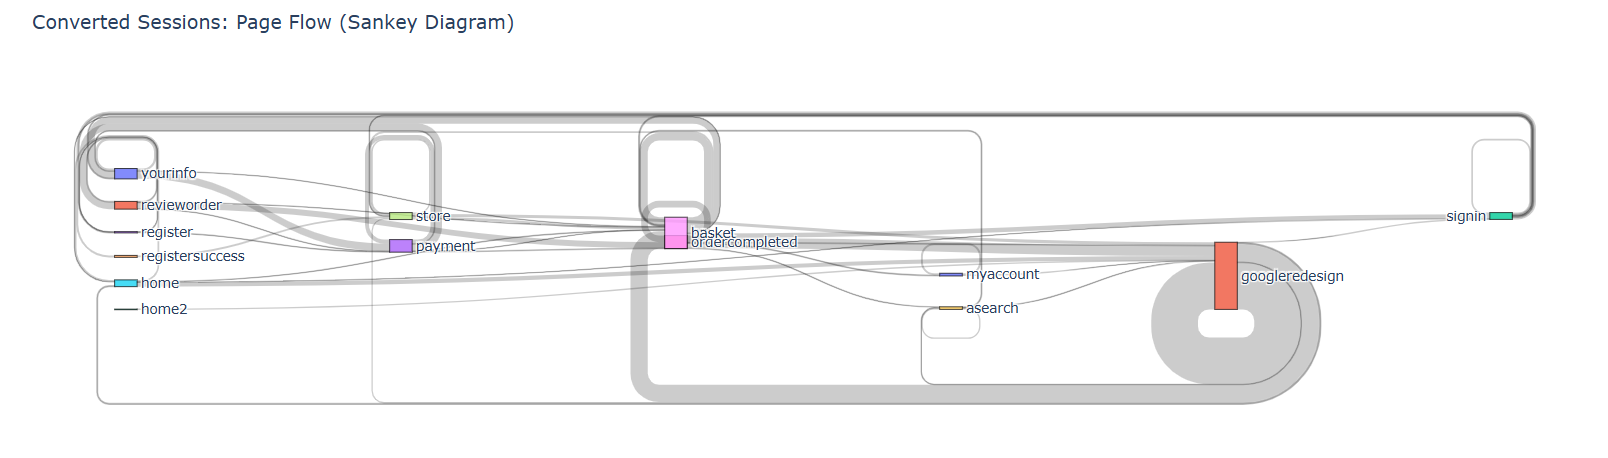

[결과 해석]
1. 시작 페이지:
-  home과 googleredesign에서 대부분 시작됨 → 두 페이지는 전환 여정의 시작점
2. 중간 흐름 :
-  googleredesign을 여러 번 거치는 흐름이 뚜렷함 -> 내부 탐색이 활발(카테고리 or 상세 페이지 반복 탐색)
- 이후 basket, yourinfo, payment 등의 구매 흐름으로 진입
3. 구매 플로우로의 진입 :
- basket → yourinfo → payment → ordercompleted → revieworder 흐름 존재
- 많은 세션이 탐색 단계에 머무르고, 일부만 전환 경로에 도달
4. 사이드 흐름
- signin, registersuccess, myaccount와 같은 흐름이 home 근처에서 갈라짐
- 이는 회원 기반 사용자의 전환 진입 흐름일 가능성이 높음


In [ ]:
# basket이 있는 session과 없는 session Sankey 데이터 시각화
import pandas as pd
import plotly.graph_objects as go

# 1. transition 추출 함수 (각 페이지 → 다음 페이지)
def get_transitions(df):
    df = df.sort_values(by=['session_id', 'hit_num'])
    df['next'] = df.groupby('session_id')['cleaned_segment'].shift(-1)
    df = df.dropna(subset=['next'])
    return df.groupby(['cleaned_segment', 'next']).size().reset_index(name='count')

# 2. Sankey 데이터 변환 함수
def format_sankey(trans, top_n=30):
    top = trans.sort_values('count', ascending=False).head(top_n)
    labels = list(pd.unique(top[['cleaned_segment', 'next']].values.ravel()))
    label_map = {label: i for i, label in enumerate(labels)}
    return {
        'label': labels,
        'source': top['cleaned_segment'].map(label_map),
        'target': top['next'].map(label_map),
        'value': top['count']
    }

# 3. Sankey 시각화 함수
def draw_sankey(data, title):
    fig = go.Figure(data=[go.Sankey(
        node=dict(label=data['label']),
        link=dict(source=data['source'], target=data['target'], value=data['value'])
    )])
    fig.update_layout(title_text=title, font_size=10)
    fig.show()


In [ ]:
# ① basket 포함 여부에 따라 세션 분리
sessions_with_basket = Trans_Navi_page[Trans_Navi_page['cleaned_segment'] == 'basket']['session_id'].unique()
df_basket = Trans_Navi_page[Trans_Navi_page['session_id'].isin(sessions_with_basket)]
df_no_basket = Trans_Navi_page[~Trans_Navi_page['session_id'].isin(sessions_with_basket)]

# ② 각 흐름 추출 및 시각화
for name, data in {'With Basket': df_basket, 'Without Basket': df_no_basket}.items():
    trans = get_transitions(data)
    sankey = format_sankey(trans, top_n=20)
    draw_sankey(sankey, f"Page Flow - {name}")


## 3-2. 장바구니 포함 여부 기반 전이&흐름 분석

In [ ]:
# basket 여부, basket 이전까지만 자르기
session_paths['has_basket'] = session_paths['path'].apply(lambda x: 'basket' in x)

def get_pre_basket(path):
    try:
        return path[:path.index('basket')]
    except ValueError:
        return path  # basket 없으면 전체 path 유지

session_paths['processed_path'] = session_paths['path'].apply(get_pre_basket)

In [ ]:
session_paths = (
    Trans_Navi_page.sort_values(by=['session_id', 'hit_num'])
    .groupby('session_id')['cleaned_segment']
    .apply(list)
    .reset_index(name='path')
)

# 2. basket 이전까지 path 자르기
session_paths['has_basket'] = session_paths['path'].apply(lambda x: 'basket' in x)

def cut_before_basket(path):
    try:
        return path[:path.index('basket')]
    except ValueError:
        return path

session_paths['processed_path'] = session_paths['path'].apply(cut_before_basket)

# 3. 전이쌍 추출
def extract_pairs(path):
    return [(path[i], path[i+1]) for i in range(len(path)-1)]

with_basket = session_paths[session_paths['has_basket']]
without_basket = session_paths[~session_paths['has_basket']]

with_pairs = with_basket['processed_path'].apply(extract_pairs).explode().dropna()
without_pairs = without_basket['processed_path'].apply(extract_pairs).explode().dropna()

# 4. 빈도 집계 및 병합
with_counts = Counter(with_pairs)
without_counts = Counter(without_pairs)

with_df = pd.DataFrame(with_counts.items(), columns=['pair', 'count_with'])
without_df = pd.DataFrame(without_counts.items(), columns=['pair', 'count_without'])

merged = pd.merge(with_df, without_df, on='pair', how='outer').fillna(0)
merged[['count_with', 'count_without']] = merged[['count_with', 'count_without']].astype(int)

In [ ]:
merged = merged[merged['count_with']+merged['count_without']>=100].copy()
merged

,pair,count_with,count_without
0,"(asearch, asearch)",4511,18849
2,"(asearch, googleredesign)",1854,14078
3,"(asearch, home)",258,3917
9,"(asearch, signin)",60,204
10,"(asearch, store)",16,175
...,...,...,...
209,"(storepolicies, signin)",82,324
212,"(storepolicies, storepolicies)",336,1995
220,"(wishlist, googleredesign)",110,240
222,"(wishlist, myaccount)",19,107


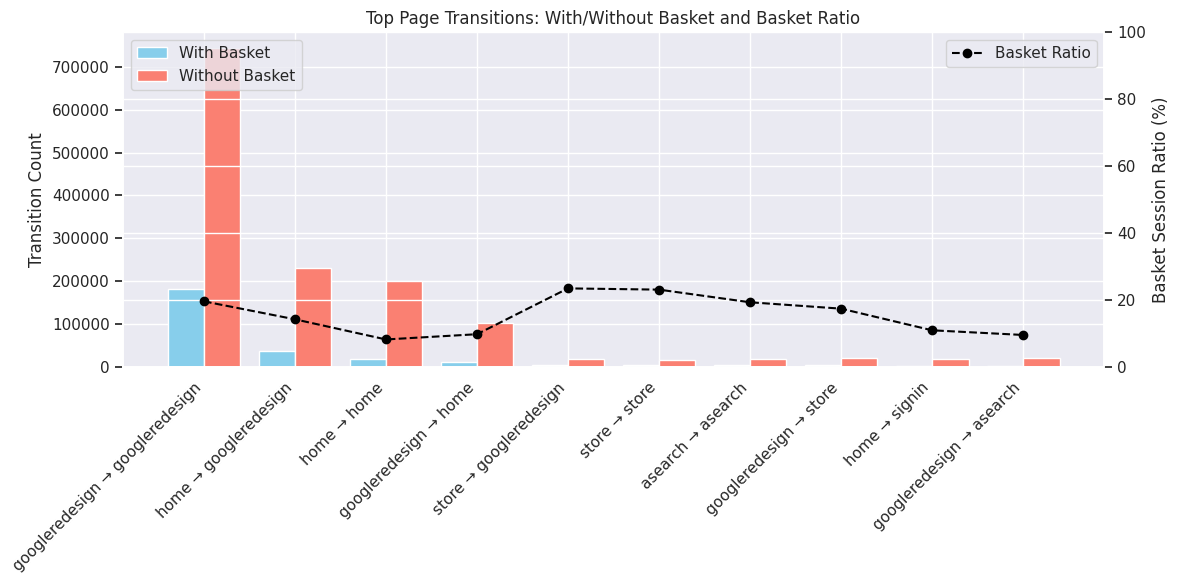

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# top 전이쌍 기준으로 비율 계산
top = merged.sort_values(by='count_with', ascending=False).head(10).copy()
top['total'] = top['count_with'] + top['count_without']
top['basket_ratio'] = top['count_with'] / top['total']

x_labels = [' → '.join(p) for p in top['pair']]
x = np.arange(len(x_labels))

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 전이쌍 빈도
ax1.bar(x - 0.2, top['count_with'], width=0.4, label='With Basket', color='skyblue')
ax1.bar(x + 0.2, top['count_without'], width=0.4, label='Without Basket', color='salmon')
ax1.set_ylabel('Transition Count')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right')
ax1.legend(loc='upper left')

# 꺾은선 그래프: basket 비율 (%)
ax2 = ax1.twinx()
ax2.plot(x, top['basket_ratio'] * 100, color='black', marker='o', linestyle='--', label='Basket Ratio')
ax2.set_ylabel('Basket Session Ratio (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')

plt.title('Top Page Transitions: With/Without Basket and Basket Ratio')
plt.tight_layout()
plt.show()


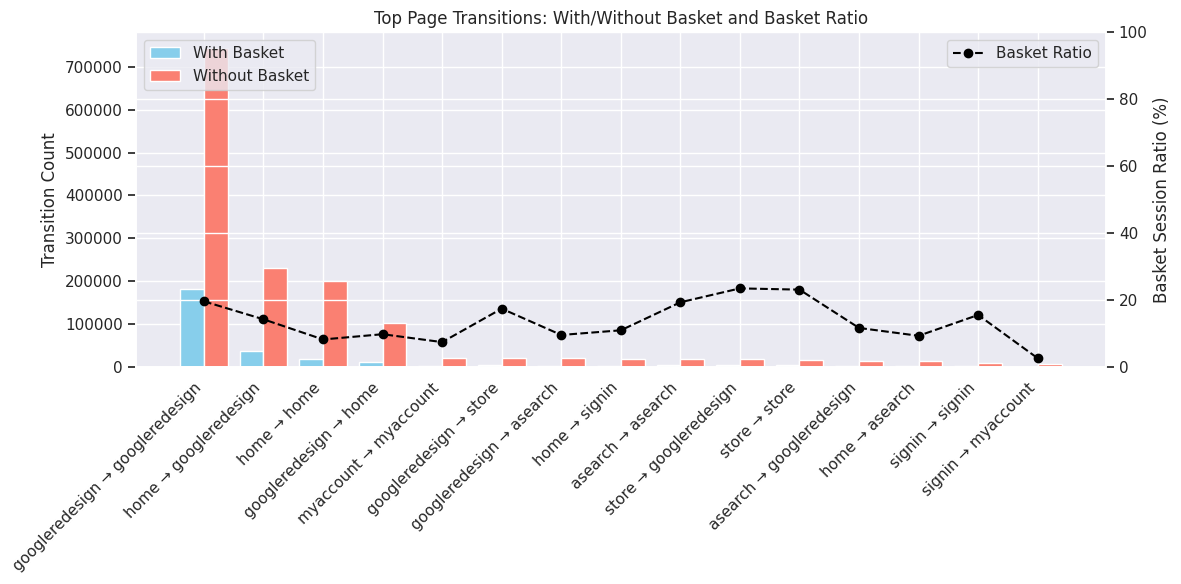

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# top 전이쌍 기준으로 비율 계산
top = merged.sort_values(by='count_without', ascending=False).head(15).copy()
top['total'] = top['count_with'] + top['count_without']
top['basket_ratio'] = top['count_with'] / top['total']

x_labels = [' → '.join(p) for p in top['pair']]
x = np.arange(len(x_labels))

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 전이쌍 빈도
ax1.bar(x - 0.2, top['count_with'], width=0.4, label='With Basket', color='skyblue')
ax1.bar(x + 0.2, top['count_without'], width=0.4, label='Without Basket', color='salmon')
ax1.set_ylabel('Transition Count')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right')
ax1.legend(loc='upper left')

# 꺾은선 그래프: basket 비율 (%)
ax2 = ax1.twinx()
ax2.plot(x, top['basket_ratio'] * 100, color='black', marker='o', linestyle='--', label='Basket Ratio')
ax2.set_ylabel('Basket Session Ratio (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')

plt.title('Top Page Transitions: With/Without Basket and Basket Ratio')
plt.tight_layout()
plt.show()


[결과 해석]
1. googleredesign → googleredesign
- 두 그룹 모두에서 가장 많이 등장한 전이쌍
- 전체적으로 빈도도 높고, basket 포함 비율이 중간으로 탐색 반복 패턴일 가능성 있음
2. store → googleredesign / store -> store / googleredesign → store
- 전체적으로 빈도가 높은 편은 아니지만, basket 포함 비율이 상대적으로 높음
- sotre 페이지는 구매로 이어질 가능성이 높은 허브 역할을 하는 경향이 있음
3. home -> home /home → signin/ googleredesign → aseach/ asearch → asearch
- 빈도는 있으나 대부분 basket과 무관한 흐름을 보여, 구매로 이어지지 않는 탐색 흐름으로 해석 가능


### Basket 포함 vs 미포함 Sankey Diagram

In [ ]:
# 사전정렬 (세션, hit 순서)
df_sorted = Trans_Navi_page.sort_values(by=['session_id', 'hit_num']).copy()

# 그룹 ID 부여
df_sorted['group_id'] = df_sorted['session_id'].ne(df_sorted['session_id'].shift()).cumsum()

# basket 위치 탐색용 플래그
df_sorted['is_basket'] = df_sorted['cleaned_segment'] == 'basket'

# basket 등장 위치 파악 (세션별 최초 등장 hit_num)
basket_hit_idx = (
    df_sorted[df_sorted['is_basket']]
    .groupby('session_id')['hit_num'].min()
    .reset_index()
    .rename(columns={'hit_num': 'basket_hit'})
)

# 세션별 basket 위치를 붙임
df_with_basket = df_sorted.merge(basket_hit_idx, on='session_id', how='left')

# 장바구니 도달 세션 : basket 이전만 남기기
df_before_basket = df_with_basket[
    df_with_basket['basket_hit'].notna() & (df_with_basket['hit_num'] < df_with_basket['basket_hit'])
]

# basket 없는 세션 추출(그대로 사용)
basket_sessions = set(basket_hit_idx['session_id'])
df_no_basket = df_sorted[~df_sorted['session_id'].isin(basket_sessions)]


In [ ]:
## 전이쌍 함수 정의

def get_transitions(df_segmented):
    df_segmented = df_segmented.sort_values(by=['session_id', 'hit_num'])
    df_segmented['next_segment'] = df_segmented.groupby('session_id')['cleaned_segment'].shift(-1)
    df_pairs = df_segmented.dropna(subset=['next_segment'])

    # transition 집계
    transition_counts = (
        df_pairs.groupby(['cleaned_segment', 'next_segment'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
    )
    return transition_counts

# 각 흐름의 transition 추출
trans_before_basket = get_transitions(df_before_basket)
trans_no_basket = get_transitions(df_no_basket)

In [ ]:
## Sankey 시각화 함수 정의

def format_for_sankey(trans_df, top_n=20):
    top = trans_df
    nodes = list(set(top['cleaned_segment']).union(set(top['next_segment'])))
    node_map = {name: idx for idx, name in enumerate(nodes)}

    sankey_dict = {
        'source': top['cleaned_segment'].map(node_map).tolist(),
        'target': top['next_segment'].map(node_map).tolist(),
        'value': top['count'].tolist(),
        'labels': nodes
    }
    return sankey_dict

In [ ]:
##  시각화

# 1. Sankey용 데이터 변환
sankey_before_basket = format_for_sankey(trans_before_basket)
sankey_no_basket = format_for_sankey(trans_no_basket)

# 2. Sankey 시각화 (basket 이전 흐름)
fig_before = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=sankey_before_basket['labels']
    ),
    link=dict(
        source=sankey_before_basket['source'],
        target=sankey_before_basket['target'],
        value=sankey_before_basket['value']
    )
)])
fig_before.update_layout(title_text="Sankey Diagram: Before Basket", font_size=10)
fig_before.show()

# 3. Sankey 시각화 (basket 없는 세션)
fig_no = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=sankey_no_basket['labels']
    ),
    link=dict(
        source=sankey_no_basket['source'],
        target=sankey_no_basket['target'],
        value=sankey_no_basket['value']
    )
)])
fig_no.update_layout(title_text="Sankey Diagram: No Basket Sessions", font_size=10)
fig_no.show()


In [ ]:
# 상위 30개 시각화 (약 count 500개 이상)

# 1. Sankey용 데이터 변환
sankey_before_basket = format_for_sankey(trans_before_basket.head(30))
sankey_no_basket = format_for_sankey(trans_no_basket.head(30))

# 2. Sankey 시각화 (basket 이전 흐름)
fig_before = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=sankey_before_basket['labels']
    ),
    link=dict(
        source=sankey_before_basket['source'],
        target=sankey_before_basket['target'],
        value=sankey_before_basket['value']
    )
)])
fig_before.update_layout(title_text="Sankey Diagram: Before Basket", font_size=10)
fig_before.show()

# 3. Sankey 시각화 (basket 없는 세션)
fig_no = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=sankey_no_basket['labels']
    ),
    link=dict(
        source=sankey_no_basket['source'],
        target=sankey_no_basket['target'],
        value=sankey_no_basket['value']
    )
)])
fig_no.update_layout(title_text="Sankey Diagram: No Basket Sessions", font_size=10)
fig_no.show()


[결과 해석]
- 공통 진입점(googleredesign)  
: 두 흐름 모두 googleredesign페이지가 중요한 역할을 하며, 가장 수요가 많음 : 해당 페이지가 메인 랜딩/ 탐색 허브 역할

#### 1. basket 포함 세션의 사전 흐름(Before Basket)
> - 사용자가 ggoogleredesign과home에서 반복적으로 순환하는 경향이 강함
>- 여러 페이지 (registersuccess, store, signin)에서 으로 이동 후 basket까지 도달하는 것으로 추정
>- 의도적인 탐색 후 장바구니에 담는 행동을 보여줌

#### 2. basket 없는 세션의 흐름(No Basket Sessions)
>- 마찬가지로 googleredesign, home 간의 순환은 있지만,
>- store, registersuccess, signin 등에서 종료되거나 되돌아가는 경로가 다수 발생
>- 구매 여정 중간까지 도달했지만 결정적인 전환 행동이 빠짐 : 탐색 -> 포기 흐름이 다수

# 5. 이탈률 높은 페이지 분석

## 5-0. 전처리

- 이탈 분석을 위한 테이블 생성
  - 장바구니(또는 카트) 페이지에 도달한 세션을 라벨링하는 CTE

In [ ]:
# 테이블 생성
query = """
  WITH basket_sessions AS (
    SELECT
      fullVisitorId,
      visitId,
      TRUE AS converted  -- 장바구니에 도달한 세션
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits
    WHERE
      _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
      AND hits.type = 'PAGE'
      AND hits.page.pagePath IS NOT NULL
      AND REGEXP_CONTAINS(hits.page.pagePath, r'cart|basket')
    GROUP BY
      fullVisitorId, visitId
  )

  SELECT
    CONCAT(s.fullVisitorId, '-', CAST(s.visitId AS STRING)) AS session_id,
    PARSE_DATE('%Y%m%d', s.date) AS visit_date,
    ARRAY_AGG(h.page.pagePath ORDER BY h.hitNumber) AS page_sequence,
    IFNULL(b.converted, FALSE) AS basket_converted,
    IF(SAFE_DIVIDE(IFNULL(s.totals.transactionRevenue, 0), 1e6) > 0, TRUE, FALSE) AS purchase_converted,
    SAFE_DIVIDE(IFNULL(s.totals.transactionRevenue, 0), 1e6) AS revenue
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS s,
    UNNEST(s.hits) AS h
  LEFT JOIN
    basket_sessions AS b
  ON
    s.fullVisitorId = b.fullVisitorId AND s.visitId = b.visitId
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND h.type = 'PAGE'
    AND h.page.pagePath IS NOT NULL
  GROUP BY
    s.fullVisitorId, s.visitId, s.date, b.converted, s.totals.transactionRevenue
"""


# 데이터프레임 생성
df = client.query(query).to_dataframe()

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
## 라이브러리 로드

# BigQuery
from google.cloud import bigquery

# viz libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [ ]:
df.head(3)

,session_id,visit_date,page_sequence,basket_converted,purchase_converted,revenue
0,8749275960710939040-1496586282,2017-06-04,"[/home, /home]",False,False,0.0
1,6538814646304634851-1496625415,2017-06-04,"[/home, /home]",False,False,0.0
2,2618437252183021907-1496604647,2017-06-04,"[/home, /home]",False,False,0.0


In [ ]:
import re

# 1. 단일 경로 정제 함수
def clean_page_path(path):
    match = re.match(r'^/([^/?]+)', path)
    if not match:
        return 'unknown'
    segment = match.group(1)
    cleaned = re.sub(r'\.html?|\.axd|\.htm', '', segment)
    cleaned = re.sub(r'[^\w]', '', cleaned)
    cleaned = cleaned.replace('_', '')
    return cleaned.lower()

In [ ]:
# 2. 세션별 전체 경로(path_array)에 적용
df['clean_path_array'] = df['page_sequence'].apply(
    lambda paths: [clean_page_path(p) for p in paths]
)

In [ ]:
df['clean_path_array']

,clean_path_array
0,"[home, googleredesign, asearch, asearch, asear..."
1,"[googleredesign, googleredesign]"
2,"[home, googleredesign]"
3,"[googleredesign, googleredesign]"
4,"[home, home, googleredesign]"
...,...
903548,"[home, home, googleredesign, googleredesign, g..."
903549,"[home, home, googleredesign, home, home, home,..."
903550,"[googleredesign, googleredesign, googleredesig..."
903551,"[home, googleredesign, googleredesign, googler..."


## 5-1. 상위 이탈 페이지 분석

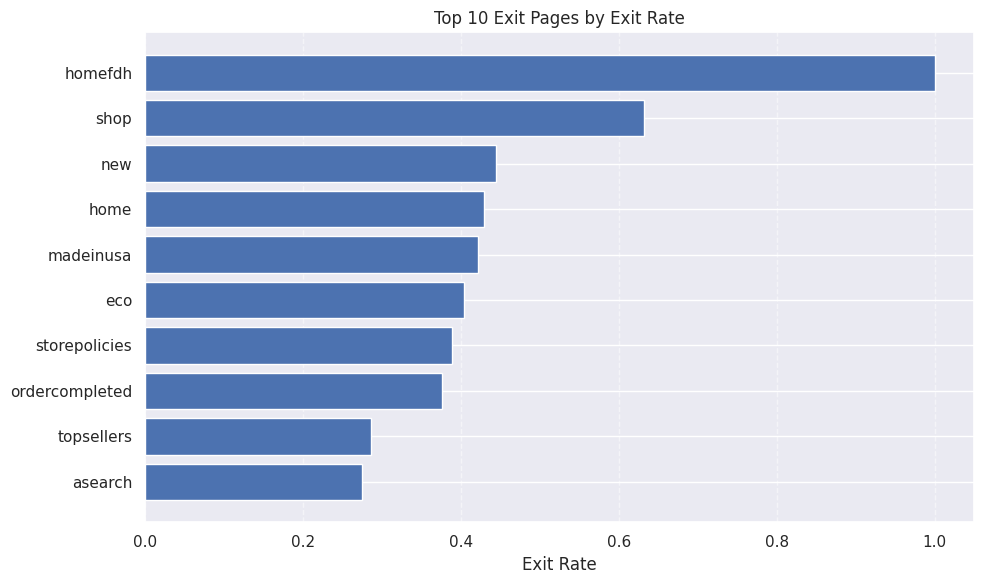

In [ ]:
## Top 상위 이탈 페이지 시각화(이탈율 기준)
# 이탈 페이지 추출 및 집계
df['last_page'] = df['clean_path_array'].apply(lambda x: x[-1] if x else None)
exit_counts = df['last_page'].value_counts().reset_index()
exit_counts.columns = ['page', 'exit_count']

# 이탈률 계산
from collections import Counter
from itertools import chain

# 모든 페이지가 포함된 총 등장 횟수 계산
all_pages = list(chain.from_iterable(df['clean_path_array']))
page_counts = pd.DataFrame(Counter(all_pages).items(), columns=['page', 'total_appearances'])

# 병합하여 이탈률 계산
exit_merged = pd.merge(exit_counts, page_counts, on='page')
exit_merged['exit_rate'] = exit_merged['exit_count'] / exit_merged['total_appearances']
exit_merged = exit_merged.sort_values(by='exit_rate', ascending=False)

# 시각화
# 상위 10개 이탈 페이지 시각화
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(exit_merged['page'][:top_n][::-1], exit_merged['exit_rate'][:top_n][::-1])
plt.xlabel("Exit Rate")
plt.title("Top 10 Exit Pages by Exit Rate")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

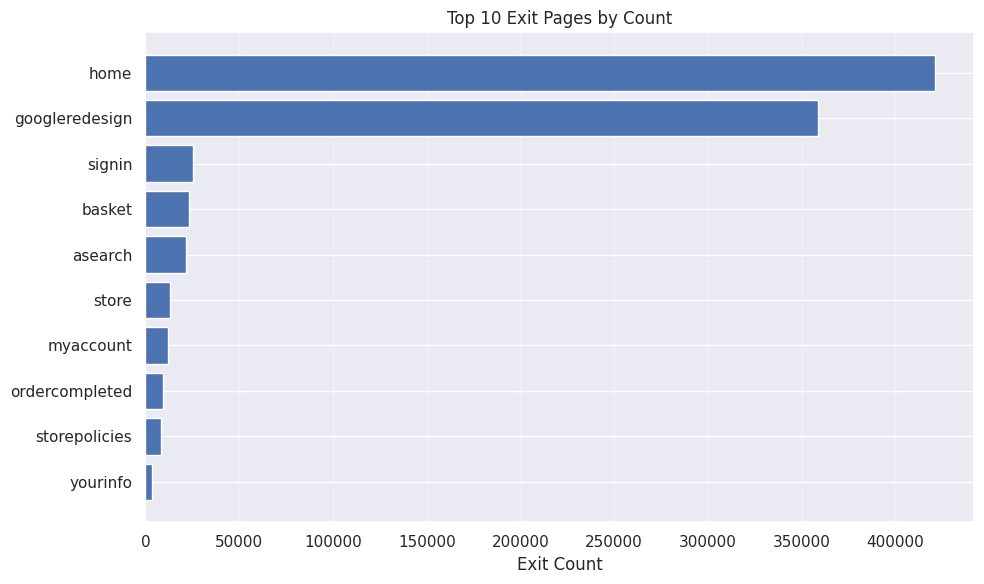

In [ ]:
# 이탈 수 기준
plt.figure(figsize=(10, 6))
plt.barh(exit_counts['page'][:top_n][::-1], exit_counts['exit_count'][:top_n][::-1])
plt.xlabel("Exit Count")
plt.title("Top 10 Exit Pages by Count")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[결과 해석]
- topsellers, madeinusa, new, specials,	homefdh,	home2axp의 경로의 경우 10개 미만의 수로 거의 무시 가능
- /homefdh > /shop > /new, /home, /eco, /madeinusa 순으로 이탈률이 높은 page


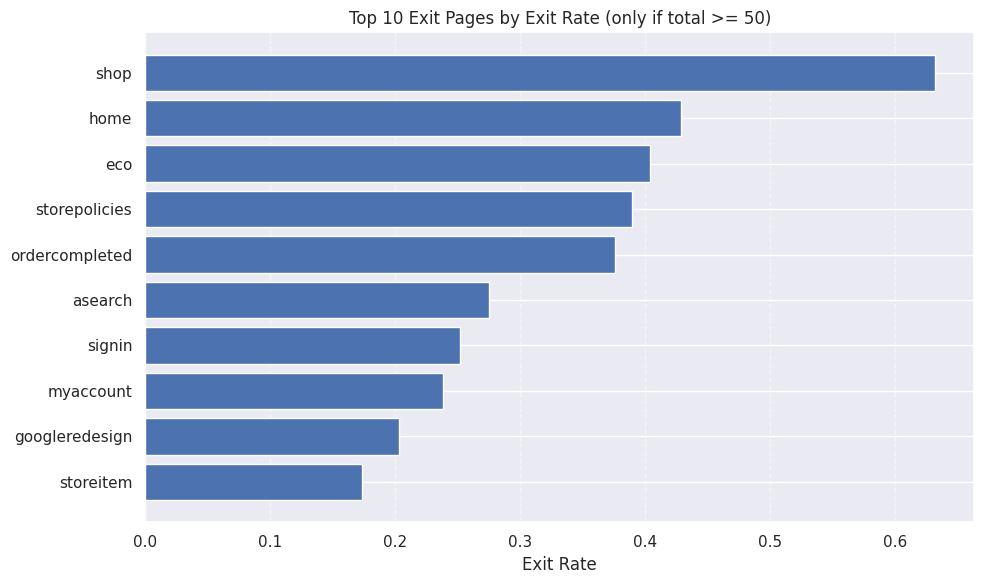

In [ ]:
## 페이지별 Top 상위 이탈율(50개 이상인 페이지)
# 전체 등장 수가 50개 이상인 페이지만 분석
from collections import Counter
from itertools import chain

# 병합 후 이탈률 계산
exit_merged = pd.merge(exit_counts, page_counts, on='page')

# 조건: 10개 미만 등장한 페이지 제거
exit_merged = exit_merged[exit_merged['total_appearances'] >= 50]  # 50개 이상 등장한 페이지만 사용

# 이탈률 계산
exit_merged['exit_rate'] = exit_merged['exit_count'] / exit_merged['total_appearances']
exit_merged = exit_merged.sort_values(by='exit_rate', ascending=False)

# 상위 10개만 시각화
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(exit_merged['page'][:top_n][::-1], exit_merged['exit_rate'][:top_n][::-1])
plt.xlabel("Exit Rate")
plt.title("Top 10 Exit Pages by Exit Rate (only if total >= 50)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[결과 해석]
1. /shop(>0.6)  
  : 제품 탐색 페이지에서 다음 행동으로 이어지지 않고 이탈하는 비율 높음   
  -> 상품 상세 유도 부족, 필터링 UX 문제 등 의심
2. /home (>0.4)  
  : 홈에서 바로 이탈하는 경우  
  -> 비효율적 유입, 콘텐츠 흡입력 부족, 느릭 로딩 속도 가능성
3. /eco, /storepolicies (=0.4)  
  : 정보성 컨텐츠에서 벗어나지 않고 종료됨
4. /ordercompleted(=0.4)  
  : 주문 완료 후 이탈함을 의미
5. /asearch(=0.3)  
  : 검색 후 아무런 행동 없이 나감  
  -> 검색결과 품질 또는 검색 UX 개선 필요성 시사
6. /signin, /myaccount, /googleredesign  
  : 로그인 및 계정 관련 페이지에서 이탈
  -> 로그인 실패, 비회원 진입 장벽, UI 혼란 가능성
7.  /storeitem  
  : 상품 개별 상세로 추정되는 페이지에서도 이탈  
  → 상품 정보 부족 또는 구매 유도 부족

[ 개선 제안 ]
- home, googleredesign  
: 첫 화면으로 가장 중요하며, 로드 시간, Hero Image/CTA 배치 최적화
- shop, asearch  
: 추천상품 / 인기순 정렬 / CTA 강조 등으로 클릭률 유도
- signin, myaccount  
: 로그인 장벽 완화: 소셜 로그인 도입, 실패 시 UX 메시지 강화
- storepolicies, eco  
: 정보 콘텐츠에도 구매로 이어지는 링크 추가

## 5-2. 장바구니 도달/미도달/전환 여부 별 이탈 페이지 분석


In [ ]:
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

def compute_exit_rate(df_subset):
    df_subset['exit_page'] = df_subset['clean_path_array'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)

    all_pages = list(chain.from_iterable(df_subset['clean_path_array']))
    page_counts = pd.DataFrame(Counter(all_pages).items(), columns=['page', 'total_appearances'])

    exit_counts = df_subset['exit_page'].value_counts().reset_index()
    exit_counts.columns = ['page', 'exit_count']

    merged = pd.merge(exit_counts, page_counts, on='page')

    # 50개 이상 등장한 페이지만 분석
    merged = merged[merged['total_appearances'] >= 50]

    merged['exit_rate'] = merged['exit_count'] / merged['total_appearances']
    return merged.sort_values(by='exit_rate', ascending=False)

# 분리
basket_df = df[df['basket_converted'] == True].copy()
non_basket_df = df[df['basket_converted'] == False].copy()

# 각각 이탈률 계산
basket_exit = compute_exit_rate(basket_df)
non_basket_exit = compute_exit_rate(non_basket_df)

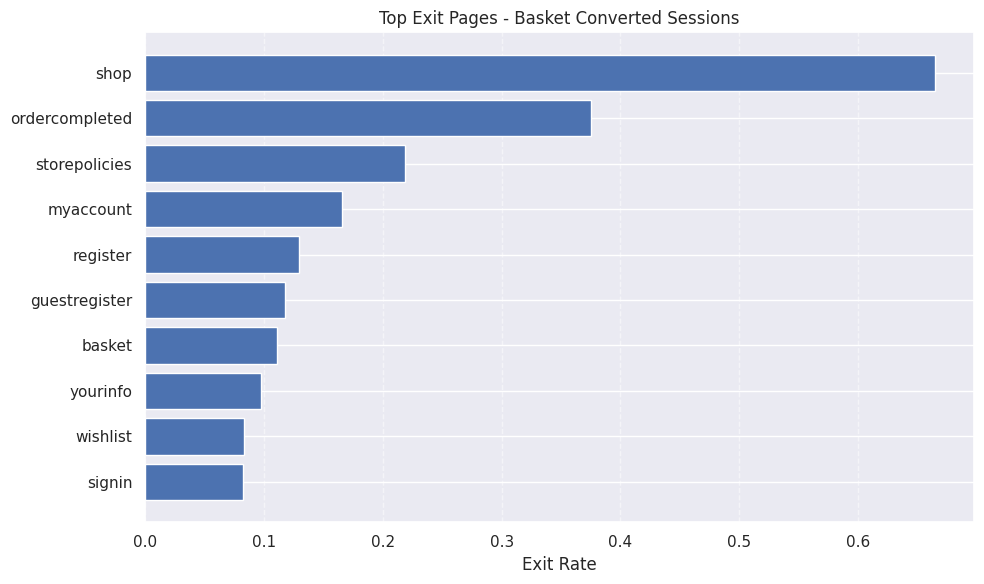

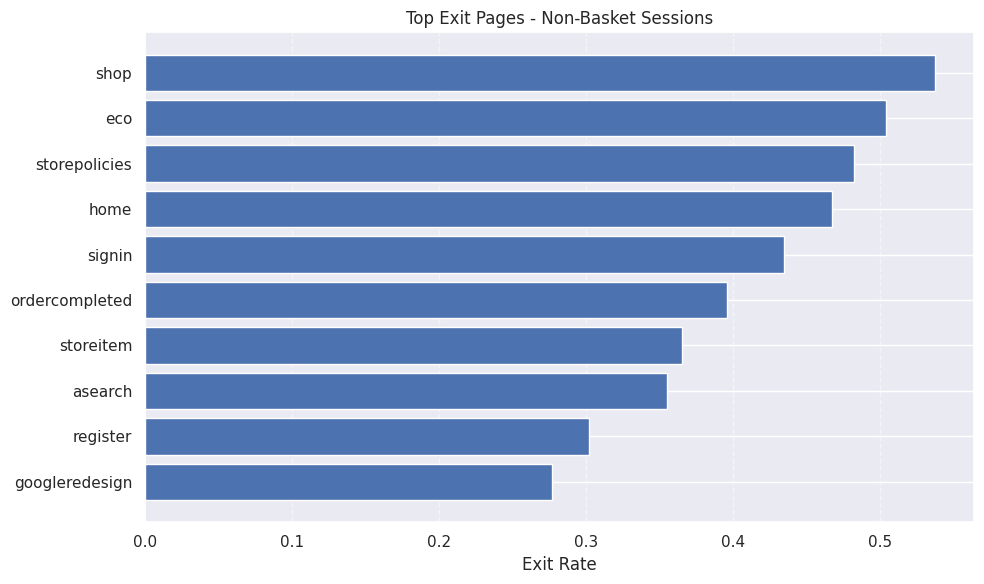

In [ ]:
# 장바구니 도달 세션 이탈률 상위 10
plt.figure(figsize=(10, 6))
plt.barh(basket_exit['page'][:10][::-1], basket_exit['exit_rate'][:10][::-1])
plt.xlabel("Exit Rate")
plt.title("Top Exit Pages - Basket Converted Sessions")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 장바구니 미도달 세션 이탈률 상위 10
plt.figure(figsize=(10, 6))
plt.barh(non_basket_exit['page'][:10][::-1], non_basket_exit['exit_rate'][:10][::-1])
plt.xlabel("Exit Rate")
plt.title("Top Exit Pages - Non-Basket Sessions")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 두 그룹(장바구니 도달/미도달) 간 공통 이탈 페이지 비교
common_pages = set(basket_exit['page']).intersection(set(non_basket_exit['page']))
basket_common = basket_exit[basket_exit['page'].isin(common_pages)][['page', 'exit_rate']]
non_basket_common = non_basket_exit[non_basket_exit['page'].isin(common_pages)][['page', 'exit_rate']]

compare_df = pd.merge(basket_common, non_basket_common, on='page', suffixes=('_basket', '_nonbasket'))
compare_df['exit_rate_diff'] = compare_df['exit_rate_nonbasket'] - compare_df['exit_rate_basket']
compare_df = compare_df.sort_values(by='exit_rate_diff', ascending=False)

In [ ]:
compare_df

,page,exit_rate_basket,exit_rate_nonbasket,exit_rate_diff
10,home,0.040347,0.467327,0.426980
6,signin,0.082186,0.434374,0.352188
12,storeitem,0.029968,0.365079,0.335111
9,asearch,0.040634,0.354930,0.314296
2,storepolicies,0.218238,0.482309,0.264071
13,googleredesign,0.028077,0.276901,0.248824
4,register,0.129192,0.301643,0.172451
15,home2,0.008681,0.165412,0.156730
8,store,0.045768,0.195821,0.150053
3,myaccount,0.165758,0.273585,0.107827


[결과 해석]
### 장바구니 미도달 세션에서 이탈률이 높은 페이지
1. /home : 방문 후 즉시 이탈 -> 진입 콘텐츠 부족 or 잘못된 유입 채널
2. /signin : 로그인 장벽 -> 비회원은 진입이 어려운 구조일 가능성
3. /storeitem : 제품 상세 페이지에서 이탈 -> 정보 부족 or CTA 부족
4. /asearch : 검색 결과 페이지 품질 낮거나, UX 불편
5. /storeplicies : 정책 페이지 진입 후 행도 없음
6. /googleredesign : 제품을 살펴보는 페이지 또한 이탈률이 높은 편

### 장바구니 도달 세션에서 이탈률이 높은 페이지
1. / shop : 상품 탐색 후 다음 액션을 못하는 구조
2. /ordercompleted : 구매 흐름 완료 후 이탈한 것으로 확인

### 시사점
1. 장바구니 미도달 세션의 경우 home에서 바로 이탈하는 사람이 많은 것을 보아, 콘텐츠 밀도 강화로 잘못된 유입 트래픽을 차단하는 것이 필요해 보임
2. 또한, 도달 세션과 다르게

In [ ]:
## 페이지별 장바구니 도달/미도달 분포와 이탈율 누적 막대 그래프
def plot_stacked_exit(data, title):
    pages = data['page']
    exits = data['exit_count']
    non_exits = data['total_appearances'] - data['exit_count']

    plt.figure(figsize=(12, 6))
    bar1 = plt.barh(pages, non_exits, label='Non-Exits', color='lightgray')
    bar2 = plt.barh(pages, exits, left=non_exits, label='Exits', color='steelblue')

    for i in range(len(pages)):
        total = data.iloc[i]['total_appearances']
        rate = data.iloc[i]['exit_rate']
        plt.text(total + 5, i, f"{rate:.0%}", va='center', fontsize=9)

    plt.xlabel("Total Appearances")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

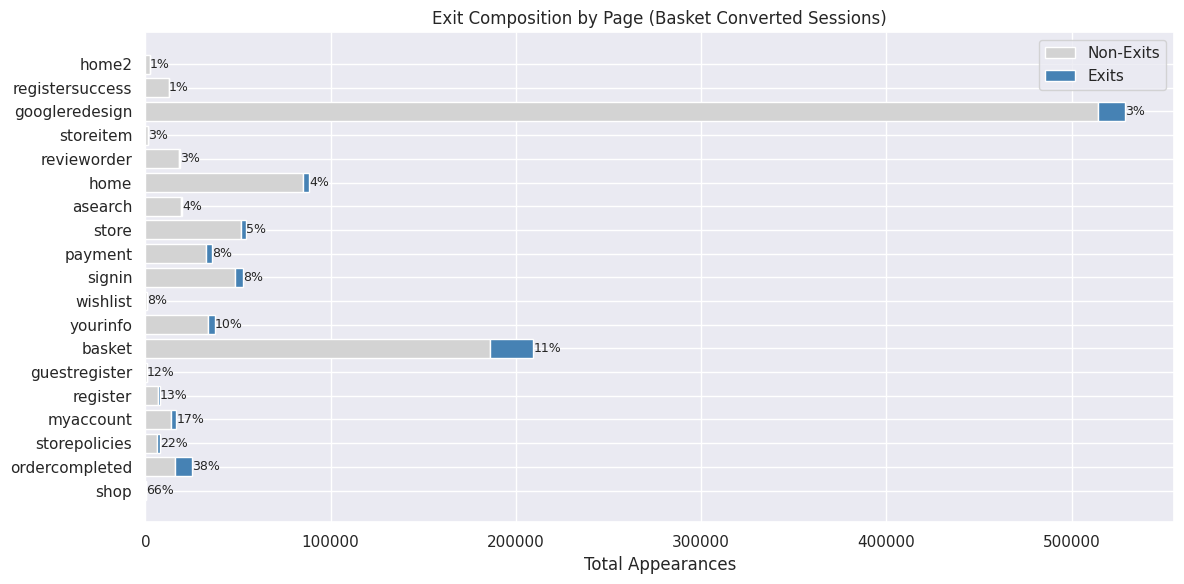

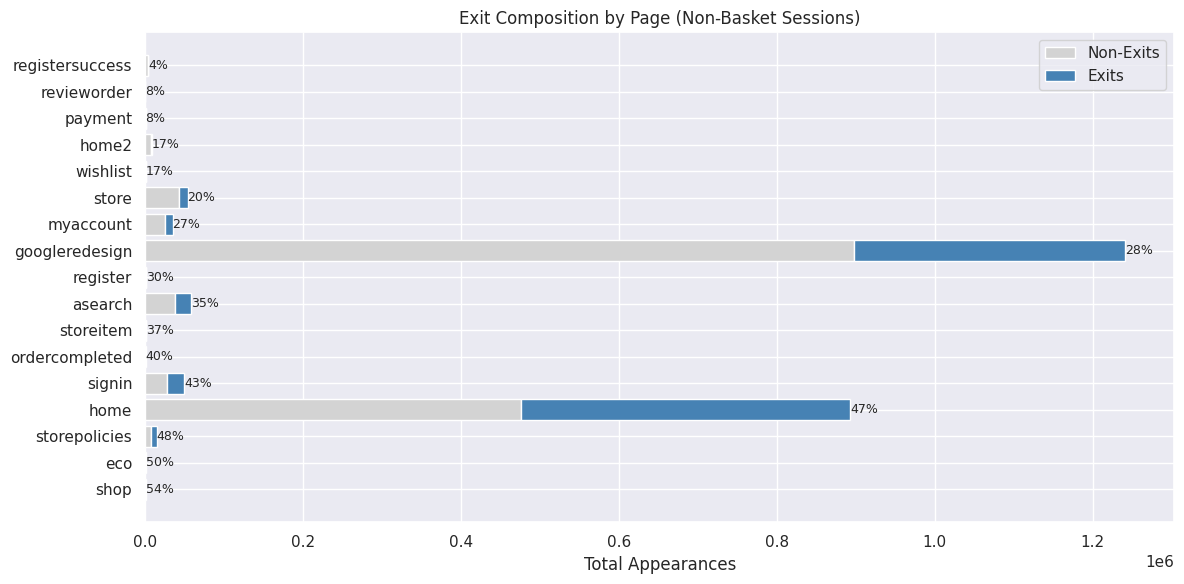

In [ ]:
plot_stacked_exit(basket_exit, "Exit Composition by Page (Basket Converted Sessions)")
plot_stacked_exit(non_basket_exit, "Exit Composition by Page (Non-Basket Sessions)")

[ 결과 해석 ]
#### 장바구니 미도달 세션의 경우
- `/home `은 경우 거의 미반환 세션에서 이탈이 이루어 지고 있음을 확인  
  -> 진입 콘텐츠 부족 or 잘못된 유입 채널
- 도달 세션에 비해 `/googleredesign` 상품페이지에서의 이탈을 하는 경우가 아주 많음 : 상품에 관심은 있어 들어왔지만 의미 있는 행동을 하지 않음  
  -> 상품이 마음에 들지 않거나, 결정적인 정보가 없는 경우 등  
  -> 상품 페이지 내 유사 상품 추천을 통해 더 많은 탐색을 유도/ 비회원도 바구니 담기 허용 / 이런 사람이 많이 샀다는 소셜 증거 표시 / 가격 비교, 리뷰, 재공 정보 강조 등
- 구매할 목적이 아닌 정보성 페이지(`/eco, /storepolicies`)를 볼 목적으로 사이트를 방문한 경우


=> 탐색만 하다가 나가는 고객  
=> 상품 상세까지 보더라고 장바구니 담을 정도의 의도나 확신이 없던 고객  
=> 회원가입/ 로그인 등 가입 프로세스에서 막힌 고객  
=> 정보성 페이지만을 목적으로 들어온 고객

#### 장바구니 전환 세션 중 구매까지 이어진 경우
- 장바구니 도달 세션 중
  - 매출 전환 고객(purchase_df) : 구매까지 이어진 세션
  - 매출 미전환 고객(abandoned_df) : 장바구니까지만 간 세션


In [ ]:
# 장바구니 도달 세션 중에서
basket_df = df[df['basket_converted'] == True].copy()

# 구매까지 이어진 세션 (전환 완료)
purchase_df = basket_df[basket_df['revenue'] > 0].copy()

# 장바구니까지만 간 세션 (결제 X)
abandoned_df = basket_df[basket_df['revenue'] == 0].copy()

In [ ]:
def compute_exit_stacked(df_subset, top_n=10):
    from collections import Counter
    from itertools import chain

    df_subset['exit_page'] = df_subset['clean_path_array'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)

    all_pages = list(chain.from_iterable(df_subset['clean_path_array']))
    page_counts = pd.DataFrame(Counter(all_pages).items(), columns=['page', 'total_appearances'])

    exit_counts = df_subset['exit_page'].value_counts().reset_index()
    exit_counts.columns = ['page', 'exit_count']

    merged = pd.merge(exit_counts, page_counts, on='page')
    merged['exit_rate'] = merged['exit_count'] / merged['total_appearances']

    # 10회 미만 등장한 페이지 제외
    merged = merged[merged['total_appearances'] >= 50]

    return merged.sort_values(by='total_appearances', ascending=False).head(top_n)

purchase_exit = compute_exit_stacked(purchase_df, top_n=15)
abandoned_exit = compute_exit_stacked(abandoned_df, top_n=15)

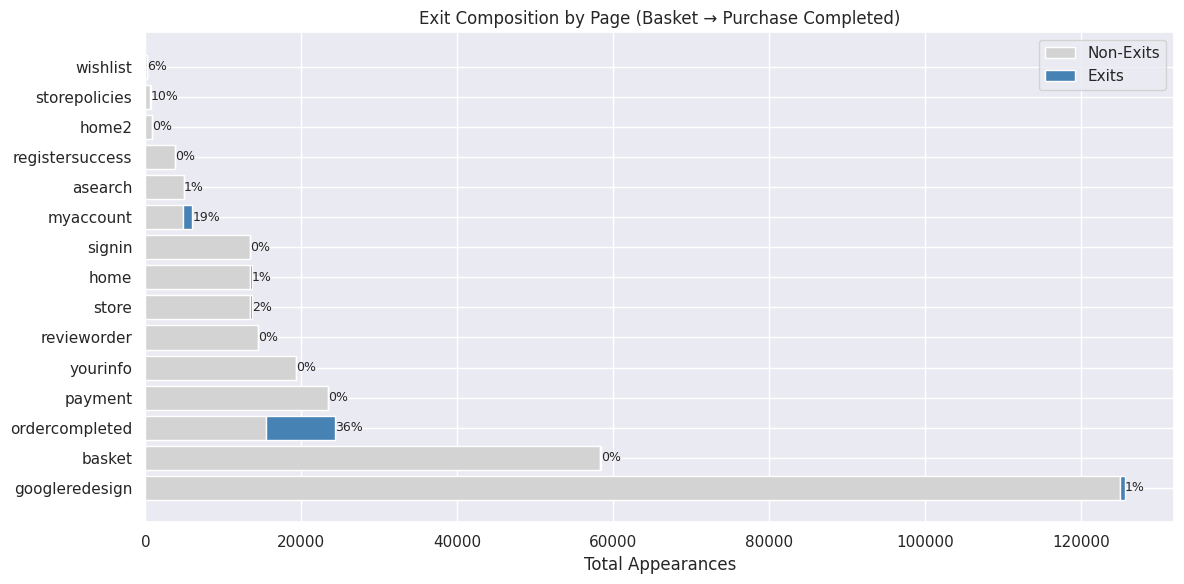

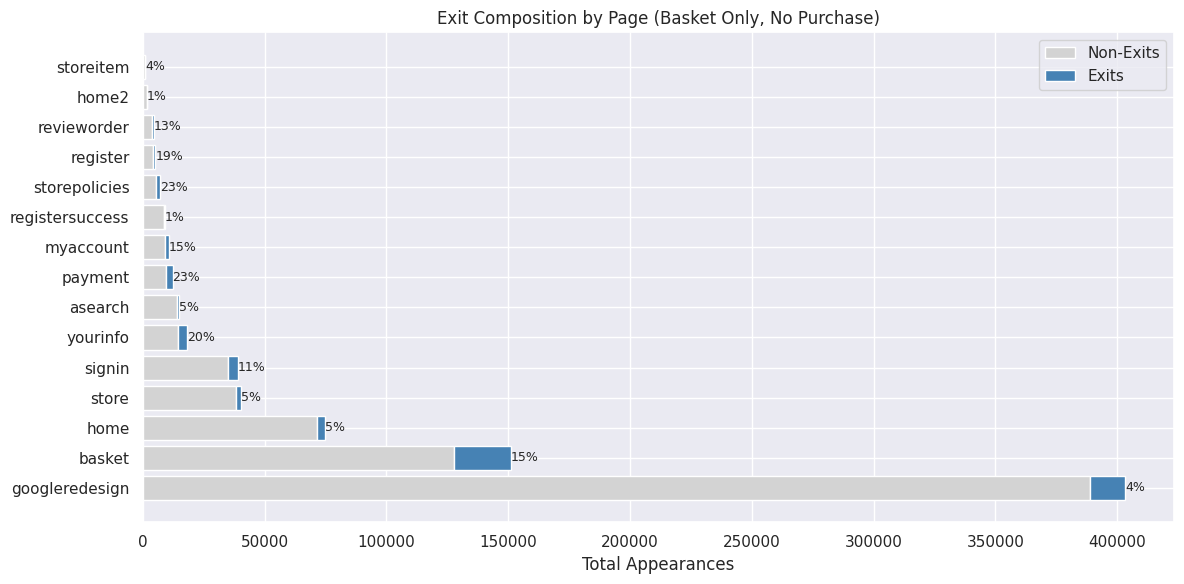

In [ ]:
# 시각화
def plot_stacked_exit(data, title):
    pages = data['page']
    exits = data['exit_count']
    non_exits = data['total_appearances'] - data['exit_count']

    plt.figure(figsize=(12, 6))
    plt.barh(pages, non_exits, label='Non-Exits', color='lightgray')
    plt.barh(pages, exits, left=non_exits, label='Exits', color='steelblue')

    for i in range(len(pages)):
        total = data.iloc[i]['total_appearances']
        rate = data.iloc[i]['exit_rate']
        plt.text(total + 5, i, f"{rate:.0%}", va='center', fontsize=9)

    plt.xlabel("Total Appearances")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_stacked_exit(purchase_exit, "Exit Composition by Page (Basket → Purchase Completed)")
plot_stacked_exit(abandoned_exit, "Exit Composition by Page (Basket Only, No Purchase)")

[ 결과 해석 ]
- /basket (0.15)  
  : 장바구니 담기 후 결제 흐름 진입 실패
  -> 장바구니 페이지에서 주문 요약 간소화/ 바로 결제하기 버튼 강조/ 가격 할인, 혜택 강조
- /payment (0.23)
  : 실제 결제 과정에서 이탈 (가장 치명적)
  -> 결제 수단 다양화/ 심리적 저항 해소(배송비, 반품 정책)/ 후기 강조
- /storepolicies, /yourinfo, resigter  
  : 로그인/ 계정 장벽 or 정책 확인 후 이탈  
    -> 로그인 없이 게스트 구매 허용, 소셜 로그인 도입 / 구매 전 확인 내용 강조

In [ ]:
## 전환 세션과 이탈 세션의 페이지별 이탈률 비교
## 어디서 불필요한 이탈이 많이 발생하는지
## 개선 우선순위와 예상 임팩트(Preventable Exits)
## 이탈률 차이가 통계적으로 유의한지(Z값)


def page_exit_metrics(df_subset, min_n=50):
    d = df_subset.copy()
    d['exit_page'] = d['clean_path_array'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) else None)

    pages = d[['clean_path_array']].explode('clean_path_array').dropna()
    page_counts = pages['clean_path_array'].value_counts().rename_axis('page').reset_index(name='total_appearances')
    exit_counts = d['exit_page'].value_counts().rename_axis('page').reset_index(name='exit_count')

    m = exit_counts.merge(page_counts, on='page', how='inner')
    m = m[m['total_appearances'] >= min_n]
    m['exit_rate'] = m['exit_count'] / m['total_appearances']
    return m

m_purchase  = page_exit_metrics(purchase_df,  min_n=50)
m_abandon   = page_exit_metrics(abandoned_df, min_n=50)

common = m_purchase.merge(m_abandon, on='page', suffixes=('_purchase', '_abandoned'))
common['exit_rate_diff'] = common['exit_rate_abandoned'] - common['exit_rate_purchase']
common['priority'] = common['exit_rate_diff'] * np.log1p(common['total_appearances_abandoned'])
common = common.sort_values('priority', ascending=False)

In [ ]:
common['preventable_exits'] = (
    common['exit_count_abandoned'] -
    common['exit_rate_purchase'] * common['total_appearances_abandoned']
).clip(lower=0).round()

# 이 값이 큰 페이지부터 개선 → 예상 임팩트가 큼

# 자연 종료 페이지 제외
terminal_pages = {'ordercompleted'}
common = common[~common['page'].isin(terminal_pages)]

In [ ]:
from math import sqrt
def z_prop(x1,n1,x2,n2):
    p = (x1+x2)/(n1+n2)
    return (x1/n1 - x2/n2) / sqrt(p*(1-p)*(1/n1+1/n2))
common['z'] = common.apply(lambda r: z_prop(
    r['exit_count_abandoned'], r['total_appearances_abandoned'],
    r['exit_count_purchase'],  r['total_appearances_purchase']
), axis=1)


In [ ]:
common

,page,exit_count_purchase,total_appearances_purchase,exit_rate_purchase,exit_count_abandoned,total_appearances_abandoned,exit_rate_abandoned,exit_rate_diff,priority,preventable_exits,z
9,payment,18,23478,0.000767,2861,12250,0.233551,0.232784,2.191284,2852.0,76.731698
11,yourinfo,11,19373,0.000568,3623,18120,0.199945,0.199377,1.954857,3613.0,65.207596
5,basket,94,58433,0.001609,23068,150991,0.152777,0.151169,1.802683,22825.0,98.930314
6,storepolicies,72,716,0.100559,1620,7037,0.230212,0.129653,1.148607,912.0,8.001947
7,signin,51,13465,0.003788,4270,39111,0.109176,0.105389,1.114401,4122.0,38.404116
10,revieworder,13,14427,0.000901,577,4453,0.129576,0.128674,1.081066,573.0,43.139481
8,asearch,28,4933,0.005676,782,15001,0.052130,0.046454,0.446697,697.0,14.335150
2,googleredesign,680,125678,0.005411,14168,403162,0.035142,0.029732,0.383748,11987.0,55.710485
4,home,165,13607,0.012126,3402,74801,0.045481,0.033355,0.374325,2495.0,18.187856
3,store,318,13702,0.023208,2157,40375,0.053424,0.030216,0.320469,1220.0,14.624082


```/googleredesign (1차 진입)  
  → /basket (담기)  
   → /yourinfo → /signin  
     → /storepolicies  
       → /revieworder  
         → /payment ← 가장 많은 이탈!!


#### 사용자 행동군 분류 및 전략 요약
- 무관심 방문자 : 잘못된 타겟팅으로 기대와 불일치한 랜딩 콘텐츠로 인해 /home에서 즉시 이탈하는 사용자로, 사이트 행동 없이 이탈한 사용자를 의미한다. 이의 경우 타겟 정교화와 초반 콘텐츠 재구성이 필요해 보임
- 신뢰 부족 사용자 : 상세페이지까지 접근하나 장바구니 이전 단계에서 이탈하는 사용자이다. 이 경우 후기나 브랜드 정보와 정책 신뢰도 강화를 통해 사용자를 유치시킬 수 있다.
- 정보 수집자 : 구매 목적 없이 정책, 친환경 정보 등을 탐색하며 이탈하는 경우이다. 처음부터 상품에 관심이 아닌 정책에 대한 정보를 위해 들어오는 사용자이지만, 정보성 콘텐치에 자연스로운 CTA 흐름을 설계해 행동 유도를 도모할 수 있다.
- 장바구니 포기자 : 구매 의지가 있음에도 결제 전환에 실해한 사용자이다. 이 경우 우리 사이트에 경쟁력이 없다고 판단할 수 있으나 결제 프로세스의 문제로 인해 야기될 수 있으므로, 결제 프로세스를 간소화하는 것이 필요하다. 또한 UX 개선, 할인/혜택/ 쿠폰 등과 같이 실질적인 유도 전략이 필요하다.
- 반복 탐색자 : 구매 직전짜기 도달 후 유보하거나 비교 중인 고객으로 장바구니 리케팅, 가격 알림 및 후기 업데이트 안내 등 후속 접점 설계가 효과적이다.

-> /payment, /yourinfo, /basket, /revieworder에서 전환 실패 세션의 이탈률이 높게 나타났으며, 이는 실제 구매로 이어지는 핵심 단계에서의 UX/신뢰/심리적 장벽이 병목 지점으로 작용하고 있음을 시사한다. 따라서 각 행동군에 맞춘 맞춤형 설계와 실험적 개선(A/B 테스트)이 필요해 보인다.


## 5-3. googleredesign 내 콘텐츠 분석


- 본 분석에서 /googleredesign 페이지가 전체 사용자 방문 흐름 중 가장 많은 탐색이 발생한 주요 페이지이자, /home 다음으로 이탈률이 높은 핵심 병목 지점으로 확인되었다. 이는 사용자가 제품에 대한 관심을 가지고 해당 상세 페이지로 진입했음에도 불구하고, 구매로의 연결이 원활히 이루어지지 않고 있음을 시사한다.  
- 지금까지의 분석은 pagePath의 첫 수준만을 가지고 했다면, 더 깊이 들어가 googleredesign만을 기준으로 해당 페이지 내 어떤 콘텐츠가 전환을 유도하고 어떤 콘텐츠에서 이탈이 발생했는지 파악해보고자 한다. 이를 통해 사이트 내 상품 경쟁력 분석, 콘텐츠 전략 개선, 전환 퍼널 최적화까지 연결을 해보면서 실효성 있는 구매 전환 전략을 수립해보고자 한다.

In [ ]:
df[['page_sequence']]

,page_sequence
0,"[/google+redesign/drinkware, /home]"
1,[/google+redesign/brands/youtube/home]
2,"[/home, /home]"
3,"[/home, /home]"
4,"[/home, /home]"
...,...
903548,[/google+redesign/apparel/mens+outerwear/mens+...
903549,[/google+redesign/lifestyle/fun/malibu+sunglas...
903550,"[/home, /home, /google+redesign/apparel/mens/m..."
903551,"[/google+redesign/shop+by+brand/youtube, /goog..."


In [ ]:
# page_sequence 리스트로 변환
import ast

df['page_sequence'] = df['page_sequence'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# 기준 첫 번째 경로 추출 함수
def extract_first_level_from_path(path):
    return '/' + path.split('/')[1] if isinstance(path, str) and '/' in path else None

# 전체 page_sequence에서 모든 경로에 적용
# 모든 세션의 page_sequence를 flatten하고 첫 경로 추출
all_first_levels = []

for seq in df['page_sequence']:
    if isinstance(seq, list):
        for path in seq:
            first_level = extract_first_level_from_path(path)
            if first_level:
                all_first_levels.append(first_level)

# 빈도 수 계산
first_level_counts = pd.Series(Counter(all_first_levels)).sort_values(ascending=False)

In [ ]:
# 문자열인 경우 실제 리스트로 변환
df['page_sequence'] = df['page_sequence'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
# numpy.ndarray → list 변환
df['page_sequence'] = df['page_sequence'].apply(lambda x: list(x) if isinstance(x, np.ndarray) else x)


# 첫 번째 경로 추출 함수
def extract_first_level_from_path(path):
    return '/' + path.split('/')[1] if isinstance(path, str) and '/' in path else None

# 전체 page_sequence에서 모든 경로의 첫 번째 레벨 수집
all_first_levels = []

for seq in df['page_sequence']:
    if isinstance(seq, list):
        for path in seq:
            first_level = extract_first_level_from_path(path)
            if first_level:
                all_first_levels.append(first_level)

# 빈도 수 계산 및 시각화
first_level_counts = pd.Series(Counter(all_first_levels)).sort_values(ascending=False)

# 결과 출력
print(first_level_counts.head(20))

/google+redesign                            1766967
/home                                        981293
/basket.html                                 209412
/store.html                                  107442
/signin.html                                 101299
/asearch.html                                 78137
/yourinfo.html                                37533
/payment.html                                 35812
/ordercompleted.html                          25291
/store-policies                               21941
/myaccount.html?mode=vieworder                18967
/revieworder.html                             18931
/registersuccess.html                         16439
/myaccount.html?mode=billingaddress           13338
/myaccount.html?mode=vieworderdetail          13326
/home-2                                       10517
/register.html                                 8515
/google redesign                               2848
/storeitem.html                                2213
/myaccount.h

###  /google+redesign 경로 분석 관련 문제점
-  /google+redesign 경로군은 전체 페이지 흐름에서 주요 비중을 차지하나, 그 내부 구조는 중첩, 중복, 오타, 의미 불명 경로 등 다수의 전처리 문제가 존재함. 다른 상위 경로에는 큰 문제가 발견되지 않았음.
1. 경로 구조의 중첩 및 비정형적 URL
  - ex) /google+redesign/apparel/google+redesign/apparel/google+redesign/shop+by+brand/...
  - 특정 URL 내에서 /google+redesign가 여러 번 반복 충첩되어 나타나는 사례가 빈번하게 발견됨
  - 정상적인 콘텐츠 탐색 경로라기보다 로그 수집 중의 중복, 오작동, 또는 리디렉션 오류 가능성을 시사
2. 혼합된 콘텐트 트리 및 의미 불명 경로
  - ex) /google+redesign/accessories/stickers/store-policies/terms-of-use/...
  - 제품 상세 경로에 store-policies나 myaccount, wishlist 등의 사용자 계정 혹으 정책 페이지가 혼합되어 존재
  - 실제 흐름이기 보다는 스크립트 오류 또는 페이지 내 동적 로딩으로 인한 누적 URL 기록일 수 있음
3. 불규칙한 구분자 및 오타 포함
4. 유사 경로의 중복 존재

[해결법]
- URL 내 google+redesign가 여러 번 중복되어 나타나는 경우, 가장 마지막으로 등장하는 인덱스를 기준으로 이후 경로만 유지하도록 정제하겠다
- 실제 사용자가 탐색한 상품/콘텐츠 카테고리를 기반으로 정확한 의도를 파악하면서 의미 있는 콘텐츠 흐름을 보존하고자 한다.
- 경로 중복 문제를 제거하여 클러스터링, 카테고리 분류, 페이지 전이 모델에 일관성을 부여하여 노이즈 제거 및 정규화하고자 한다.


1. 의미는 유사하지만 오타/파생형이 섞인 경우 -> 한 카테고리로 병합

| 원래 값                                                                 | 병합 대상 (수정)        |
| -------------------------------------------------------------------- | ----------------- |
| aparel, apparelc create, apparels, apparelwomens, apparela, apparelx | **apparel**       |
| bag, bags zipper front                                               | **bags**          |
| accessories😃👍, accessories-puppy                                   | **accessories**   |
| electronic                                                           | **electronics**   |
| lifestylewater bottle with straw                                     | **lifestyle**     |
| drinkware\&rct=..., drinkware=\[kavita], drinkware\&utm\_...         | **drinkware**     |
| shop+by+brand'', shop+by+brand'                                      | **shop+by+brand** |

2. 정책/계정 관련 경로
- store-policies, wishlist.html, basket.html, myaccount.html?mode=billingaddress-

3. 마게팅/이젠트성, 기타 혼합 키워드
- spring+sale, spring+break, limited+supply, new+2015+logo, fruit-games, fruit+games
4. 노이즈 제거
- 개수가 적은 경우 검토 후 삭제 진행

In [ ]:
import re, ast, numpy as np
import pandas as pd

# -----------------------------
# 0) 전제: df는 세션 단위
#    필요한 컬럼: session_id, page_sequence, basket_converted, purchase_converted
#    - page_sequence: list | ndarray | str("[..., ...]") 모두 허용
# -----------------------------

# 1) page_sequence 표준화
def to_list(obj):
    if isinstance(obj, list):
        return obj
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, str):
        try:
            v = ast.literal_eval(obj)
            return v.tolist() if isinstance(v, np.ndarray) else list(v)
        except Exception:
            return [obj]
    return [] if pd.isna(obj) else [str(obj)]

df = df.copy()
df["page_sequence"] = df["page_sequence"].apply(to_list)

# 2) URL 정규화 (소문자, 쿼리/해시 제거, 중복 슬래시/트레일링 슬래시 정리, .html 제거)
def normalize_path(p: str) -> str:
    if not isinstance(p, str):
        p = str(p)
    p = p.lower().strip()
    p = p.split('?', 1)[0].split('#', 1)[0]           # query, fragment 제거
    p = re.sub(r'\.html?$', '', p)                    # .html/.htm 제거
    p = re.sub(r'//+', '/', p)                        # '//' -> '/'
    p = p.rstrip('/') if p != '/' else p              # trailing slash
    return p

# 3) /google+redesign가 여러 번 중첩되면 "마지막" 이후만 유지 (실제 본 서브경로 보존)
def clean_google_redesign_path(path: str) -> str:
    if 'google+redesign' in path:
        idx = path.rfind('google+redesign')
        return '/' + path[idx:]
    return path

# 4) 연속 중복 페이지 압축(새로고침/자동 로딩 노이즈 완화) - 선택적이지만 기본 적용
def compress_consecutive(seq):
    out = []
    for x in seq:
        if not out or out[-1] != x:
            out.append(x)
    return out

df["cleaned_page_sequence"] = (
    df["page_sequence"]
      .apply(lambda seq: [clean_google_redesign_path(normalize_path(p)) for p in seq])
      .apply(compress_consecutive)
)

# 5) 세션별 `/google+redesign` 서브카테고리 추출 (마지막 google+redesign 다음 토큰)
def extract_subcategory_from_sequence(seq):
    for path in seq:
        if 'google+redesign' in path:
            parts = path.split('/')
            try:
                idx = parts.index('google+redesign')
                if idx + 1 < len(parts) and parts[idx+1]:
                    return parts[idx + 1]
            except ValueError:
                continue
    return None

df["subcategory"] = df["cleaned_page_sequence"].apply(extract_subcategory_from_sequence)

# 6) 오타/변형 매핑 + 잡음 제거
category_map = {
    # apparel 변형
    'aparel':'apparel','apparelc create':'apparel','apparels':'apparel',
    'apparelwomens':'apparel','apparela':'apparel','apparelx':'apparel',
    # bags
    'bag':'bags','bags zipper front':'bags',
    # electronics
    'electronic':'electronics',
    # accessories
    'accessories😃👍':'accessories','accessories-puppy':'accessories',
    # drinkware
    'drinkware&rct=j&q=&esrc=s':'drinkware','drinkware&rct=j&frm=1&q=&esrc=s':'drinkware',
    'drinkware&utm_source=test&utm_medium=test':'drinkware','drinkware=[kavita]':'drinkware',
    # shop+by+brand
    "shop+by+brand''":'shop+by+brand',"shop+by+brand'":'shop+by+brand',
    # lifestyle
    'lifestylewater bottle with straw':'lifestyle',
    # 기타 정규화 예시
    'office.':'office', 'fruit+games':'fruit-games',
    'gift-cards':'gift+cards','gift+cards.':'gift+cards'
}
remove_list = {'tel:8553002945','javascript:void(0)','officefajne'}

df["subcategory_clean"] = (
    df["subcategory"]
      .astype('string')
      .str.strip()
      .replace(category_map)
)
df = df[~df["subcategory_clean"].isin(remove_list)]
df = df[~df["subcategory_clean"].isna() & (df["subcategory_clean"] != "None")]

# 7) 요약표 산출 (세션 단위 → 서브카테고리별 전환/이탈 지표)
category_summary = (
    df.groupby("subcategory_clean", as_index=False)
      .agg(
          session_count = ('session_id','count'),
          basket_converted = ('basket_converted','sum'),
          purchase_converted = ('purchase_converted','sum'),
      )
)

category_summary["basket_conversion_rate"]  = category_summary["basket_converted"]  / category_summary["session_count"]
category_summary["purchase_conversion_rate"] = category_summary["purchase_converted"] / category_summary["session_count"]
category_summary["non_conversion_rate"]     = 1 - category_summary["purchase_conversion_rate"]

# (선택) 너무 적은 샘플 제외
category_summary = category_summary[category_summary["session_count"] > 15].sort_values("session_count", ascending=False)

category_summary.head(20)


,subcategory_clean,session_count,basket_converted,purchase_converted,basket_conversion_rate,purchase_conversion_rate,non_conversion_rate
1,apparel,164305,26470,5813,0.161103,0.035379,0.964621
17,shop+by+brand,133335,10925,964,0.081936,0.00723,0.99277
6,electronics,40293,3386,472,0.084034,0.011714,0.988286
3,bags,39242,5416,1124,0.138015,0.028643,0.971357
5,drinkware,26054,4067,698,0.156099,0.026791,0.973209
16,office,23789,4242,1011,0.178318,0.042499,0.957501
0,accessories,21331,3230,604,0.151423,0.028316,0.971684
11,lifestyle,5245,755,150,0.143947,0.028599,0.971401
4,brands,2353,172,0,0.073098,0.0,1.0
9,gift+cards,1591,336,55,0.211188,0.034569,0.965431


/tmp/ipython-input-1609084949.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1609084949.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1609084949.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




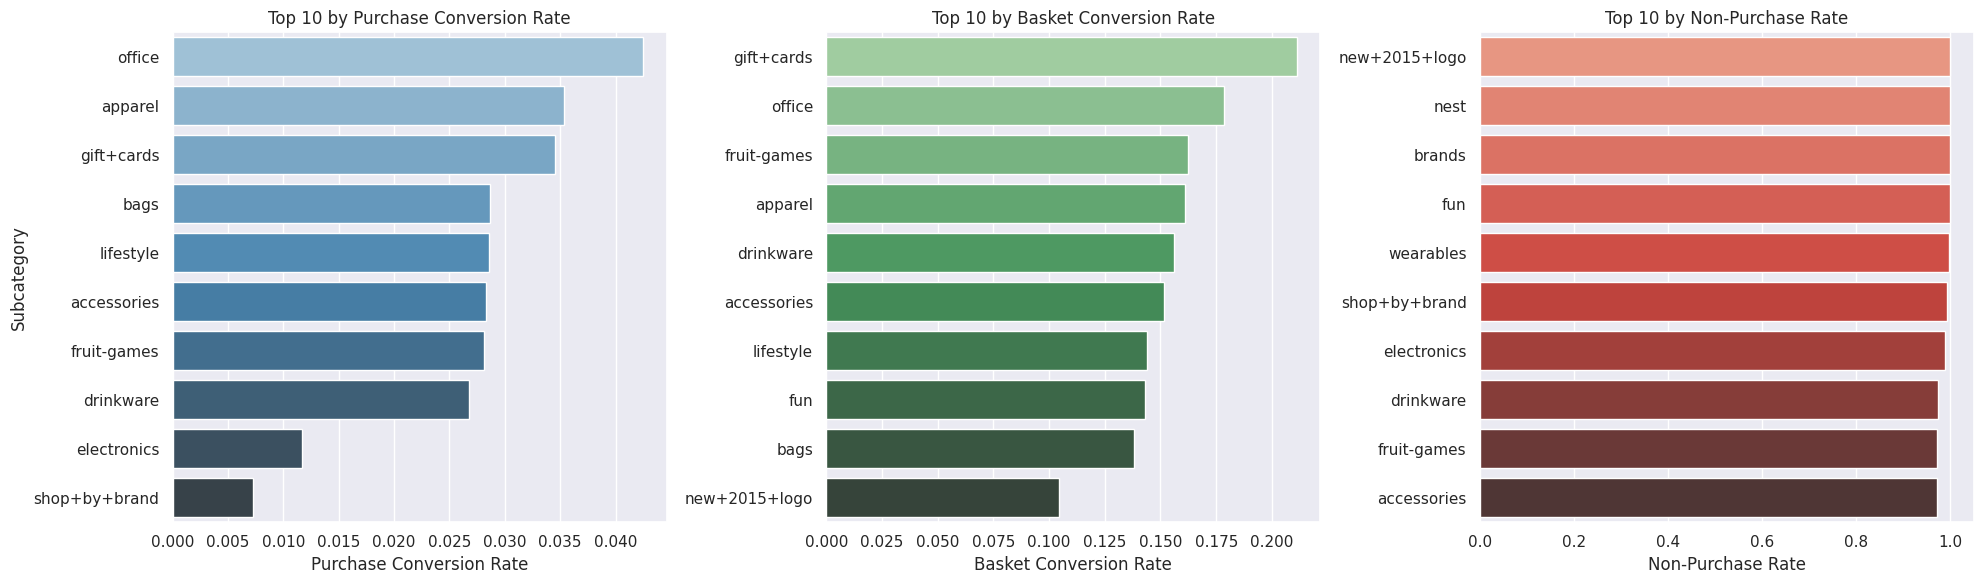

In [ ]:
category_summary = category_summary[category_summary['session_count']>15]

# 고급 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. 구매 전환율 상위 10개
top_purchase = category_summary.sort_values(by='purchase_conversion_rate', ascending=False).head(10)
sns.barplot(data=top_purchase, x='purchase_conversion_rate', y='subcategory_clean', ax=axes[0], palette='Blues_d')
axes[0].set_title('Top 10 by Purchase Conversion Rate')
axes[0].set_xlabel('Purchase Conversion Rate')
axes[0].set_ylabel('Subcategory')

# 2. 장바구니 전환율 상위 10개
top_basket = category_summary.sort_values(by='basket_conversion_rate', ascending=False).head(10)
sns.barplot(data=top_basket, x='basket_conversion_rate', y='subcategory_clean', ax=axes[1], palette='Greens_d')
axes[1].set_title('Top 10 by Basket Conversion Rate')
axes[1].set_xlabel('Basket Conversion Rate')
axes[1].set_ylabel('')

# 3. 구매 미전환율 상위 10개
top_exit = category_summary.sort_values(by='non_conversion_rate', ascending=False).head(10)
sns.barplot(data=top_exit, x='non_conversion_rate', y='subcategory_clean', ax=axes[2], palette='Reds_d')
axes[2].set_title('Top 10 by Non-Purchase Rate')
axes[2].set_xlabel('Non-Purchase Rate')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
## 서브 카테고리 별 장바구니 이후 효율
#  category_summary가 있다고 가정
cs = category_summary.copy()

# 1) 체크아웃 효율(조건부): 장바구니 → 구매
cs['basket_to_purchase_rate'] = np.where(
    cs['basket_converted'] > 0,
    cs['purchase_converted'] / cs['basket_converted'],
    np.nan
)

# 2) 우선순위 스코어(규모×손실): '구매 미전환' 잠재 절감량
site_top_quartile = cs['purchase_conversion_rate'].quantile(0.75)
cs['preventable_purchases'] = ((site_top_quartile - cs['purchase_conversion_rate'])
                               .clip(lower=0) * cs['session_count']).round()

# 3) 보고서용 정렬(임팩트 중심)
priority = (cs[['subcategory_clean','session_count',
                'basket_conversion_rate','purchase_conversion_rate',
                'basket_to_purchase_rate','preventable_purchases']]
            .sort_values(['preventable_purchases','session_count'], ascending=False))

priority.head(10)


,subcategory_clean,session_count,basket_conversion_rate,purchase_conversion_rate,basket_to_purchase_rate,preventable_purchases
17,shop+by+brand,133335,0.081936,0.00723,0.088238,2852.0
6,electronics,40293,0.084034,0.011714,0.139398,681.0
4,brands,2353,0.073098,0.0,0.000000,67.0
5,drinkware,26054,0.156099,0.026791,0.171625,48.0
14,nest,1476,0.092818,0.0,0.000000,42.0
22,wearables,360,0.080556,0.002778,0.034483,9.0
0,accessories,21331,0.151423,0.028316,0.186997,7.0
15,new+2015+logo,67,0.104478,0.0,0.000000,2.0
7,fruit-games,1244,0.162379,0.028135,0.173267,1.0
8,fun,42,0.142857,0.0,0.000000,1.0


In [ ]:
priority

,subcategory_clean,session_count,basket_conversion_rate,purchase_conversion_rate,basket_to_purchase_rate,preventable_purchases
17,shop+by+brand,133335,0.081936,0.00723,0.088238,2852.0
6,electronics,40293,0.084034,0.011714,0.139398,681.0
4,brands,2353,0.073098,0.0,0.000000,67.0
5,drinkware,26054,0.156099,0.026791,0.171625,48.0
14,nest,1476,0.092818,0.0,0.000000,42.0
22,wearables,360,0.080556,0.002778,0.034483,9.0
0,accessories,21331,0.151423,0.028316,0.186997,7.0
15,new+2015+logo,67,0.104478,0.0,0.000000,2.0
7,fruit-games,1244,0.162379,0.028135,0.173267,1.0
8,fun,42,0.142857,0.0,0.000000,1.0


In [ ]:
# 우선순위 정밀화
# Beta-Binomial shrinkage for purchase rate
def beta_ci(success, total, a=1, b=1, alpha=0.05):
    from scipy.stats import beta
    post_a, post_b = a+success, b+total-success
    mean = post_a/(post_a+post_b)
    lo, hi = beta.ppf([alpha/2, 1-alpha/2], post_a, post_b)
    return mean, lo, hi

cs = category_summary.copy()
cs[['p_mean','p_lo','p_hi']] = cs.apply(
    lambda r: pd.Series(beta_ci(r['purchase_converted'], r['session_count'])), axis=1)

cs

,subcategory_clean,session_count,basket_converted,purchase_converted,basket_conversion_rate,purchase_conversion_rate,non_conversion_rate,p_mean,p_lo,p_hi
1,apparel,164305,26470,5813,0.161103,0.035379,0.964621,0.035385,0.034497,0.036284
17,shop+by+brand,133335,10925,964,0.081936,0.00723,0.99277,0.007237,0.006789,0.007699
6,electronics,40293,3386,472,0.084034,0.011714,0.988286,0.011738,0.010710,0.012813
3,bags,39242,5416,1124,0.138015,0.028643,0.971357,0.028667,0.027039,0.030340
5,drinkware,26054,4067,698,0.156099,0.026791,0.973209,0.026827,0.024900,0.028823
16,office,23789,4242,1011,0.178318,0.042499,0.957501,0.042537,0.040009,0.045138
0,accessories,21331,3230,604,0.151423,0.028316,0.971684,0.028360,0.026175,0.030629
11,lifestyle,5245,755,150,0.143947,0.028599,0.971401,0.028778,0.024428,0.033469
4,brands,2353,172,0,0.073098,0.0,1.0,0.000425,0.000011,0.001566
9,gift+cards,1591,336,55,0.211188,0.034569,0.965431,0.035154,0.026679,0.044733
